# Frontmatter 

In [1133]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import TwoSlopeNorm
from scipy.ndimage import gaussian_filter
# Define font properties
font = {
    'family': 'sans-serif',  # Use sans-serif family
    'sans-serif': ['Helvetica'],  # Specify Helvetica as the sans-serif font
    'size': 14  # Set the default font size
}
plt.rc('font', **font)

# Set tick label sizes
plt.rc('ytick', labelsize=24)
plt.rc('xtick', labelsize=24)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
# Customize axes spines and legend appearance
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['legend.frameon'] = False


%load_ext autoreload
%autoreload 2
    
from dwMRI_BasicFuncs import *
from joblib import Parallel, delayed

from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
network_path = './Networks/'
image_path   = '../Figures/'
if not os.path.exists(image_path):
    os.makedirs(image_path)
NoiseLevels = [None,20,10,5,2]

TrainingSamples = 50000
InferSamples    = 500

lower_abs,upper_abs = -0.07,0.07
lower_rest,upper_rest = -0.015,0.015
lower_S0 = 25
upper_S0 = 2000
Save = True

TrueCol  = 'k'
NoisyCol = 'k'
WLSFit   = 'sandybrown'#np.array([225,190,106])/255
NLLSFit   = np.array([64,176,166])/255

Errors_name = ['MD comparison','FA comparison','eig. comparison','Frobenius','Signal comparison','Correlation','Signal comparison','Correlation2']
custom_prior = DTIPriorS0(lower_abs,upper_abs,lower_rest,upper_rest,lower_S0,upper_S0)
priorS0, *_ = process_prior(custom_prior) 

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


## PLotting

In [3]:
def BoxPlots(y_data, positions, colors, colors2, ax,hatch = False,scatter=False,scatter_alpha=0.5, **kwargs):

    GREY_DARK = "#747473"
    jitter = 0.02
    # Clean data to remove NaNs column-wise
    if(np.ndim(y_data) == 1):
        cleaned_data = y_data[~np.isnan(y_data)]
    else:
        cleaned_data = [d[~np.isnan(d)] for d in y_data]
    
    # Define properties for the boxes (patch objects)
    boxprops = dict(
        linewidth=2, 
        facecolor='none',       # use facecolor for filling (set to 'none' if you want no fill)
        edgecolor='turquoise'   # edgecolor for the outline
    )

    # Define properties for the medians (Line2D objects)
    # Ensure GREY_DARK is defined (or replace it with a color string)
    medianprops = dict(
        linewidth=2, 
        color=GREY_DARK,
        solid_capstyle="butt"
    )

    # For whiskers, since they are Line2D objects, use 'color'
    whiskerprops = dict(
        linewidth=2, 
        color='turquoise'
    )

    bplot = ax.boxplot(
        cleaned_data,
        positions=positions, 
        showfliers=False,
        showcaps = False,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        boxprops=boxprops,
        patch_artist=True,
        **kwargs
    )

    # Update the color of each box (these are patch objects)
    for i, box in enumerate(bplot['boxes']):
        box.set_edgecolor(colors[i])
        if(hatch):
            box.set_hatch('/')
    
    
    # Update the color of the whiskers (each box has 2 whiskers)
    for i in range(len(positions)):
        bplot['whiskers'][2*i].set_color(colors[i])
        bplot['whiskers'][2*i+1].set_color(colors[i])
    
    # If caps are enabled, update their color (Line2D objects)
    if 'caps' in bplot:
        for i, cap in enumerate(bplot['caps']):
            cap.set_color(colors[i//2])  # two caps per box

    if(scatter):
        if(np.ndim(cleaned_data) == 1):
            x_data = np.array([positions] * len(cleaned_data))
            x_jittered = x_data + stats.t(df=6, scale=jitter).rvs(len(x_data))
            ax.scatter(x_data, cleaned_data, s=100, color=colors2, alpha=scatter_alpha)
        else:
            x_data = [np.array([positions[i]] * len(d)) for i, d in enumerate(cleaned_data)]
            x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
            # Plot the scatter points with jitter (using colors2)
            for x, y, c in zip(x_jittered, cleaned_data, colors2):
                ax.scatter(x, y, s=100, color=c, alpha=scatter_alpha)

# Fig 3

In [376]:
FigLoc = image_path + 'Fig_3/'
if not os.path.exists(FigLoc):
    os.makedirs(FigLoc)

## a

In [4]:
fdwi = './HCP_data/Pat'+str(1)+'/diff_1k.nii.gz'
bvalloc = './HCP_data/Pat'+str(1)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(1)+'/bvecs_1k.txt'

bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

data, affine, img = load_nifti(fdwi, return_img=True)
data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
axial_middle = data.shape[2] // 2
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(5):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

selected_indices = [0]+selected_indices

bvalsHCP7 = bvalsHCP[selected_indices]
bvecsHCP7 = bvecsHCP[selected_indices]
gtabHCP7 = gradient_table(bvalsHCP7, bvecsHCP7)

In [5]:
custom_prior = DTIPriorS0Noise(lower_abs,upper_abs,lower_rest,upper_rest,lower_S0,upper_S0,0,30)
priorS0Noise, *_ = process_prior(custom_prior) 

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


In [6]:
if os.path.exists(f"{network_path}/DTIHCPFull.pickle"):
    with open(f"{network_path}/DTIHCPFull.pickle", "rb") as handle:
        posterior2 = pickle.load(handle)
else:
    np.random.seed(1)
    torch.manual_seed(1)
    bvals = gtabHCP.bvals
    bvecs = gtabHCP.bvecs
    Obs = []
    Par = []
    for i in tqdm.tqdm(range(TrainingSamples)):
        params = priorS0.sample()
        dt = ComputeDTI(params[:-1])
        dt = ForceLowFA(dt)
        Obs.append(CustomSimulator(dt,gtabHCP,params[-1],np.random.rand()*30 + 20))
        Par.append(np.hstack([mat_to_vals(dt),params[-1]]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    Obs = torch.tensor(Obs).float()
    Par= torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE(prior=priorS0)
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posterior2 = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{save_path}/DTIHCPFull.pickle"):
        with open(f"{save_path}/DTIHCPFull.pickle", "wb") as handle:
            pickle.dump(posterior2, handle)

In [7]:
ArrShape = maskdata[:,:,axial_middle,0].shape
NoiseEst = np.zeros([55,64,7])
VarEst   = np.zeros([55,64])

In [8]:
# Compute the mask where the sum is not zero
mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0

# Get the indices where mask is True
indices = np.argwhere(mask)

# Define the function for optimization
def optimize_pixel(i, j):
    torch.manual_seed(10)  # If required
    posterior_samples_1 = posterior2.sample((1000,), x=maskdata[i, j,axial_middle, :91],show_progress_bars=False)
    return i, j, np.array([histogram_mode(p) for p in posterior_samples_1.T])

# Initialize array with the appropriate shape
ArrShape = mask.shape

# Use joblib to parallelize the optimization tasks
results = Parallel(n_jobs=-1)(
    delayed(optimize_pixel)(i, j) for i, j in tqdm(indices)
)

NoiseEst = np.zeros(list(ArrShape) + [7])

# Assign the optimization results to InferredParams
for i, j, x in results:
    NoiseEst[i, j] = x

  0%|          | 0/2592 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:584: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715184454275/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  x = atleast_2d(torch.as_tensor(x, dtype=float32))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:584: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before c

In [9]:
NoiseEst2 =  np.zeros_like(NoiseEst)
for i in range(55):
    for j in range(64):    
        NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,-1]])
MD_SBIFull = np.zeros([55,64])
FA_SBIFull = np.zeros([55,64])
for i in range(55):
    for j in range(64):
        Eigs = np.linalg.eigh(vals_to_mat(NoiseEst2[i,j,:6]))[0]
        MD_SBIFull[i,j] = np.mean(Eigs)
        FA_SBIFull[i,j] = FracAni(Eigs,np.mean(Eigs))
FA_SBIFull[np.isnan(FA_SBIFull)] = 0

In [10]:
tenmodel = dti.TensorModel(gtabHCP,return_S0_hat = True,fit_method='NLLS')
tenfit = tenmodel.fit(maskdata[:,:,axial_middle])
FAFull = dti.fractional_anisotropy(tenfit.evals)
MDFull = dti.mean_diffusivity(tenfit.evals)

In [11]:
for i in range(55):
    for j in range(64):
        if(np.sum(maskdata[i,j,axial_middle,:]) == 0):
            FAFull[i,j] = 0

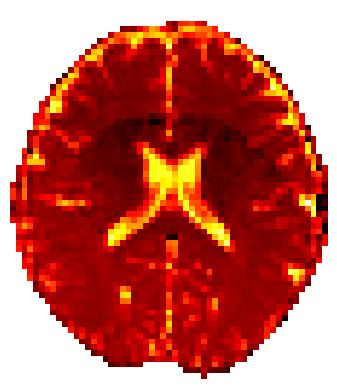

In [12]:
temp = np.copy(MD_SBIFull)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
vmin, vmax = img.get_clim()

if Save: plt.savefig(FigLoc+'HCP_SBI_MD.pdf',format='pdf',bbox_inches='tight',transparent=True)

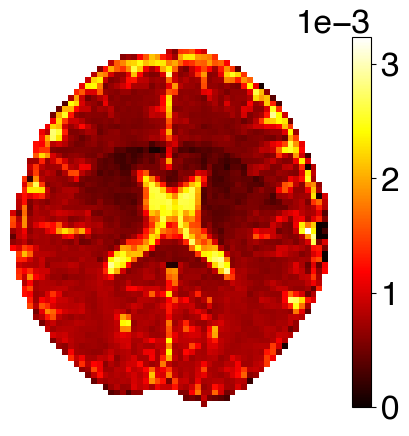

In [30]:
temp = np.copy(MDFull)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
vmin, vmax = img.get_clim()
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

if Save: plt.savefig(FigLoc+'HCP_WLS_MD.pdf',format='pdf',bbox_inches='tight',transparent=True)

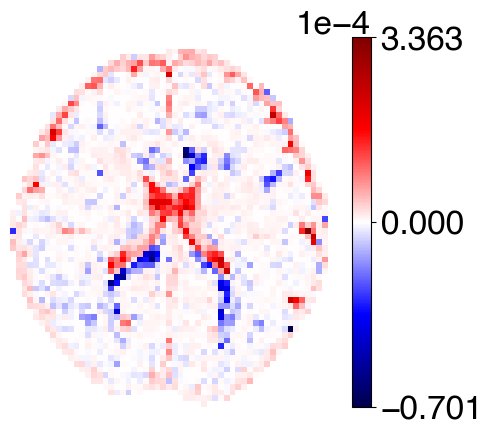

In [14]:
data = MD_SBIFull.T-MDFull.T
data[~mask.T] = np.nan
norm = TwoSlopeNorm(vmin=np.nanmin(data), vcenter=0, vmax=np.nanmax(data))
plt.imshow(data,cmap='seismic',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
ticks = [np.nanmin(data), 0, np.nanmax(data)]  # Adjust the number of ticks as needed
cbar.set_ticks(ticks)
cbar.formatter.set_powerlimits((0, 0))

if Save: plt.savefig(FigLoc+'HCP_MD_Diff.pdf',format='pdf',bbox_inches='tight',transparent=True)

## b

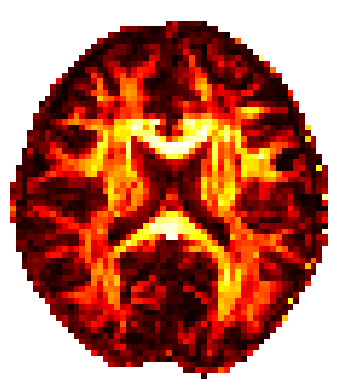

In [15]:
temp = np.copy(FA_SBIFull)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
vmin, vmax = img.get_clim()

if Save: plt.savefig(FigLoc+'HCP_SBI_FA.pdf',format='pdf',bbox_inches='tight',transparent=True)

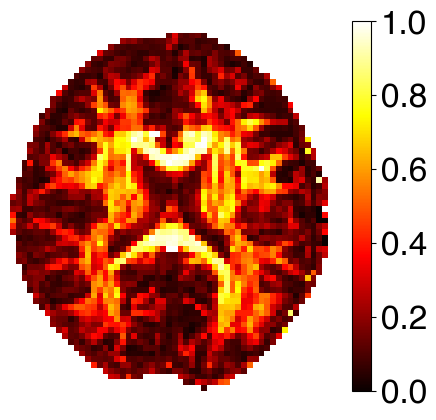

In [31]:
temp = np.copy(FAFull)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
vmin, vmax = img.get_clim()
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

if Save: plt.savefig(FigLoc+'HCP_WLS_FA.pdf',format='pdf',bbox_inches='tight',transparent=True)

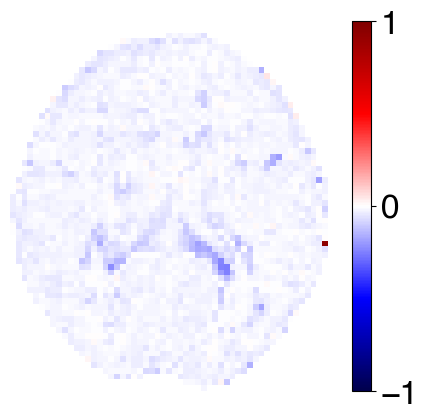

In [17]:
data = FA_SBIFull.T-FAFull.T
data[~mask.T] = np.nan
plt.imshow(data,cmap='seismic',vmin=-1, vmax=1)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
ticks = [-1, 0, 1]  # Adjust the number of ticks as needed
cbar.set_ticks(ticks)
if Save: plt.savefig(FigLoc+'HCP_FA_Diff.pdf',format='pdf',bbox_inches='tight',transparent=True)

## c

In [18]:
if os.path.exists(f"{network_path}/DTIHCPMin.pickle"):
    with open(f"{network_path}/DTIHCPMin.pickle", "rb") as handle:
        posterior7_2 = pickle.load(handle)
else:
    np.random.seed(1)
    torch.manual_seed(1)
    bvals = gtabHCP.bvals
    bvecs = gtabHCP.bvecs
    Obs = []
    Par = []
    for i in tqdm.tqdm(range(TrainingSamples)):
        params = priorS0.sample()
        dt = ComputeDTI(params[:-1])
        dt = ForceLowFA(dt)
        Obs.append(CustomSimulator(dt,gtabHCP7,params[-1],np.random.rand()*30 + 20))
        Par.append(np.hstack([mat_to_vals(dt),params[-1]]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    Obs = torch.tensor(Obs).float()
    Par= torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE(prior=priorS0)
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posterior7_2 = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{save_path}/DTIHCPMin.pickle"):
        with open(f"{save_path}/DTIHCPMin.pickle", "wb") as handle:
            pickle.dump(posterior7_2, handle)

In [19]:
# Compute the mask where the sum is not zero
mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0

# Get the indices where mask is True
indices = np.argwhere(mask)

# Define the function for optimization
def optimize_pixel(i, j):
    torch.manual_seed(10)  # If required
    posterior_samples_1 = posterior7_2.sample((1000,), x=maskdata[i, j,axial_middle, selected_indices],show_progress_bars=False)
    return i, j, np.array([histogram_mode(p) for p in posterior_samples_1.T])

# Initialize array with the appropriate shape
ArrShape = mask.shape

# Use joblib to parallelize the optimization tasks
results = Parallel(n_jobs=-1)(
    delayed(optimize_pixel)(i, j) for i, j in tqdm(indices)
)

NoiseEst = np.zeros(list(ArrShape) + [7])

# Assign the optimization results to InferredParams
for i, j, x in results:
    NoiseEst[i, j] = x

  0%|          | 0/2592 [00:00<?, ?it/s]

In [20]:
NoiseEst2 =  np.zeros_like(NoiseEst)
for i in range(55):
    for j in range(64):    
        NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,-1]])
MD_SBI7 = np.zeros([55,64])
FA_SBI7 = np.zeros([55,64])
for i in range(55):
    for j in range(64):
        Eigs = np.linalg.eigh(vals_to_mat(NoiseEst2[i,j,:6]))[0]
        MD_SBI7[i,j] = np.mean(Eigs)
        FA_SBI7[i,j] = FracAni(Eigs,np.mean(Eigs))
FA_SBI7[np.isnan(FA_SBI7)] = 0

In [21]:
tenmodel = dti.TensorModel(gtabHCP7,return_S0_hat = True,fit_method='NLLS')
tenfit = tenmodel.fit(maskdata[:,:,axial_middle,selected_indices])
FA7 = dti.fractional_anisotropy(tenfit.evals)
MD7 = dti.mean_diffusivity(tenfit.evals)

In [22]:
for i in range(55):
    for j in range(64):
        if(np.sum(maskdata[i,j,axial_middle,:]) == 0):
            FA7[i,j] = 0

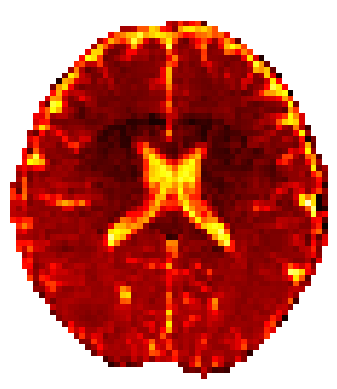

In [34]:
temp = np.copy(MD_SBI7)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot',vmin=0,vmax=3.5e-3)
plt.axis('off')
#cbar = plt.colorbar()
#cbar.formatter.set_powerlimits((0, 0))
vmin, vmax = img.get_clim()

if Save: plt.savefig(FigLoc+'HCP_SBI_MD_7.pdf',format='pdf',bbox_inches='tight',transparent=True)

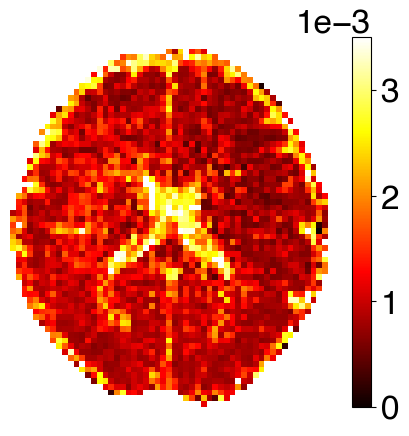

In [35]:
temp = np.copy(MD7)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot',vmin=0,vmax=3.5e-3)
plt.axis('off')
#cbar = plt.colorbar()
#cbar.formatter.set_powerlimits((0, 0))
vmin, vmax = img.get_clim()
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

if Save: plt.savefig(FigLoc+'HCP_WLS_MD_7.pdf',format='pdf',bbox_inches='tight',transparent=True)

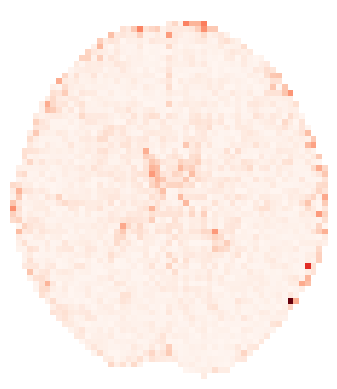

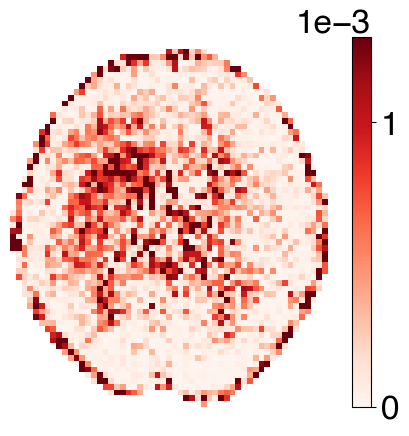

In [25]:
data = np.abs(MD_SBIFull.T-MD_SBI7.T)
data[~mask.T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(data)/2, vmax=np.nanmax(data))
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
if Save: plt.savefig(FigLoc+'DTI_MDSBIErr.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(data)/2, vmax=np.nanmax(data))
ticks = [0, np.round(np.nanmax(data),3)]  # Adjust the number of ticks as needed
data = np.abs(MDFull.T-MD7.T)
data[~mask.T] = np.nan
plt.imshow(data,cmap='Reds',norm=norm)

plt.axis('off')
cbar = plt.colorbar()

cbar.set_ticks(ticks)
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'DTI_MDWLSErr.pdf',format='pdf',bbox_inches='tight',transparent=True)

## d

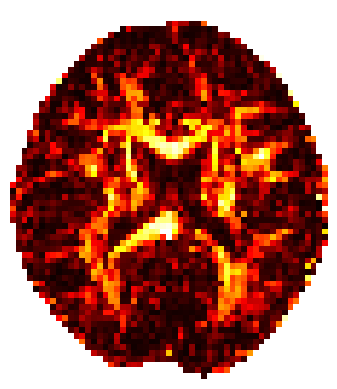

In [26]:
temp = np.copy(FA_SBI7)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
#cbar = plt.colorbar()
#cbar.formatter.set_powerlimits((0, 0))
vmin, vmax = img.get_clim()
if Save: plt.savefig(FigLoc+'HCP_SBI_FA_7.pdf',format='pdf',bbox_inches='tight',transparent=True)

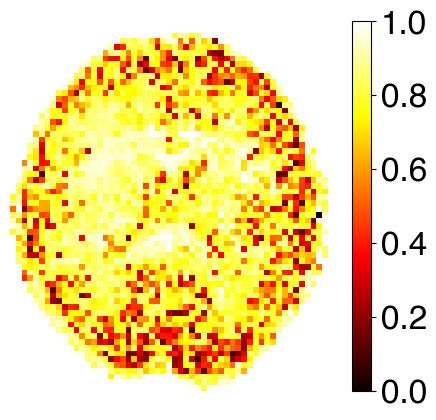

In [27]:
temp = np.copy(FA7)

temp[~mask] = math.nan
img = plt.imshow(temp.T,cmap='hot')
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'HCP_WLS_FA_7.pdf',format='pdf',bbox_inches='tight',transparent=True)

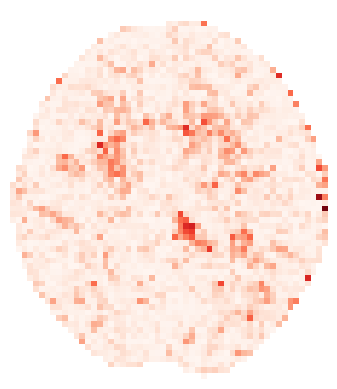

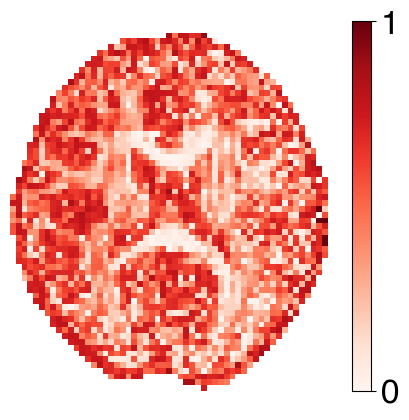

In [28]:
data = np.abs(FA_SBIFull.T-FA_SBI7.T)
data[~mask.T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
if Save: plt.savefig(FigLoc+'DTI_FASBIErr.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
ticks = [0, 1]  # Adjust the number of ticks as needed
data = np.abs(FAFull.T-FA7.T)
data[~mask.T] = np.nan
plt.imshow(data,cmap='Reds',norm=norm)

plt.axis('off')
cbar = plt.colorbar()

cbar.set_ticks(ticks)
if Save: plt.savefig(FigLoc+'DTI_FAWLSErr.pdf',format='pdf',bbox_inches='tight',transparent=True)

## e

In [216]:
Masks = []
maskdatas = []
axial_middles = []
for kk in tqdm(range(32)):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    maskdata, _ = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    axial_middle = maskdata.shape[2] // 2
    # Compute the mask where the sum is not zero
    mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0
    Masks.append(mask)
    maskdatas.append(maskdata[:,:,axial_middle])
    axial_middles.append(axial_middle)

  0%|          | 0/32 [00:00<?, ?it/s]

In [249]:
WMs = []
for kk in tqdm(range(32)):
    WM, affine, img = load_nifti('./flipped/c2Pat'+str(kk+1)+'_FP.nii', return_img=True)
    WMs.append(np.fliplr(WM[:,:,axial_middles[kk]]>0.8))

  0%|          | 0/32 [00:00<?, ?it/s]

In [217]:
i = 1
fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'

bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)


# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(6):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

In [218]:
i = 1
fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'

bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)


# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices20 = [0]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(19):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices20))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices20], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices20.append(next_index)

In [219]:
gTabsF = []
gTabs7 = []
gTabs20 = []

FullDat   = []

for i in tqdm(range(1,33)):
    fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    gTabsF.append(gtabHCP)
    
    bvalsHCP7 = bvalsHCP[selected_indices]
    bvecsHCP7 = bvecsHCP[selected_indices]
    gtabHCP7 = gradient_table(bvalsHCP7, bvecsHCP7)

    gTabs7.append(gtabHCP7)

    bvalsHCP20 = bvalsHCP[selected_indices20]
    bvecsHCP20 = bvecsHCP[selected_indices20]
    gtabHCP20 = gradient_table(bvalsHCP20, bvecsHCP20)

    gTabs20.append(gtabHCP20)

  0%|          | 0/32 [00:00<?, ?it/s]

In [220]:
custom_prior = DTIPriorS0Direc(lower_abs,upper_abs,lower_rest,upper_rest,lower_S0,upper_S0)
priorDirec, *_ = process_prior(custom_prior) 

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


In [221]:
TrainingSamples = 300000

In [222]:
network_path = './Networks/'

In [223]:
if os.path.exists(f"{network_path}/DTIMultiHCPFull_300.pickle"):
    with open(f"{network_path}/DTIMultiHCPFull_300.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    np.random.seed(1)
    torch.manual_seed(1)
    Obs = []
    Par = []
    for i in tqdm(range(TrainingSamples)):
        params = priorDirec.sample()
        dt = ComputeDTI(params[:-2])
        dt = ForceLowFA(dt)
        cG = gTabsF[int(params[-1])]
        Obs.append(np.hstack([CustomSimulator(dt,cG,params[-2],50),params[-1]]))
        Par.append(np.hstack([mat_to_vals(dt),params[-2]]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs=100)
    posteriorFull = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DTIMultiHCPFull_300.pickle"):
        with open(f"{network_path}/DTIMultiHCPFull_300.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)

In [224]:
if os.path.exists(f"{network_path}/DTIMultiHCPMin_300.pickle"):
    with open(f"{network_path}/DTIMultiHCPMin_300.pickle", "rb") as handle:
        posteriorMin = pickle.load(handle)
else:
    np.random.seed(1)
    torch.manual_seed(1)
    Obs = []
    Par = []
    for i in tqdm.tqdm(range(TrainingSamples)):
        params = priorDirec.sample()
        dt = ComputeDTI(params[:-2])
        dt = ForceLowFA(dt)
        cG = gTabs7[int(params[-1])]
        Obs.append(np.hstack([CustomSimulator(dt,cG,params[-2],50),params[-1]]))
        Par.append(np.hstack([mat_to_vals(dt),params[-2]]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs=100)
    posteriorMin = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DTIMultiHCPMin_300.pickle"):
        with open(f"{network_path}/DTIMultiHCPMin_300.pickle", "wb") as handle:
            pickle.dump(posteriorMin, handle)

In [225]:
if os.path.exists(f"{network_path}/DTIMultiHCPMid_300.pickle"):
    with open(f"{network_path}/DTIMultiHCPMid_300.pickle", "rb") as handle:
        posteriorMid = pickle.load(handle)
else:
    np.random.seed(1)
    torch.manual_seed(1)
    Obs = []
    Par = []
    for i in tqdm.tqdm(range(TrainingSamples)):
        params = priorDirec.sample()
        dt = ComputeDTI(params[:-2])
        dt = ForceLowFA(dt)
        cG = gTabs20[int(params[-1])]
        Obs.append(np.hstack([CustomSimulator(dt,cG,params[-2],50),params[-1]]))
        Par.append(np.hstack([mat_to_vals(dt),params[-2]]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs=100)
    posteriorMid = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DTIMultiHCPMid_300.pickle"):
        with open(f"{network_path}/DTIMultiHCPMid_300.pickle", "wb") as handle:
            pickle.dump(posteriorMid, handle)

In [226]:
MDFullArr = []
FAFullArr = []
for kk in tqdm(range(32)):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, _ = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    # Compute the mask where the sum is not zero
    mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorFull.sample((500,), x=np.hstack([maskdata[i,j,axial_middle, :],kk]),show_progress_bars=False)
        return i, j, posterior_samples_1.mean(axis=0)
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in indices
    )
    
    NoiseEst = np.zeros(list(ArrShape) + [7])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,-1:]])
    MD_SBIFull = np.zeros(ArrShape)
    FA_SBIFull = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]): 
            Eigs = np.linalg.eigh(vals_to_mat(NoiseEst2[i,j,:6]))[0]
            MD_SBIFull[i,j] = np.mean(Eigs)
            FA_SBIFull[i,j] = FracAni(Eigs,np.mean(Eigs))
    FA_SBIFull[np.isnan(FA_SBIFull)] = 0
    MDFullArr.append(MD_SBIFull)
    FAFullArr.append(FA_SBIFull)

  0%|          | 0/32 [00:00<?, ?it/s]

In [227]:
MDMinArr = []
FAMinArr = []
for kk in tqdm(range(32)):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, _ = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    # Compute the mask where the sum is not zero
    mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorMin.sample((500,), x=np.hstack([maskdata[i,j,axial_middle, selected_indices],kk]),show_progress_bars=False)
        return i, j, posterior_samples_1.mean(axis=0)
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in tqdm(indices)
    )
    
    NoiseEst = np.zeros(list(ArrShape) + [7])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,-1:]])
    MD_SBIMin = np.zeros(ArrShape)
    FA_SBIMin = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]): 
            Eigs = np.linalg.eigh(vals_to_mat(NoiseEst2[i,j,:6]))[0]
            MD_SBIMin[i,j] = np.mean(Eigs)
            FA_SBIMin[i,j] = FracAni(Eigs,np.mean(Eigs))
    FA_SBIMin[np.isnan(FA_SBIMin)] = 0
    MDMinArr.append(MD_SBIMin)
    FAMinArr.append(FA_SBIMin)


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2592 [00:00<?, ?it/s]

  0%|          | 0/2645 [00:00<?, ?it/s]

  0%|          | 0/2790 [00:00<?, ?it/s]

  0%|          | 0/2717 [00:00<?, ?it/s]

  0%|          | 0/2918 [00:00<?, ?it/s]

  0%|          | 0/2473 [00:00<?, ?it/s]

  0%|          | 0/3144 [00:00<?, ?it/s]

  0%|          | 0/2802 [00:00<?, ?it/s]

  0%|          | 0/2671 [00:00<?, ?it/s]

  0%|          | 0/2949 [00:00<?, ?it/s]

  0%|          | 0/2878 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/2393 [00:00<?, ?it/s]

  0%|          | 0/2849 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/3036 [00:00<?, ?it/s]

  0%|          | 0/2738 [00:00<?, ?it/s]

  0%|          | 0/2612 [00:00<?, ?it/s]

  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/2737 [00:00<?, ?it/s]

  0%|          | 0/2914 [00:00<?, ?it/s]

  0%|          | 0/3294 [00:00<?, ?it/s]

  0%|          | 0/2554 [00:00<?, ?it/s]

  0%|          | 0/2851 [00:00<?, ?it/s]

  0%|          | 0/2786 [00:00<?, ?it/s]

  0%|          | 0/3108 [00:00<?, ?it/s]

  0%|          | 0/2769 [00:00<?, ?it/s]

  0%|          | 0/2853 [00:00<?, ?it/s]

  0%|          | 0/3126 [00:00<?, ?it/s]

  0%|          | 0/2825 [00:00<?, ?it/s]

  0%|          | 0/3035 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

In [228]:
MDMidArr = []
FAMidArr = []
for kk in tqdm(range(32)):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, _ = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    # Compute the mask where the sum is not zero
    mask = np.sum(maskdata[:, :, axial_middle, :], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorMid.sample((500,), x=np.hstack([maskdata[i,j,axial_middle, selected_indices20],kk]),show_progress_bars=False)
        return i, j, posterior_samples_1.mean(axis=0)
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in indices    )
    
    NoiseEst = np.zeros(list(ArrShape) + [7])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,-1:]])
    MD_SBIMid = np.zeros(ArrShape)
    FA_SBIMid = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]): 
            Eigs = np.linalg.eigh(vals_to_mat(NoiseEst2[i,j,:6]))[0]
            MD_SBIMid[i,j] = np.mean(Eigs)
            FA_SBIMid[i,j] = FracAni(Eigs,np.mean(Eigs))
    FA_SBIMid[np.isnan(FA_SBIMid)] = 0
    MDMidArr.append(MD_SBIMid)
    FAMidArr.append(FA_SBIMid)


  0%|          | 0/32 [00:00<?, ?it/s]

In [386]:
DatFolder = '/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/SavedDat/'

In [387]:
np.save(DatFolder+'Min_MD_HCP',np.array(MDMinArr,dtype=object))
np.save(DatFolder+'Mid_MD_HCP',np.array(MDMidArr,dtype=object))
np.save(DatFolder+'Full_MD_HCP',np.array(MDFullArr,dtype=object))

np.save(DatFolder+'Min_FA_HCP',np.array(FAMinArr,dtype=object))
np.save(DatFolder+'Mid_FA_HCP',np.array(FAMidArr,dtype=object))
np.save(DatFolder+'FullFAD_HCP',np.array(FAFullArr,dtype=object))

In [229]:
MDFullNLArr = []
FAFullNLArr = []
for kk in range(32):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    ArrShape = maskdata[:,:,axial_middle,0].shape
    tenmodel = dti.TensorModel(gtabHCP,return_S0_hat = True,fit_method='NLLS')
    tenfit = tenmodel.fit(maskdata[:,:,axial_middle])
    FAFull = dti.fractional_anisotropy(tenfit.evals)
    MDFull = dti.mean_diffusivity(tenfit.evals)
    MDFullNLArr.append(MDFull)
    FAFullNLArr.append(FAFull)

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/pytho

In [230]:
MD20NLArr = []
FA20NLArr = []
for kk in range(32):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    ArrShape = maskdata[:,:,axial_middle,0].shape
    tenmodel = dti.TensorModel(gTabs20[kk],return_S0_hat = True,fit_method='NLLS')
    tenfit = tenmodel.fit(maskdata[:,:,axial_middle,selected_indices20])
    FAFull = dti.fractional_anisotropy(tenfit.evals)
    MDFull = dti.mean_diffusivity(tenfit.evals)
    MD20NLArr.append(MDFull)
    FA20NLArr.append(FAFull)


/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/pytho

In [231]:
MD7NLArr = []
FA7NLArr = []
for kk in range(32):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    axial_middle = data.shape[2] // 2
    maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    ArrShape = maskdata[:,:,axial_middle,0].shape
    tenmodel = dti.TensorModel(gTabs7[kk],return_S0_hat = True,fit_method='NLLS')
    tenfit = tenmodel.fit(maskdata[:,:,axial_middle,selected_indices])
    FAFull = dti.fractional_anisotropy(tenfit.evals)
    MDFull = dti.mean_diffusivity(tenfit.evals)
    MD7NLArr.append(MDFull)
    FA7NLArr.append(FAFull)

In [454]:
AccM7 = []
for i in range(32):
    M7 = MDMinArr[i]
    MF = MDFullArr[i]
    Ma = Masks[i]
    AccM7.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20 = []
for i in range(32):
    M7 = MDMidArr[i]
    MF = MDFullArr[i]
    Ma = Masks[i]
    AccM20.append(np.mean(np.abs(M7-MF)[Ma]))

AccMFulls = []
for i in range(32):
    M7 = MDFullArr[i]
    MF = MDFullNLArr[i]
    Ma = Masks[i]
    AccMFulls.append(np.mean(np.abs(M7-MF)[Ma]))

AccM7NL = []
for i in range(32):
    M7 = MD7NLArr[i]
    MF = MDFullNLArr[i]
    Ma = Masks[i]
    AccM7NL.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20NL = []
for i in range(32):
    M7 = MD20NLArr[i]
    MF = MDFullNLArr[i]
    Ma = Masks[i]
    AccM20NL.append(np.mean(np.abs(M7-MF)[Ma]))

SSIM7 = []
for i in range(32):
    NS1 = MDMinArr[i]
    NS2 = MDFullArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM7.append(result)

SSIM20 = []
for i in range(32):
    NS1 = MDMidArr[i]
    NS2 = MDFullArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM20.append(result)
    
SSIMFulls = []
for i in range(32):
    NS1 = MDFullArr[i]
    NS2 = MDFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIMFulls.append(result)

SSIM7NL = []
for i in range(32):
    NS1 = MD7NLArr[i]
    NS2 = MDFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM7NL.append(result)

SSIM20NL = []
for i in range(32):
    NS1 = MD20NLArr[i]
    NS2 = MDFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM20NL.append(result)




In [455]:
Prec7_SBI = []
Prec20_SBI = []
PrecFull_SBI = []

Prec7_NLLS = []
Prec20_NLLS = []
PrecFull_NLLS = []
for i in range(32):
    Prec7_SBI.append(np.std(MDMinArr[i][WMs[i]]))
    Prec20_SBI.append(np.std(MDMidArr[i][WMs[i]]))
    PrecFull_SBI.append(np.std(MDFullArr[i][WMs[i]]))

    Prec7_NLLS.append(np.std(MD7NLArr[i][WMs[i]]))
    Prec20_NLLS.append(np.std(MD20NLArr[i][WMs[i]]))
    PrecFull_NLLS.append(np.std(MDFullNLArr[i][WMs[i]]))


/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


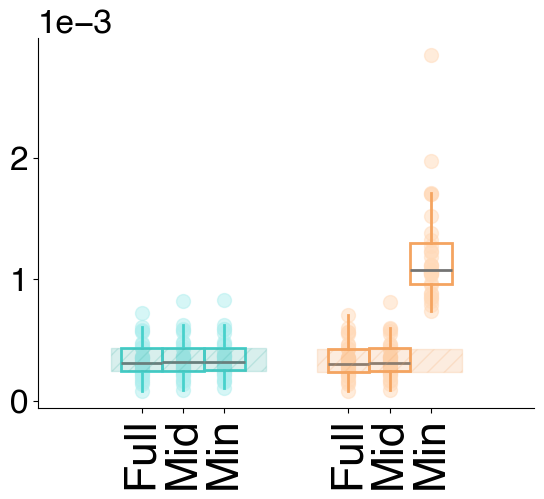

In [456]:
y_data = np.array(PrecFull_SBI)
g_pos = np.array([1])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']
fig,ax = plt.subplots()
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

colors = ['sandybrown']
colors2 = ['peachpuff']
y_data = np.array(PrecFull_NLLS)
g_pos = np.array([2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

x = np.arange(1.85,2.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 77)
plt.fill_between(x,y1,y2,color=WLSFit,zorder=10,alpha=0.2,hatch='//')

x = np.arange(0.85,1.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 77)
plt.fill_between(x,y1,y2,color=SBIFit,zorder=10,alpha=0.2,hatch='//')

plt.xticks([1,1.2,1.4,2,2.2,2.4],['Full','Mid','Min','Full','Mid','Min'],fontsize=32,rotation=90)
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
plt.yticks(fontsize=24)
if Save: plt.savefig(FigLoc+'DTI_MD_Prec.pdf',format='pdf',bbox_inches='tight',transparent=True)

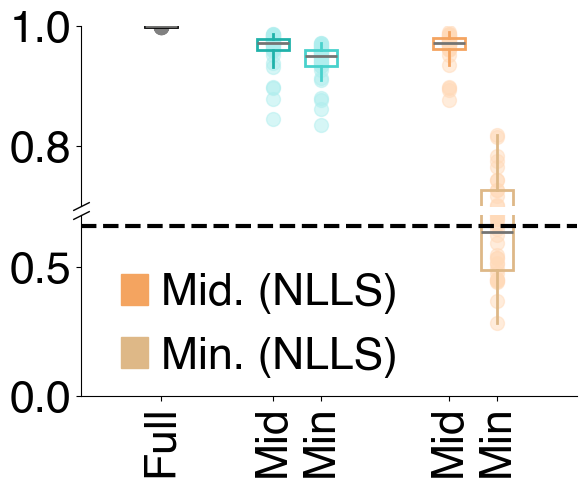

In [461]:
fig, (ax1, ax2) = plt.subplots(2, 1)#, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# Plotting on ax1
plt.sca(ax1)
y_data = np.array(SSIMFulls)
g_pos = np.array([1])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(SSIM20)
g_pos = np.array([1.7])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True,scatter_alpha=0.5)

y_data = np.array(SSIM7)
g_pos = np.array([2])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(SSIM20NL)
g_pos = np.array([2.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.set_ylim(.7, 1.)  # outliers only
ax2.set_ylim(0, .7)  # most of the data

ax1.set_xticks([]) 
ax2.set_xticks([]) 
plt.yticks(fontsize=32)
plt.sca(ax2)
plt.yticks(fontsize=32)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

ax2.set_xlim(ax1.get_xlim())
ax2.axhline(0.66, lw=3, ls='--', c='k')
ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])
ax2.set_xticklabels(['Full', 'Mid', 'Min', 'Mid', 'Min'], fontsize=32, rotation=90)

ax2.legend(
    handles=[leg_patch1,leg_patch2],
    loc='upper left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor= (-0.0,0.9))
if Save: plt.savefig(FigLoc+'DTI_MD_SSIMErr.pdf',format='pdf',bbox_inches='tight',transparent=True)

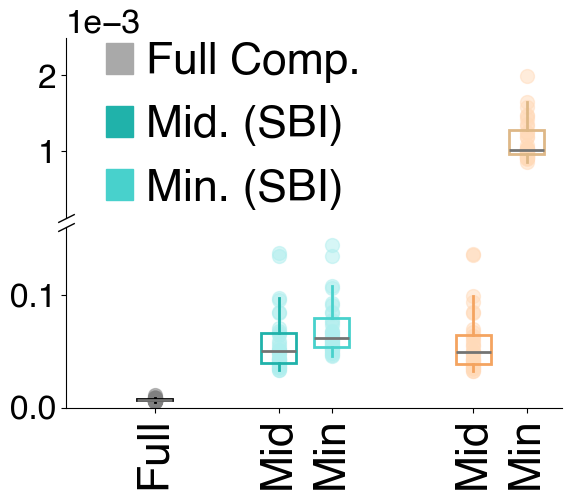

In [402]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.05)



y_data = np.array(AccM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

ax1.set_ylim(0.0001, 2.5e-3)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(AccMFulls)
g_pos = np.array([1])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20)
g_pos = np.array([1.7])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM7)
g_pos = np.array([2])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20NL)
g_pos = np.array([2.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
plt.yticks(fontsize=24)

ax2.set_ylim(0, 0.00016)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
ax2.yaxis.set_ticks(np.arange(0, 0.00018, 0.0001))

# Common x-ticks
ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])
ax2.set_xticklabels(['Full', 'Mid', 'Min', 'Mid', 'Min'], fontsize=32, rotation=90)

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

ax1.set_xlim(ax2.get_xlim())

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2

# Show plot
if Save:
    plt.savefig(FigLoc + 'DTIHCP_Acc_MD.pdf', format='PDF', transparent=True, bbox_inches='tight')

ax1.legend(
    handles=[leg_patch5,leg_patch3,leg_patch4],
    loc='upper left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor=(0,1.2))
plt.show()

In [375]:
image_path

'../Figures/'

In [388]:
AccM7 = []
for i in range(32):
    M7 = FAMinArr[i]
    MF = FAFullArr[i]
    Ma = Masks[i]
    AccM7.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20 = []
for i in range(32):
    M7 = FAMidArr[i]
    MF = FAFullArr[i]
    Ma = Masks[i]
    AccM20.append(np.mean(np.abs(M7-MF)[Ma]))

AccMFulls = []
for i in range(32):
    M7 = FAFullArr[i]
    MF = FAFullNLArr[i]
    Ma = Masks[i]
    AccMFulls.append(np.mean(np.abs(M7-MF)[Ma]))

AccM7NL = []
for i in range(32):
    M7 = FA7NLArr[i]
    MF = FAFullNLArr[i]
    Ma = Masks[i]
    AccM7NL.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20NL = []
for i in range(32):
    M7 = FA20NLArr[i]
    MF = FAFullNLArr[i]
    Ma = Masks[i]
    AccM20NL.append(np.mean(np.abs(M7-MF)[Ma]))

SSIM7 = []
for i in range(32):
    NS1 = FAMinArr[i]
    NS2 = FAFullArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM7.append(result)

SSIM20 = []
for i in range(32):
    NS1 = FAMidArr[i]
    NS2 = FAFullArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM20.append(result)
    
SSIMFulls = []
for i in range(32):
    NS1 = FAFullArr[i]
    NS2 = FAFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIMFulls.append(result)

SSIM7NL = []
for i in range(32):
    NS1 = FA7NLArr[i]
    NS2 = FAFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM7NL.append(result)

SSIM20NL = []
for i in range(32):
    NS1 = FA20NLArr[i]
    NS2 = FAFullNLArr[i]
    Ma = Masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7)
    SSIM20NL.append(result)


In [389]:
Prec7_SBI = []
Prec20_SBI = []
PrecFull_SBI = []

Prec7_NLLS = []
Prec20_NLLS = []
PrecFull_NLLS = []
for i in range(32):
    Prec7_SBI.append(np.std(FAMinArr[i][WMs[i]]))
    Prec20_SBI.append(np.std(FAMidArr[i][WMs[i]]))
    PrecFull_SBI.append(np.std(FAFullArr[i][WMs[i]]))

    Prec7_NLLS.append(np.std(FA7NLArr[i][WMs[i]]))
    Prec20_NLLS.append(np.std(FA20NLArr[i][WMs[i]]))
    PrecFull_NLLS.append(np.std(FAFullNLArr[i][WMs[i]]))


/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


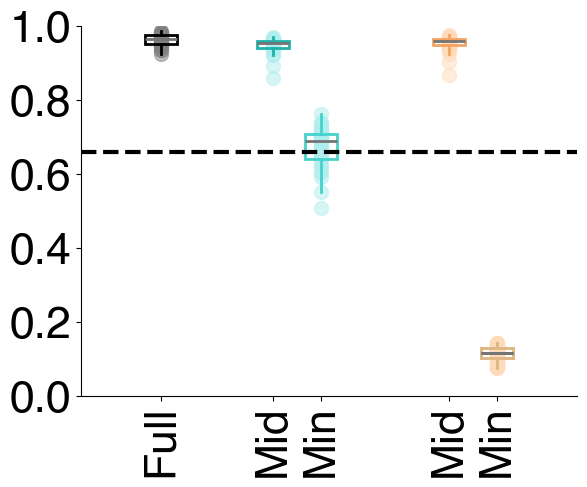

In [390]:
fig,ax = plt.subplots()
y_data = np.array(SSIMFulls)
g_pos = np.array([1])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20)
g_pos = np.array([1.7])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True,scatter_alpha=0.5)

y_data = np.array(SSIM7)
g_pos = np.array([2])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20NL)
g_pos = np.array([2.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

plt.axhline(0.66,lw=3,ls='--',c='k')
plt.yticks(fontsize=32)
plt.ylim([0,1])
ax2.legend(
    handles=[leg_patch3],
    loc='lower left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=2,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)
ax.set_xticks([1,1.7,2,2.8,3.1])
ax.set_xticklabels(['Full', 'Mid', 'Min', 'Mid', 'Min'], fontsize=32, rotation=90)

if Save: plt.savefig(FigLoc+'DTI_FA_SSIMErr.pdf',format='pdf',bbox_inches='tight',transparent=True)

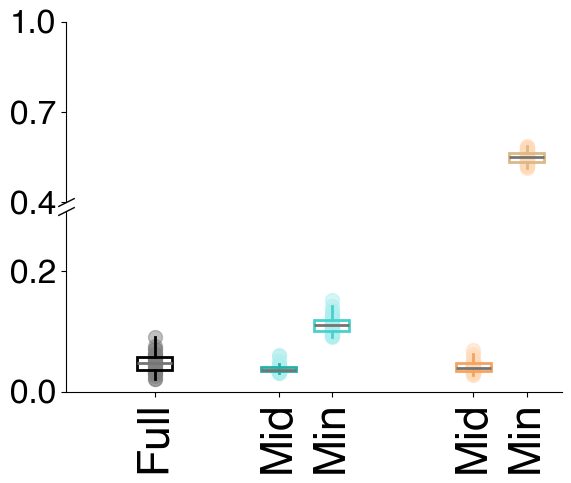

In [397]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.05)



y_data = np.array(AccM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(AccMFulls)
g_pos = np.array([1])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20)
g_pos = np.array([1.7])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM7)
g_pos = np.array([2])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20NL)
g_pos = np.array([2.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
ax1.set_ylim(0.4, 1)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
ax1.yaxis.set_ticks([0.4,0.7,1])
ax1.set_xticks([])

plt.yticks(fontsize=24)

ax2.set_ylim(0.0,0.3)
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax2.yaxis.set_ticks(np.arange(0, 0.0001, 0.00004))

# Common x-ticks
#ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])
ax2.set_xticklabels(['Full', 'Mid', 'Min', 'Mid', 'Min'], fontsize=32, rotation=90)

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2
ax1.set_xlim(ax2.get_xlim())
# Show plot
if Save:
    plt.savefig(FigLoc + 'DTIHCP_Acc_FA.pdf', format='PDF', transparent=True, bbox_inches='tight')

plt.show()

In [396]:
FigLoc

'../Figures/Fig_3/'

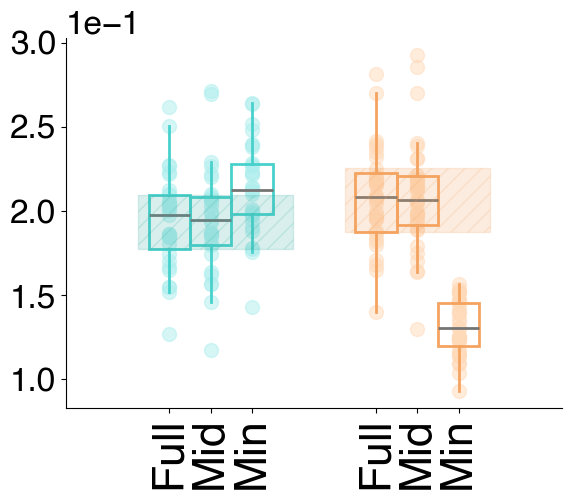

In [392]:
y_data = np.array(PrecFull_SBI)
g_pos = np.array([1])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']
fig,ax = plt.subplots()
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

colors = ['sandybrown']
colors2 = ['peachpuff']
y_data = np.array(PrecFull_NLLS)
g_pos = np.array([2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

x = np.arange(1.85,2.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 77)
plt.fill_between(x,y1,y2,color=WLSFit,zorder=10,alpha=0.2,hatch='//')

x = np.arange(0.85,1.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 75)
plt.fill_between(x,y1,y2,color=SBIFit,zorder=10,alpha=0.2,hatch='//')

plt.xticks([1,1.2,1.4,2,2.2,2.4],['Full','Mid','Min','Full','Mid','Min'],fontsize=32,rotation=90)
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
plt.yticks(fontsize=24)
if Save: plt.savefig(FigLoc+'DTI_FA_Prec.pdf',format='pdf',bbox_inches='tight',transparent=True)

## f

In [1562]:
i=3
fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'

fdwi3 = './HCP_data/Pat'+str(i)+'/diff_3k.nii.gz'
bvalloc3 = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc3 = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

bvalsHCP3 = np.loadtxt(bvalloc3)
bvecsHCP3 = np.loadtxt(bvecloc3)
gtabHCP3 = gradient_table(bvalsHCP3, bvecsHCP3)

gtabExt  = gradient_table(np.hstack((bvalsHCP,bvalsHCP3)), np.vstack((bvecsHCP,bvecsHCP3)))

data, affine, img = load_nifti(fdwi, return_img=True)
data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=4,
                             numpass=1, autocrop=False, dilate=2)
_, mask2 = median_otsu(data, vol_idx=range(10, 50), median_radius=4,
                             numpass=1, autocrop=True, dilate=2)


data3, affine, img = load_nifti(fdwi3, return_img=True)
data3, affine = reslice(data3, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
# Get the indices of True values
true_indices = np.argwhere(mask)

# Determine the minimum and maximum indices along each dimension
min_coords = true_indices.min(axis=0)
max_coords = true_indices.max(axis=0)

maskdata  = maskdata[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]
axial_middle = maskdata.shape[2] // 2
maskdata3 = data3[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]

TestData = np.concatenate([maskdata[:, :, axial_middle, :],maskdata3[:, :, axial_middle, :]],axis=-1)
TestData4D = np.concatenate([maskdata,maskdata3],axis=-1)

In [499]:
np.random.seed(1)
torch.manual_seed(1)
if os.path.exists(f"{network_path}/DKIHCPFull.pickle"):
    with open(f"{network_path}/DKIHCPFull.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    torch.manual_seed(1)
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(13000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(13000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(26000))   
    
    
    DT = np.vstack([DT2,DT3,DT5])
    KT = np.vstack([KT2,KT3,KT5])
    
    S0Dist = BoxUniform(low=torch.tensor([lower_S0]), high=torch.tensor([upper_S0]))
    
    S0 = S0Dist.sample([4*13000])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gtabExt.bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm.tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gtabExt,S0[i],np.random.rand()*20 + 30)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>4*np.array(S0[i])).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT,S0])
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posteriorFull = inference.build_posterior(density_estimator)
    
    if not os.path.exists(f"{network_path}/DKIHCPFull.pickle"):
        with open(f"{network_path}/DKIHCPFull.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)

In [501]:
# Compute the mask where the sum is not zero
mask = np.sum(TestData4D[:,:,axial_middle,:], axis=-1) != 0

# Get the indices where mask is True
indices = np.argwhere(mask)

# Define the function for optimization
def optimize_pixel(i, j):
    torch.manual_seed(10)  # If required
    posterior_samples_1 = posteriorFull.sample((500,), x=TestData4D[i,j,axial_middle, :],show_progress_bars=False)
    return i, j, posterior_samples_1.mean(axis=0)

# Initialize NoiseEst with the appropriate shape
ArrShape = mask.shape

# Use joblib to parallelize the optimization tasks
results = Parallel(n_jobs=-1)(
    delayed(optimize_pixel)(i, j) for i, j in tqdm(indices)
)

  0%|          | 0/4216 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:584: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715184454275/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  x = atleast_2d(torch.as_tensor(x, dtype=float32))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:584: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before c

In [502]:
NoiseEst = np.zeros([62, 68 ,22])
for i, j, x in results:
    NoiseEst[i, j] = x

In [503]:
NoiseEst2 =  np.zeros_like(NoiseEst)
for i in range(62):
    for j in range(68):    
        NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,6:]])

In [504]:
MK_SBIFull  = np.zeros([62, 68])
AK_SBIFull  = np.zeros([62, 68])
RK_SBIFull  = np.zeros([62, 68])
MKT_SBIFull = np.zeros([62, 68])
KFA_SBIFull = np.zeros([62, 68])
for i in tqdm(range(62)):
    for j in range(68):
        Metrics = DKIMetrics(NoiseEst2[i,j][:6],NoiseEst2[i,j][6:21])
        MK_SBIFull[i,j] = Metrics[0]
        AK_SBIFull[i,j] = Metrics[1]
        RK_SBIFull[i,j] = Metrics[2]
        MKT_SBIFull[i,j] = Metrics[3]
        KFA_SBIFull[i,j] = Metrics[4]

  0%|          | 0/62 [00:00<?, ?it/s]

In [505]:
KFA_SBIFull[np.isnan(KFA_SBIFull)] = 1

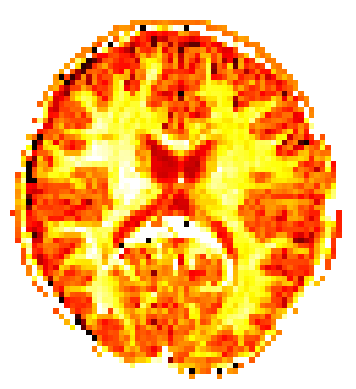

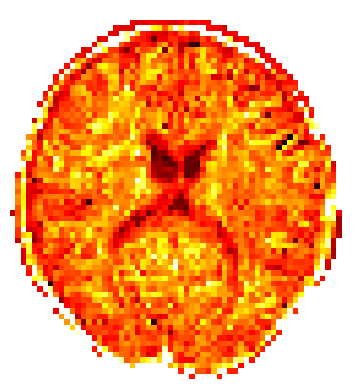

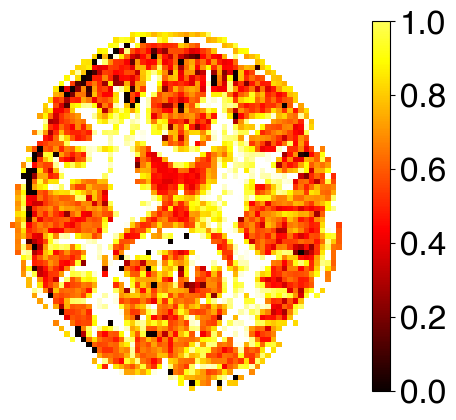

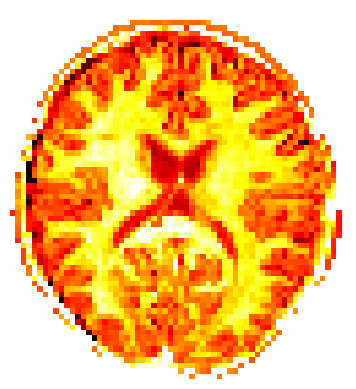

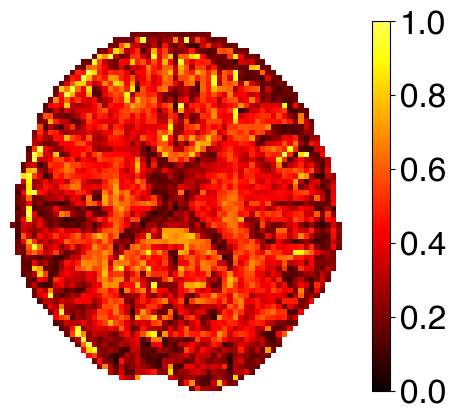

In [506]:
tnorm = TwoSlopeNorm(vmin=-0,vcenter = 0.6,vmax=1.2)
temp = np.copy(MK_SBIFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKSBIFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(AK_SBIFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'AKSBIFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(RK_SBIFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'RKSBIFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
temp = np.copy(MKT_SBIFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKTSBIFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(KFA_SBIFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'KFASBIFull.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [448]:
dkimodelNL = dki.DiffusionKurtosisModel(gtabExt,fit_method='NLLS')
dkifitNL = dkimodelNL.fit(TestData[:,:,:])
MK_NLFull  = np.zeros([62, 68])
AK_NLFull  = np.zeros([62, 68])
RK_NLFull  = np.zeros([62, 68])
MKT_NLFull = np.zeros([62, 68])
KFA_NLFull = np.zeros([62, 68])
for i in range(62):
    for j in range(68):
        Metrics = DKIMetrics(dkifitNL[i,j].lower_triangular(),dkifitNL[i,j].kt)
        MK_NLFull[i,j] = Metrics[0]
        AK_NLFull[i,j] = Metrics[1]
        RK_NLFull[i,j] = Metrics[2]
        MKT_NLFull[i,j] = Metrics[3]
        KFA_NLFull[i,j] = Metrics[4]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))


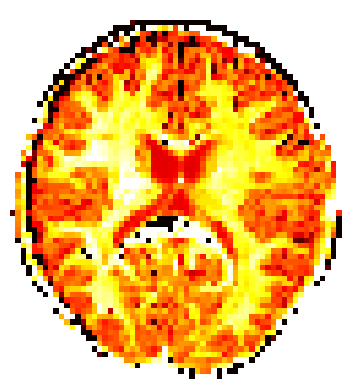

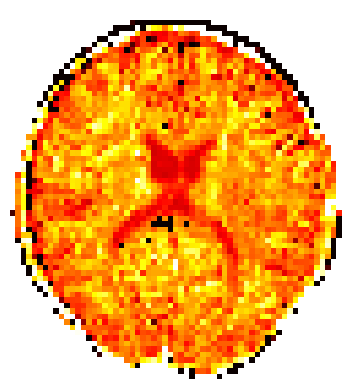

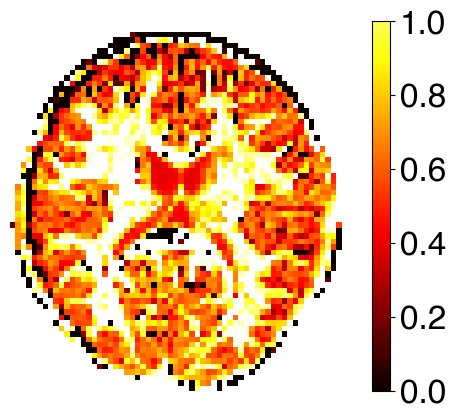

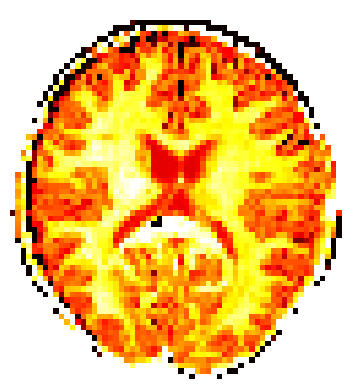

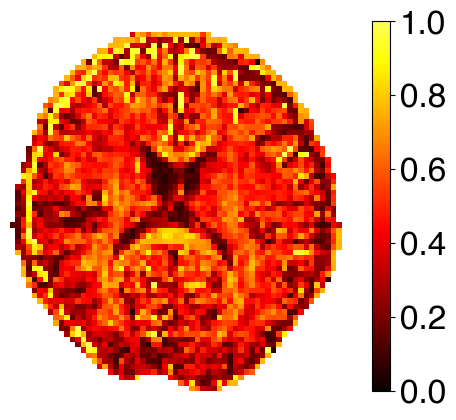

In [449]:
tnorm = TwoSlopeNorm(vmin=-0,vcenter = 0.6,vmax=1.2)
temp = np.copy(MK_NLFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKNLFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(AK_NLFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'AKNLFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(RK_NLFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'RKNLFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
temp = np.copy(MKT_NLFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKTNLFull.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(KFA_NLFull)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'KFANLFull.pdf',format='pdf',bbox_inches='tight',transparent=True)

## g

In [1563]:
i=3
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(5):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

selected_indices7 = [0]+selected_indices

bvalsHCP7_1 = bvalsHCP[selected_indices7]
bvecsHCP7_1 = bvecsHCP[selected_indices7]

i=3
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP3 = np.loadtxt(bvalloc)
bvecsHCP3 = np.loadtxt(bvecloc)
gtabHCP3 = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]

temp_bvecs = bvecsHCP3[bvalsHCP3>0]
temp_bvals = bvalsHCP3[bvalsHCP3>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(14):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

bvalsHCP7_3 = temp_bvals[selected_indices]
bvecsHCP7_3 = temp_bvecs[selected_indices]

gtabHCP7 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

true_indx = []
for b in bvecsHCP7_3:
    true_indx.append(np.linalg.norm(b-bvecsHCP3,axis=1).argmin())
true_indx = selected_indices7+[t+69 for t in true_indx]
gtabHCP7 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

In [1564]:
np.random.seed(1)
torch.manual_seed(1)
if os.path.exists(f"{network_path}/DKIHCPMin.pickle"):
    with open(f"{network_path}/DKIHCPMin.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    DT = []
    KT = []
    S0 = []

    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(3*13000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(3*13000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(3*26000))   
    
    
    DT = np.vstack([DT2,DT3,DT5])
    KT = np.vstack([KT2,KT3,KT5])
    
    S0Dist = BoxUniform(low=torch.tensor([lower_S0]), high=torch.tensor([upper_S0]))
    
    S0 = S0Dist.sample([3*52000])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gtabHCP7.bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm.tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gtabHCP7,S0[i],np.random.rand()*20 + 30)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>4*np.array(S0[i])).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT,S0])
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posteriorFull = inference.build_posterior(density_estimator)
    
    if not os.path.exists(f"{network_path}/DKIHCPMinA2.pickle"):
        with open(f"{network_path}/DKIHCPMinA2.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)


In [1565]:
# Compute the mask where the sum is not zero
mask = np.sum(TestData4D[:,:,axial_middle,:], axis=-1) != 0

# Get the indices where mask is True
indices = np.argwhere(mask)

# Define the function for optimization
def optimize_pixel(i, j):
    torch.manual_seed(10)  # If required
    posterior_samples_1 = posteriorFull.sample((500,), x=TestData4D[i,j,axial_middle, true_indx],show_progress_bars=False)
    return i, j, posterior_samples_1.mean(axis=0)

# Initialize NoiseEst with the appropriate shape
ArrShape = mask.shape

# Use joblib to parallelize the optimization tasks
results = Parallel(n_jobs=-1)(
    delayed(optimize_pixel)(i, j) for i, j in tqdm(indices)
)

  0%|          | 0/4216 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [1566]:
ArrShape

(62, 68)

In [1567]:
NoiseEst7 = np.zeros([62, 68 ,22])
for i, j, x in results:
    NoiseEst7[i, j] = x

In [1568]:
NoiseEst2 =  np.zeros_like(NoiseEst)
for i in range(62):
    for j in range(68):    
        NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst7[i,j]))),NoiseEst7[i,j,6:]])

In [1569]:
MK_SBI7  = np.zeros([62, 68])
AK_SBI7  = np.zeros([62, 68])
RK_SBI7  = np.zeros([62, 68])
MKT_SBI7 = np.zeros([62, 68])
KFA_SBI7 = np.zeros([62, 68])
for i in tqdm(range(62)):
    for j in range(68):
        Metrics = DKIMetrics(NoiseEst2[i,j][:6],NoiseEst2[i,j][6:21])
        MK_SBI7[i,j] = Metrics[0]
        AK_SBI7[i,j] = Metrics[1]
        RK_SBI7[i,j] = Metrics[2]
        MKT_SBI7[i,j] = Metrics[3]
        KFA_SBI7[i,j] = Metrics[4]

  0%|          | 0/62 [00:00<?, ?it/s]

In [1570]:
KFA_SBI7[np.isnan(KFA_SBI7)] = 1

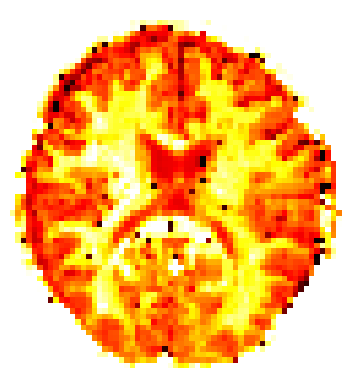

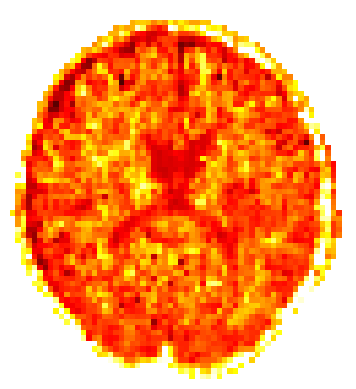

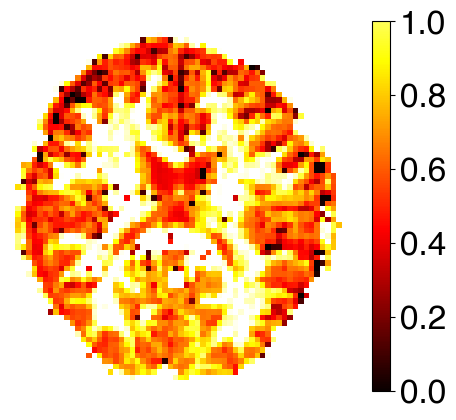

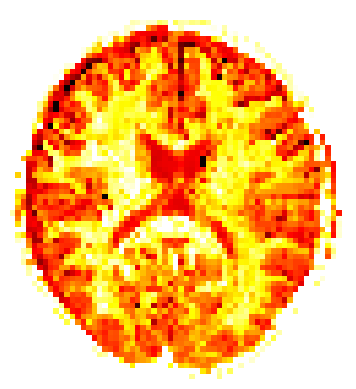

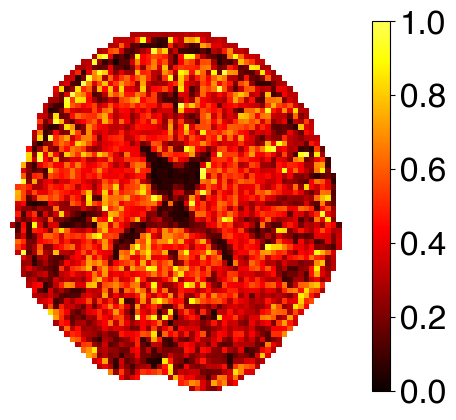

In [1573]:
tnorm = TwoSlopeNorm(vmin=-0,vcenter = 0.6,vmax=1.2)
temp = np.copy(MK_SBI7)
temp = gaussian_filter(temp, sigma=0.5)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKSBI7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(AK_SBI7)
temp = gaussian_filter(temp, sigma=0.5)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'AKSBI7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(RK_SBI7)
temp = gaussian_filter(temp, sigma=0.5)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'RKSBI7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
temp = np.copy(MKT_SBI7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKTSBI7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(KFA_SBI7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'KFASBI7.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [491]:
dkimodelNL = dki.DiffusionKurtosisModel(gtabHCP7,fit_method='NLLS')
dkifitNL = dkimodelNL.fit(TestData[:,:,true_indx])
MK_NL7  = np.zeros([62, 68])
AK_NL7  = np.zeros([62, 68])
RK_NL7 = np.zeros([62, 68])
MKT_NL7 = np.zeros([62, 68])
KFA_NL7 = np.zeros([62, 68])
for i in range(62):
    for j in range(68):
        Metrics = DKIMetrics(dkifitNL[i,j].lower_triangular(),dkifitNL[i,j].kt)
        MK_NL7[i,j] = Metrics[0]
        AK_NL7[i,j] = Metrics[1]
        RK_NL7[i,j] = Metrics[2]
        MKT_NL7[i,j] = Metrics[3]
        KFA_NL7[i,j] = Metrics[4]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1826: RuntimeWarning: divide by zero encountered in divide
  params[vox, 12:] = this_param[6:-1] / md2
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dki.py:2506: RuntimeWarning: invalid value encountered in multiply
  Wre = Wre + multiplyB * kt[..., ind_ele[key]]
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:267: RuntimeWarning: invalid value encountered in subtract
  (Wxxxx - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:268: RuntimeWarning: invalid value encountered in subtract
  + (Wyyyy - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:269: RuntimeWarning: invalid value encountered in subtract
  + (Wzzzz - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:271: RuntimeWarning: invalid 

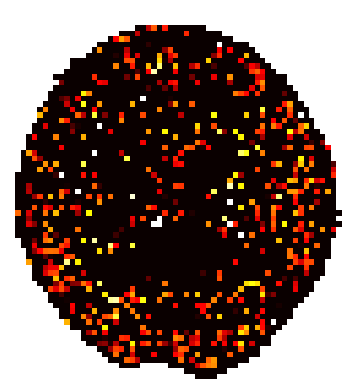

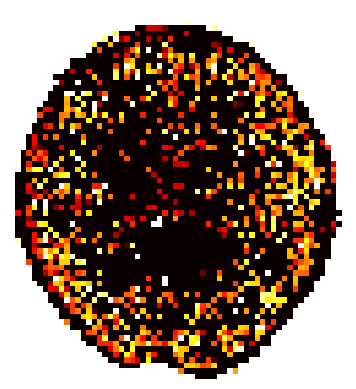

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x3e5709e40>
Traceback (most recent call last):
  File "/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/weakref.py", line 60, in _cb
    callback(self)
  File "/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/matplotlib/cbook.py", line 248, in _remove_proxy
    del self.callbacks[signal][cid]
        ~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'changed'


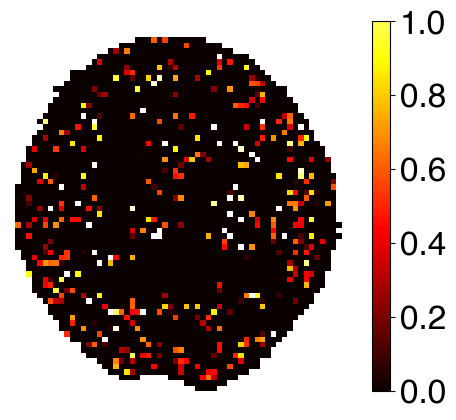

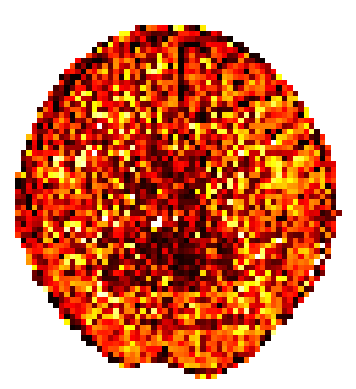

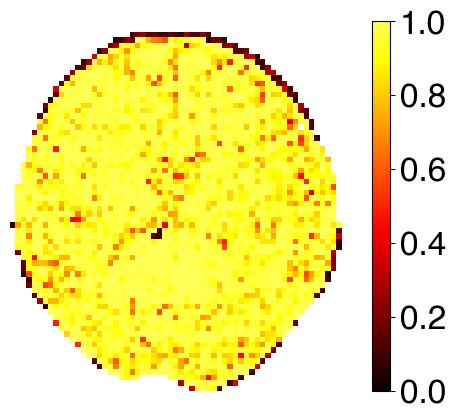

In [493]:
tnorm = TwoSlopeNorm(vmin=-0,vcenter = 0.6,vmax=1.2)
temp = np.copy(MK_NL7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKNL7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(AK_NL7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'AKNL7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(RK_NL7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'RKNL7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
temp = np.copy(MKT_NL7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
if Save: plt.savefig(FigLoc+'MKTNL7.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

temp = np.copy(KFA_NL7)
temp[~cutout] = math.nan
plt.imshow(temp.T,norm=tnorm,cmap='hot')
plt.axis('off')
cbar = plt.colorbar(fraction=0.032, pad=0.04)
cbar.ax.set_ylim(0,1)
if Save: plt.savefig(FigLoc+'KFANL7.pdf',format='pdf',bbox_inches='tight',transparent=True)

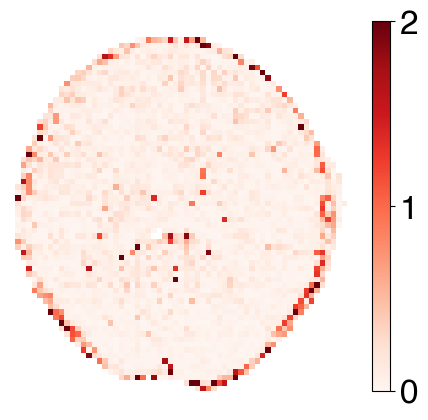

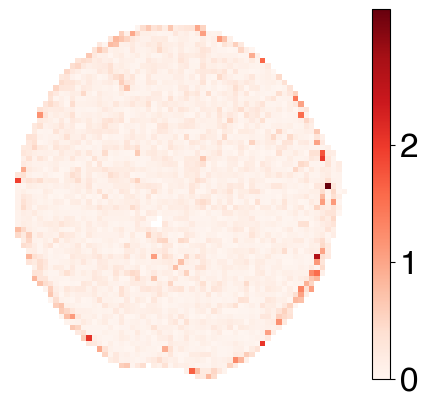

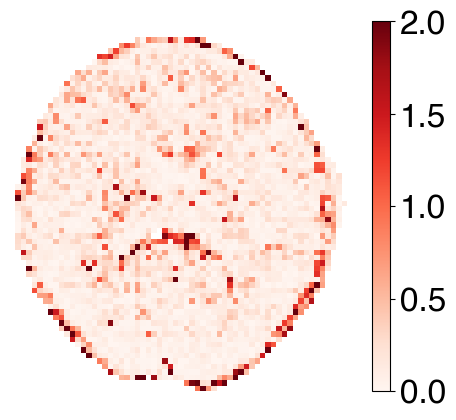

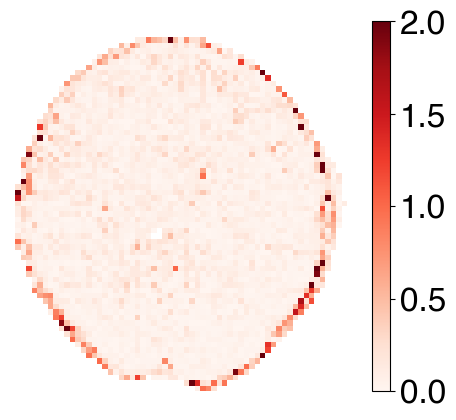

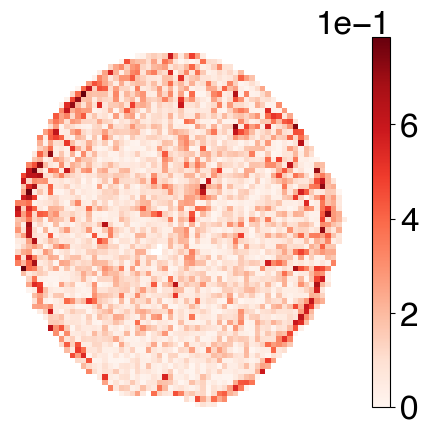

In [507]:
ticks = [0,1,2]
data = np.abs((MK_SBIFull-MK_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar(ticks=ticks)
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'MKDiffSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()


data = np.abs((AK_SBIFull-AK_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(data)/2, vmax=np.nanmax(data))
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar(ticks=ticks)
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'AKDiffSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

data = np.abs((RK_SBIFull-RK_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=1,vmax=2)
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'RKDiffSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

ticks = [0,1,2]
data = np.abs((MKT_SBIFull-MKT_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()#ticks=ticks)
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'MKTDiffSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

data = np.abs((KFA_SBIFull-KFA_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(data)/2, vmax=np.nanmax(data))
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'KFADiffSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

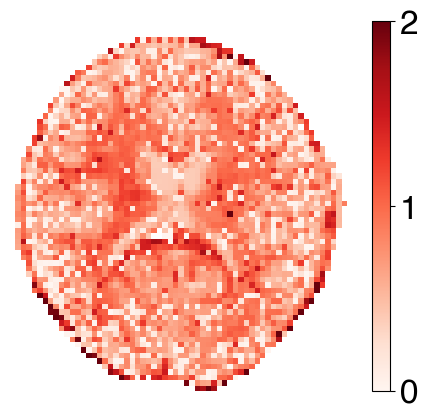

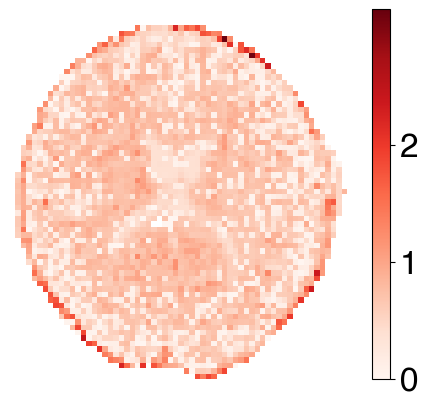

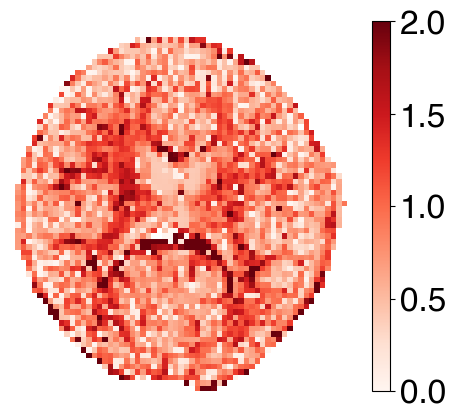

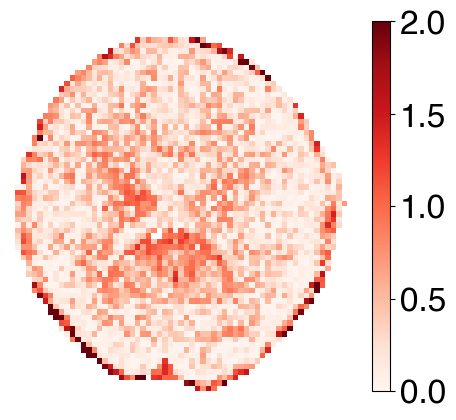

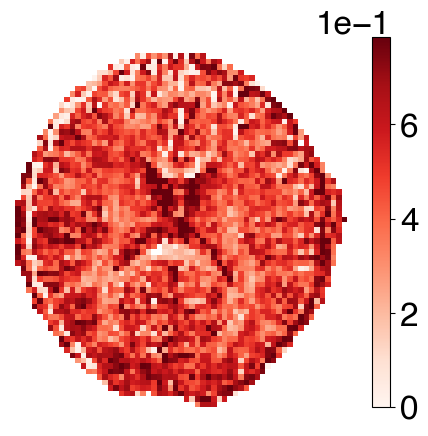

In [518]:
data = np.abs((MK_NLFull-MK_NL7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
plt.imshow(data,cmap='Reds',vmin=0,vmax=2)
plt.axis('off')
cbar = plt.colorbar(ticks=[0,1,2])
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'MKDiffWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

dat = np.abs((AK_SBIFull-AK_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(dat)/2, vmax=np.nanmax(dat))
data = np.abs((AK_NLFull-AK_NL7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar(ticks=ticks)
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'AKDiffWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

norm = TwoSlopeNorm(vmin=0, vcenter=1,vmax=2)
data = np.abs((RK_NLFull-RK_NL7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
#ticks = [0, np.round(np.max(data),10)]  #Adjust the number of ticks as needed
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'RKDiffWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

data = np.abs((MKT_NLFull-MKT_NL7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'MKTDiffWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

dat = np.abs((KFA_SBIFull-KFA_SBI7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
norm = TwoSlopeNorm(vmin=0, vcenter=np.nanmax(dat)/2, vmax=np.nanmax(dat))
data = np.abs((KFA_NLFull-KFA_NL7)*mask2[:,:,axial_middle]).T
data[~mask2[:,:,axial_middle].T] = np.nan
ticks = [0, np.round(np.max(data),10)]  #Adjust the number of ticks as needed
plt.imshow(data,cmap='Reds',norm=norm)
plt.axis('off')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
if Save: plt.savefig(FigLoc+'KFADiffWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)

## h

In [1105]:
i = 1
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(5):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

selected_indices7 = [0]+selected_indices

bvalsHCP7_1 = bvalsHCP[selected_indices7]
bvecsHCP7_1 = bvecsHCP[selected_indices7]

bvalloc = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP3 = np.loadtxt(bvalloc)
bvecsHCP3 = np.loadtxt(bvecloc)
gtabHCP3 = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]

temp_bvecs = bvecsHCP3[bvalsHCP3>0]
temp_bvals = bvalsHCP3[bvalsHCP3>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(14):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

bvalsHCP7_3 = temp_bvals[selected_indices]
bvecsHCP7_3 = temp_bvecs[selected_indices]

gtabHCP7 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

true_indx = []
for b in bvecsHCP7_3:
    true_indx.append(np.linalg.norm(b-bvecsHCP3,axis=1).argmin())
selected_indices7 = selected_indices7+[t+69 for t in true_indx]



In [1106]:
i = 1
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))

temp_bvecs = bvecsHCP[bvalsHCP>0]
temp_bvals = bvalsHCP[bvalsHCP>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(18):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

temp = selected_indices

bvalsHCP7_1 = np.insert(temp_bvals[temp],0,0)
bvecsHCP7_1 = np.insert(temp_bvecs[temp],0,[0,0,0],axis=0)

bvalloc = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP3 = np.loadtxt(bvalloc)
bvecsHCP3 = np.loadtxt(bvecloc)
gtabHCP3 = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]

temp_bvecs = bvecsHCP3[bvalsHCP3>0]
temp_bvals = bvalsHCP3[bvalsHCP3>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(27):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

bvalsHCP7_3 = temp_bvals[selected_indices]
bvecsHCP7_3 = temp_bvecs[selected_indices]

gtabHCP20 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

true_indx_one = []
for b in bvecsHCP7_1:
    true_indx_one.append(np.linalg.norm(b-bvecsHCP,axis=1).argmin())
true_indx = []        
for b in bvecsHCP7_3:
    true_indx.append(np.linalg.norm(b-bvecsHCP3,axis=1).argmin())
selected_indices20 = true_indx_one+[t+69 for t in true_indx]

In [1107]:
if os.path.exists(f"{network_path}/DKIMultiHCPFull_300k.pickle"):
    with open(f"{network_path}/DKIMultiHCPFull_300k.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(75000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(75000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(150000))   
    
    DT = np.vstack([DT5,DT2,DT3])
    KT = np.vstack([KT5,KT2,KT3])
    
    S0Dist = BoxUniform(low=torch.tensor([lower_S0]), high=torch.tensor([upper_S0]))
    
    S0 = S0Dist.sample([DT.shape[0]])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    A  = np.random.choice(32,DT.shape[0])
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gTabsF[0].bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm.tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gTabsF[A[i]],S0[i],50)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>4*np.array(S0[i])).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT,S0])
    Obs = np.hstack([Obs,np.expand_dims(A, axis=-1)])
        
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 50)
    posteriorFull = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DKIMultiHCPFull_300k.pickle"):
        with open(f"{network_path}/DKIMultiHCPFull_300k.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)
    import os
    os.system("say 'DKI network done'") # or '\7'

In [1108]:
TD = []
axial_middles = []
masks = []
WMs = []
for kk in tqdm(range(32)):
    fdwi = './HCP_data/Pat'+str(kk+1)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(kk+1)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(kk+1)+'/bvecs_1k.txt'
    
    fdwi3 = './HCP_data/Pat'+str(kk+1)+'/diff_3k.nii.gz'
    bvalloc3 = './HCP_data/Pat'+str(kk+1)+'/bvals_3k.txt'
    bvecloc3 = './HCP_data/Pat'+str(kk+1)+'/bvecs_3k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    bvalsHCP3 = np.loadtxt(bvalloc3)
    bvecsHCP3 = np.loadtxt(bvecloc3)
    gtabHCP3 = gradient_table(bvalsHCP3, bvecsHCP3)
    
    gtabExt  = gradient_table(np.hstack((bvalsHCP,bvalsHCP3)), np.vstack((bvecsHCP,bvecsHCP3)))
    
    data, affine, img = load_nifti(fdwi, return_img=True)
    data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=False, dilate=2)
    _, mask2 = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                                 numpass=1, autocrop=True, dilate=2)
    
    
    data3, affine, img = load_nifti(fdwi3, return_img=True)
    data3, affine = reslice(data3, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
    # Get the indices of True values
    true_indices = np.argwhere(mask)
    
    # Determine the minimum and maximum indices along each dimension
    min_coords = true_indices.min(axis=0)
    max_coords = true_indices.max(axis=0)
    
    maskdata  = maskdata[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]
    axial_middle = maskdata.shape[2] // 2
    maskdata3 = data3[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]
    axial_middles.append(axial_middle)
    TestData = np.concatenate([maskdata[:, :, axial_middle, :],maskdata3[:, :, axial_middle, :]],axis=-1)
    TestData4D = np.concatenate([maskdata,maskdata3],axis=-1)
    TD.append(TestData4D)
    masks.append(mask[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,axial_middle])
    WM, affine, img = load_nifti('./flipped/c2Pat'+str(kk+1)+'_FP.nii', return_img=True)
    WMs.append(np.fliplr(WM[:,:,axial_middle]>0.8))

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:286: RuntimeWarning: invalid value encountered in scalar divide
  KFA = np.sqrt(A / B)


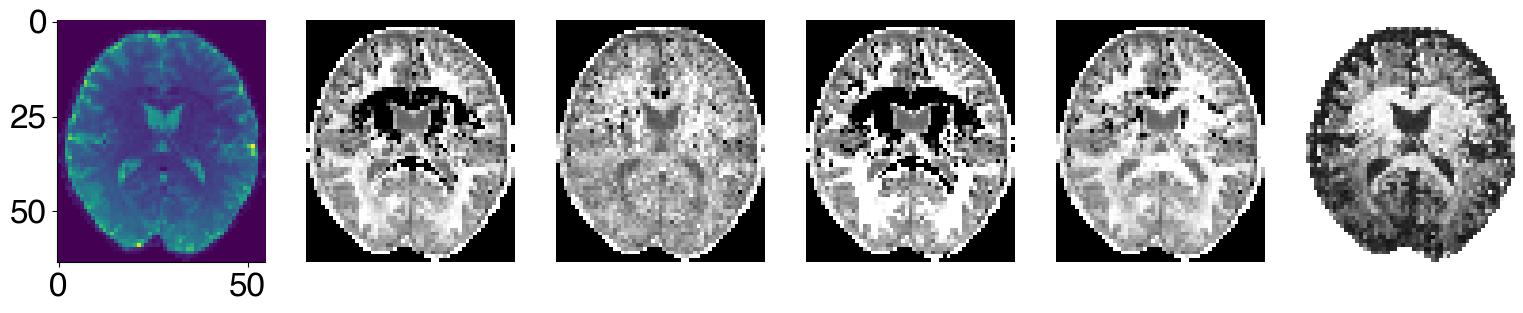

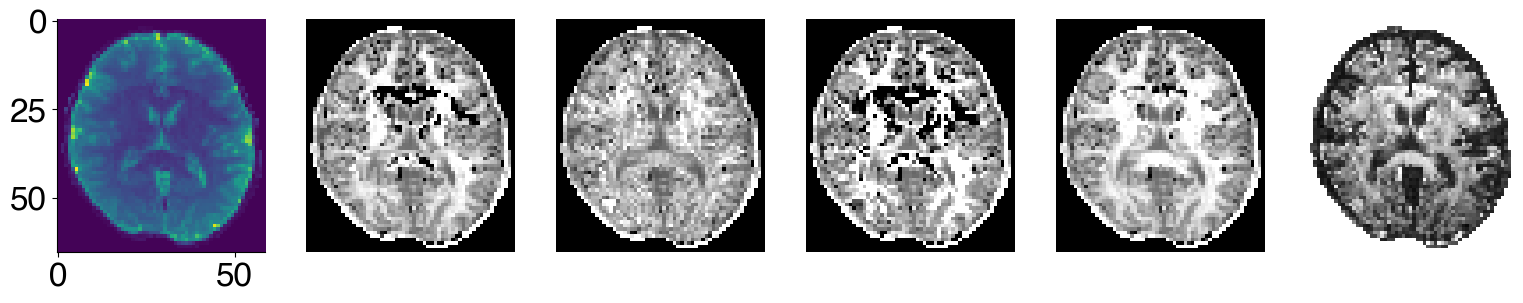

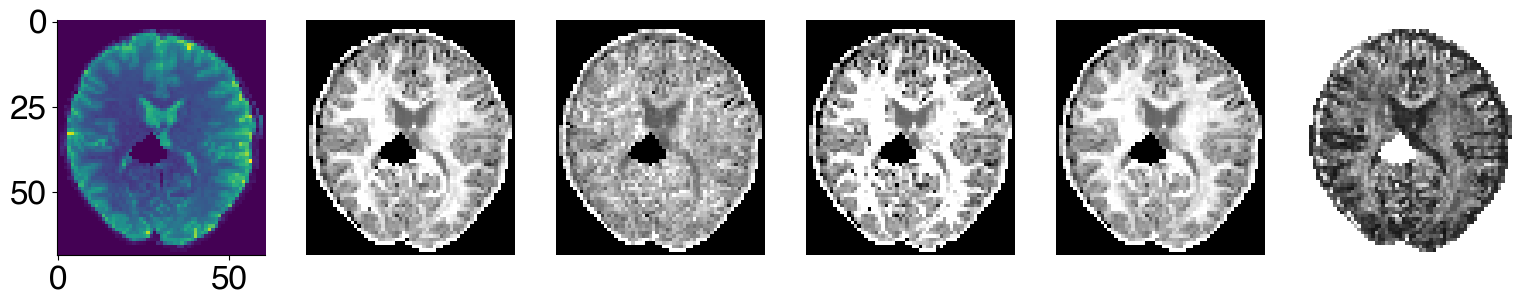

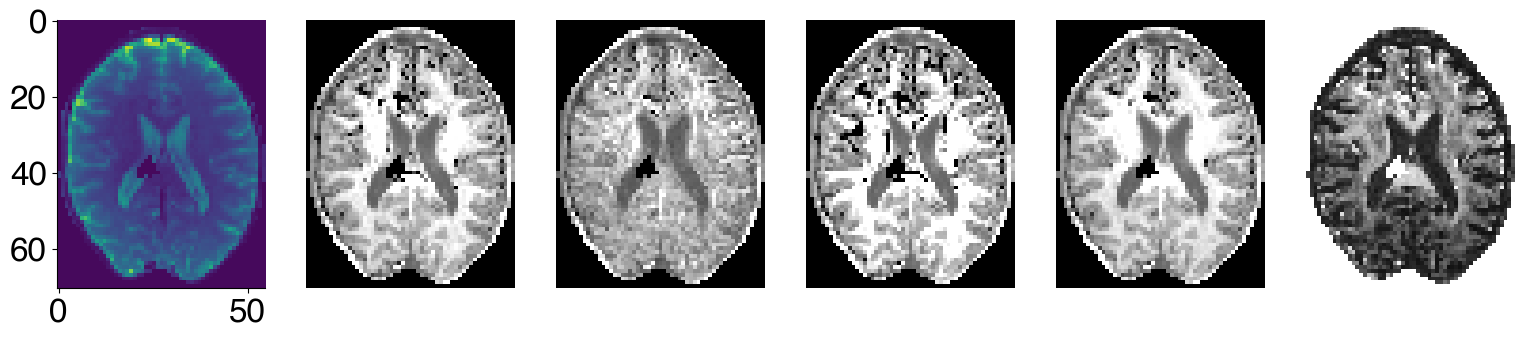

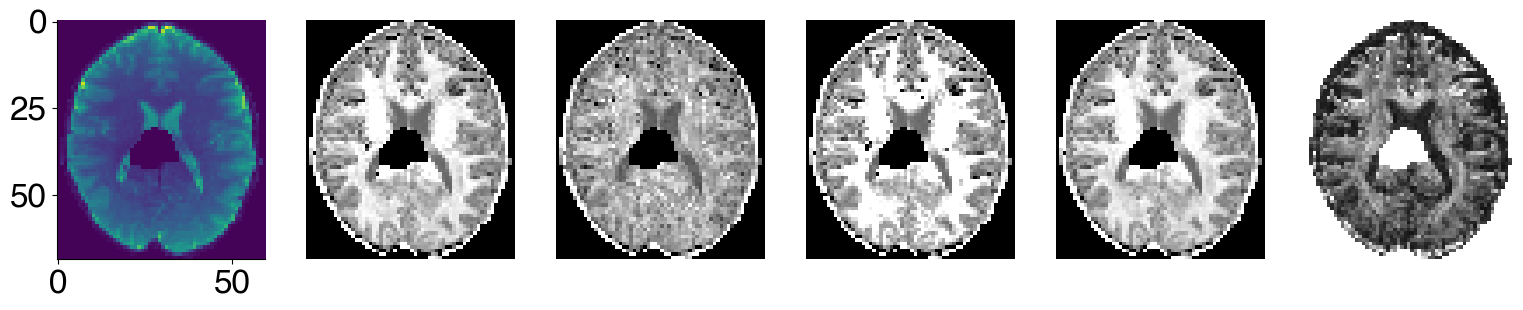

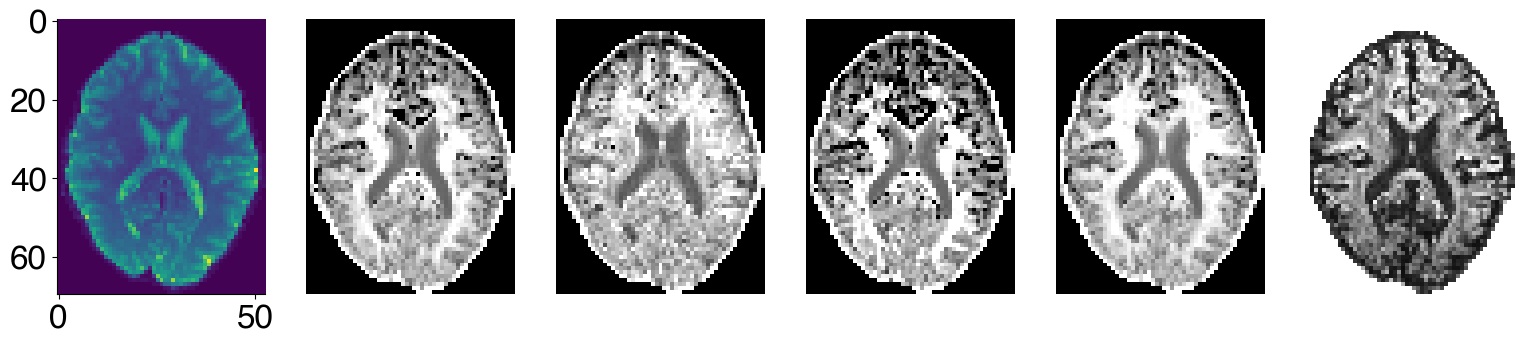

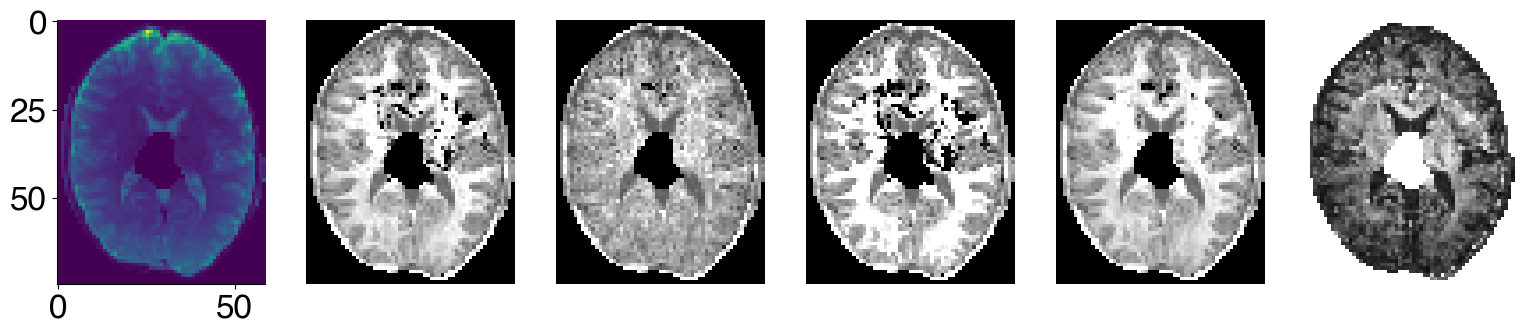

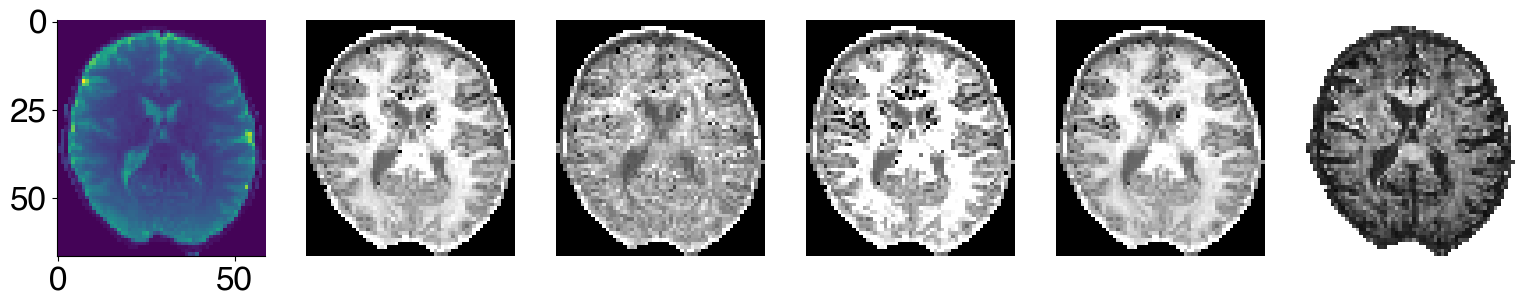

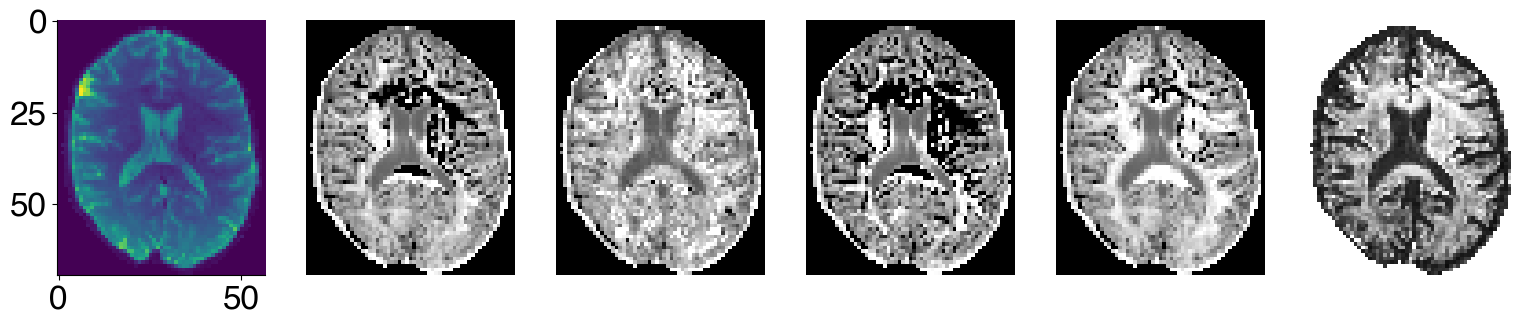

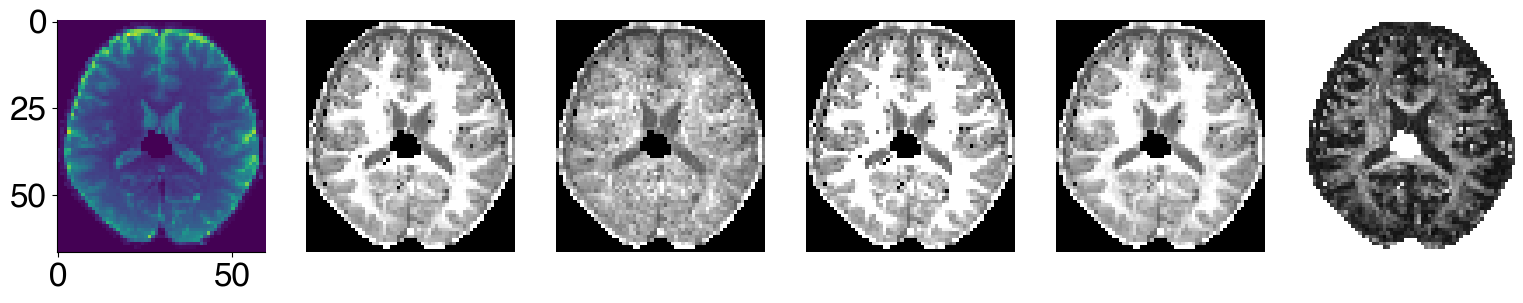

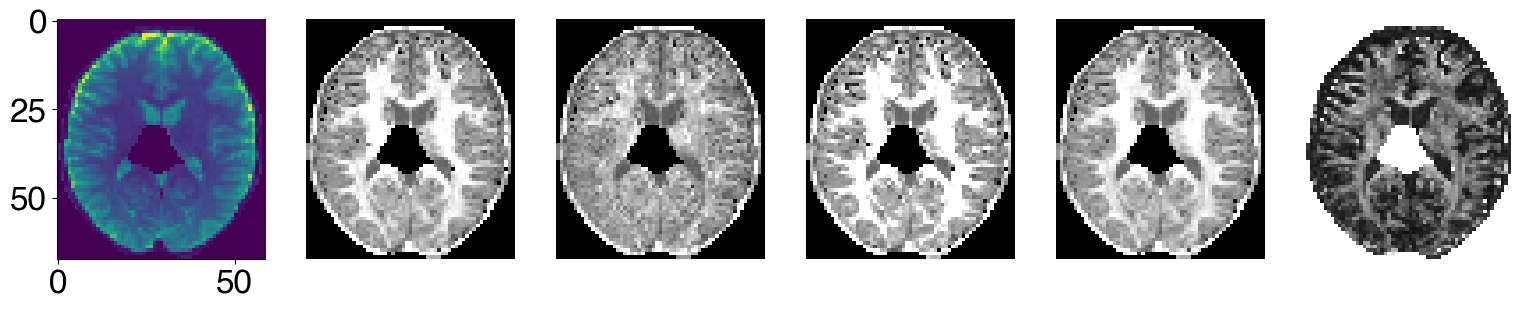

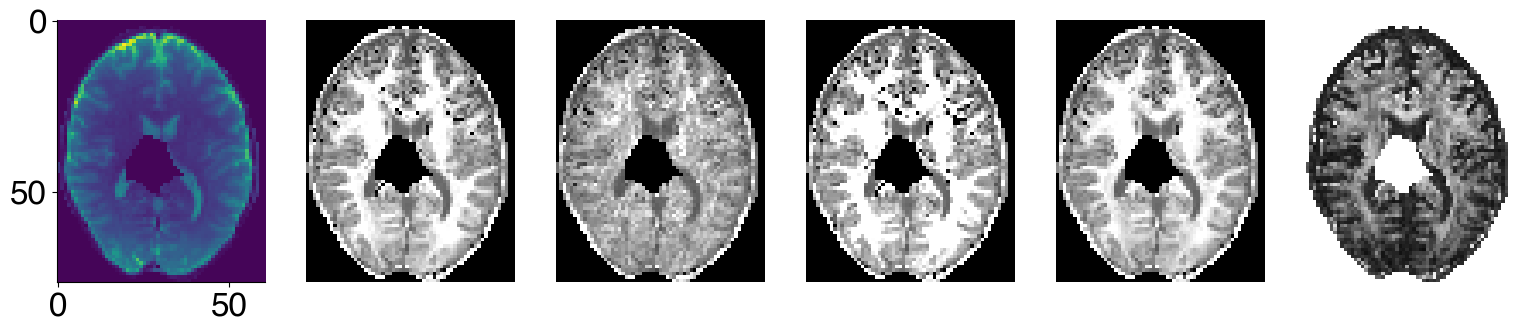

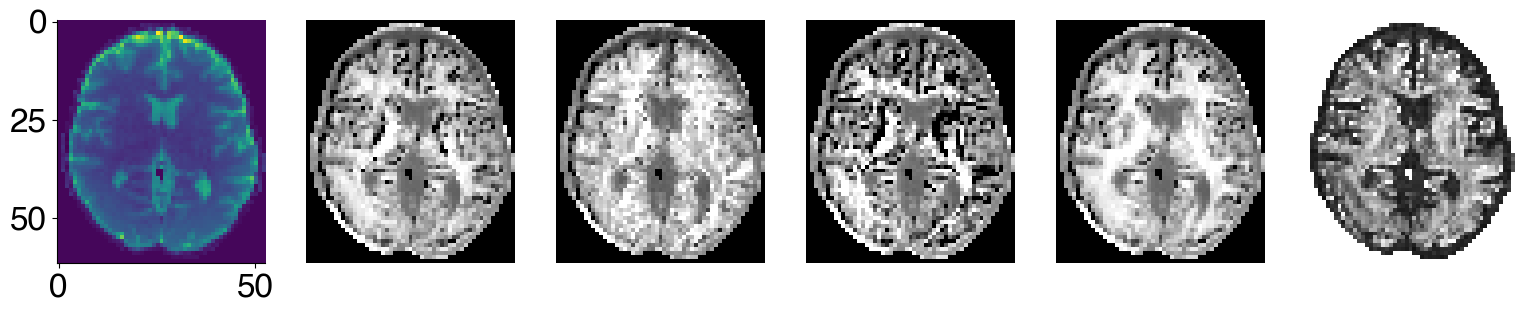

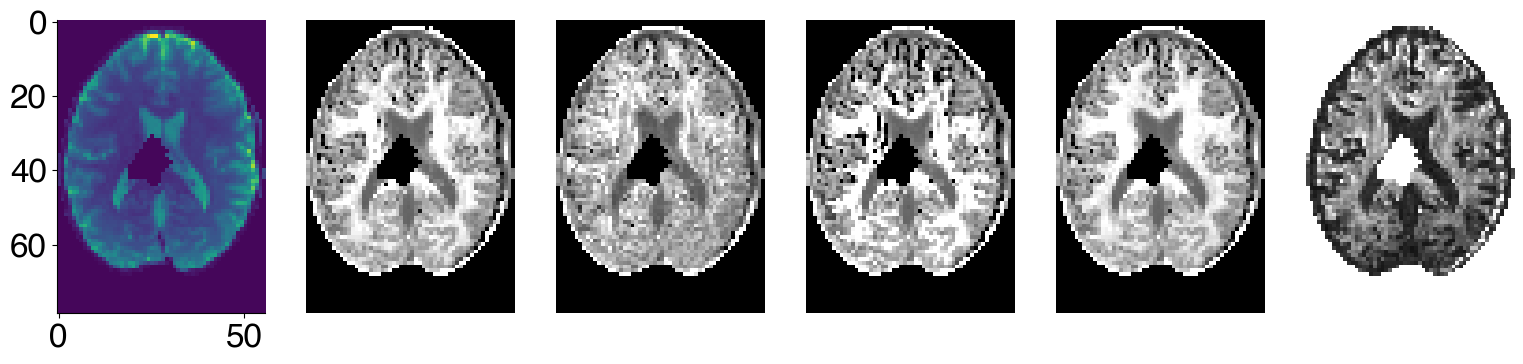

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


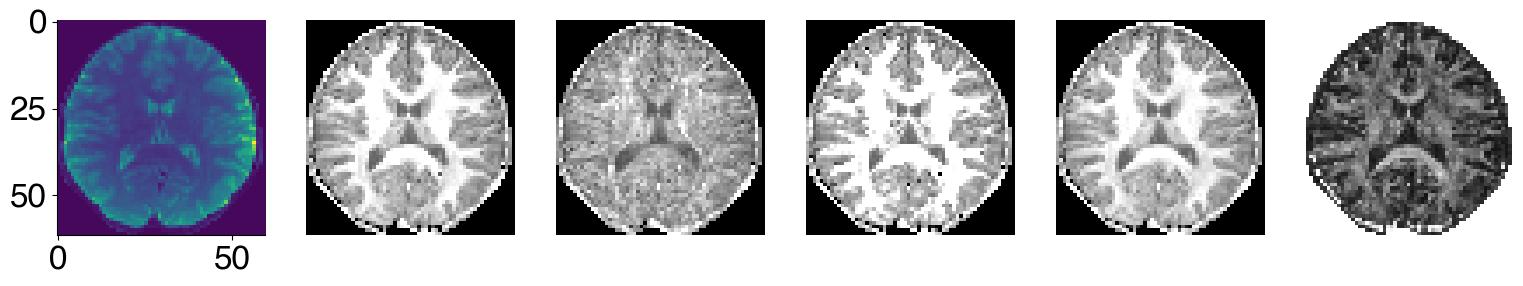

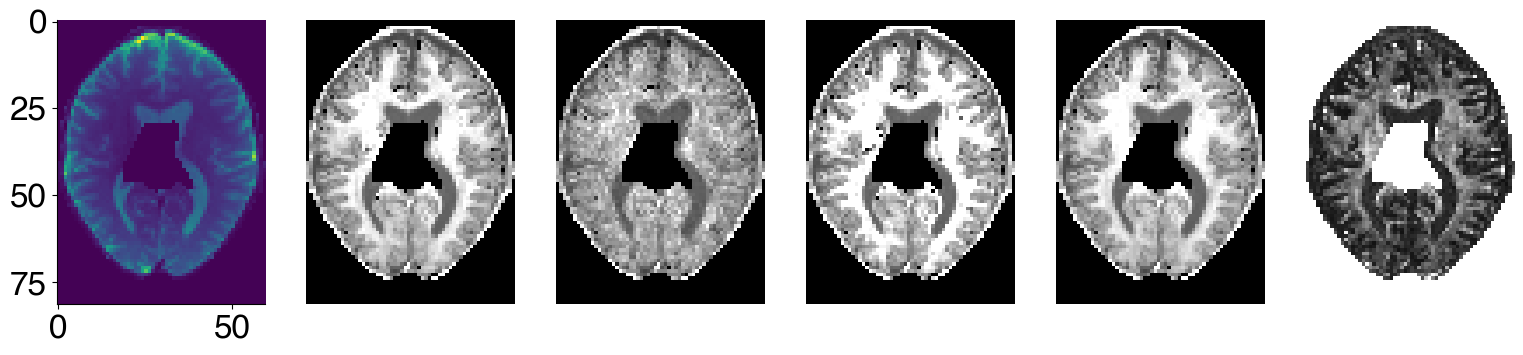

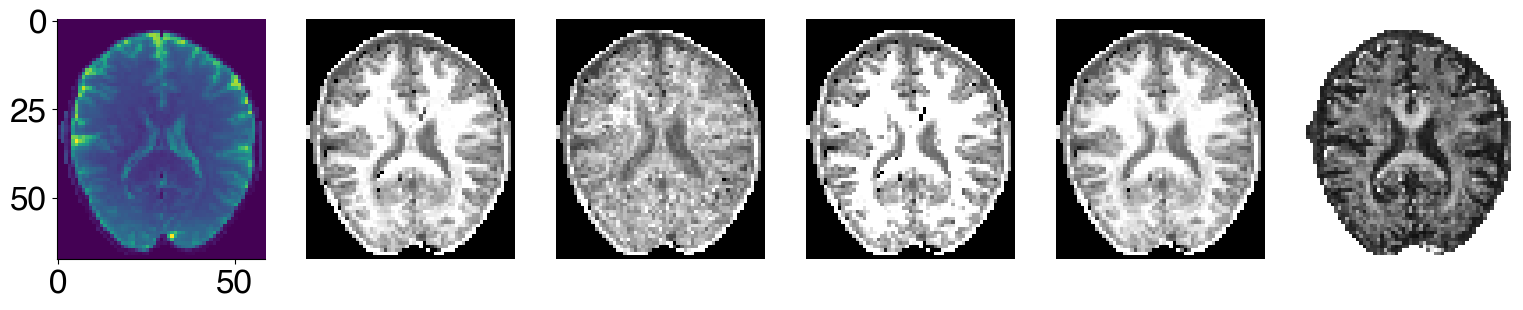

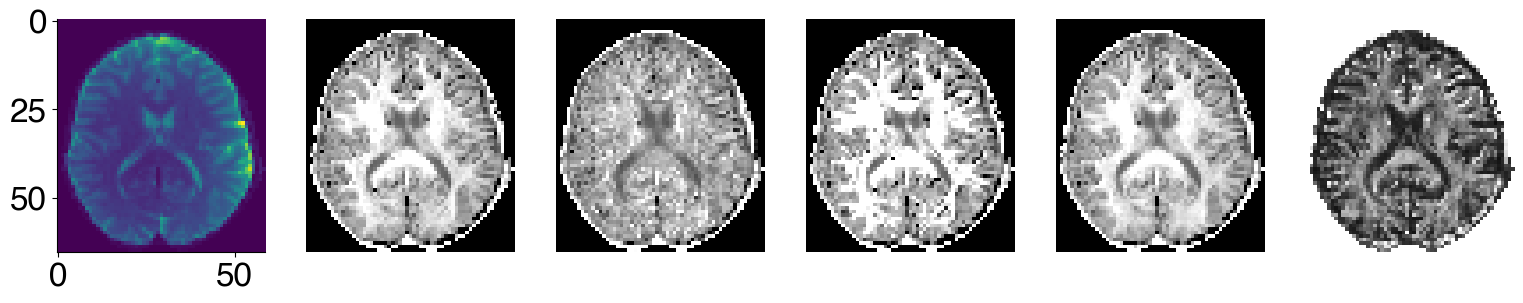

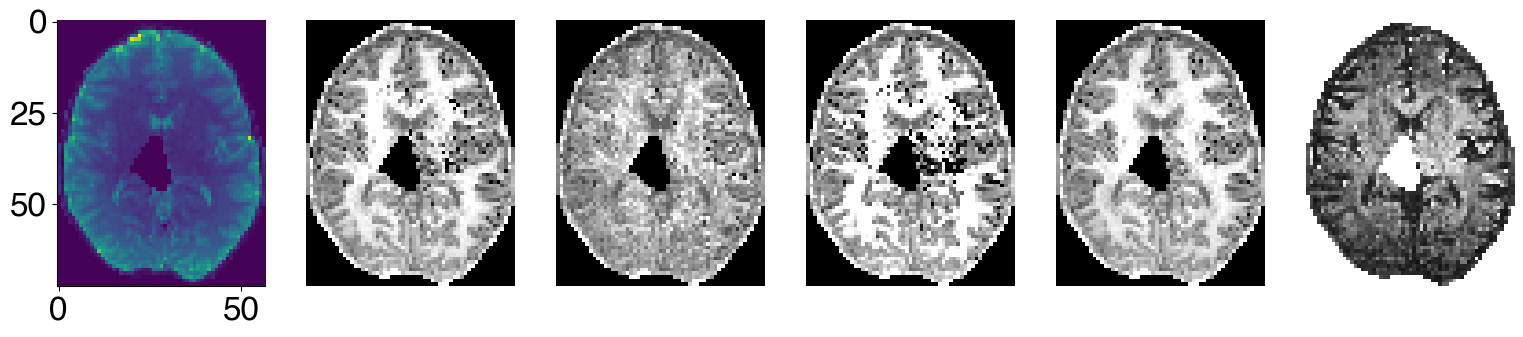

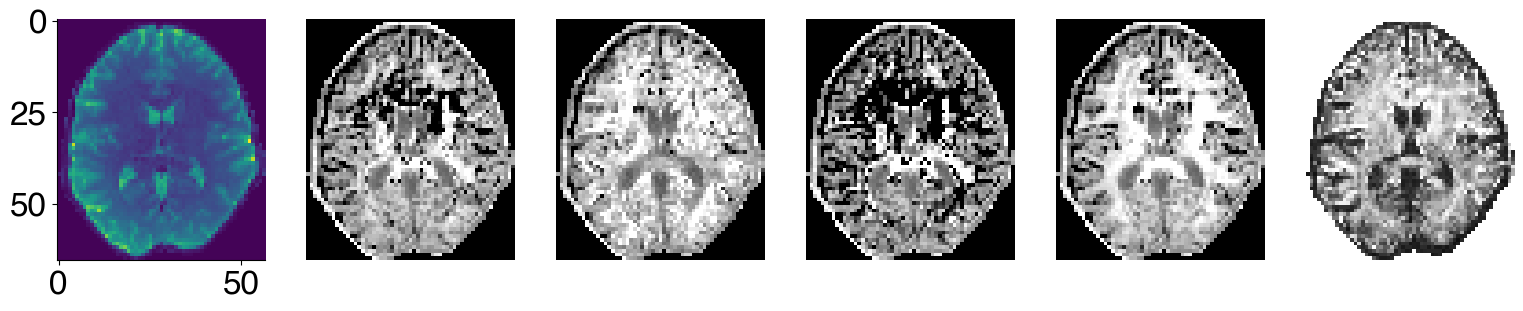

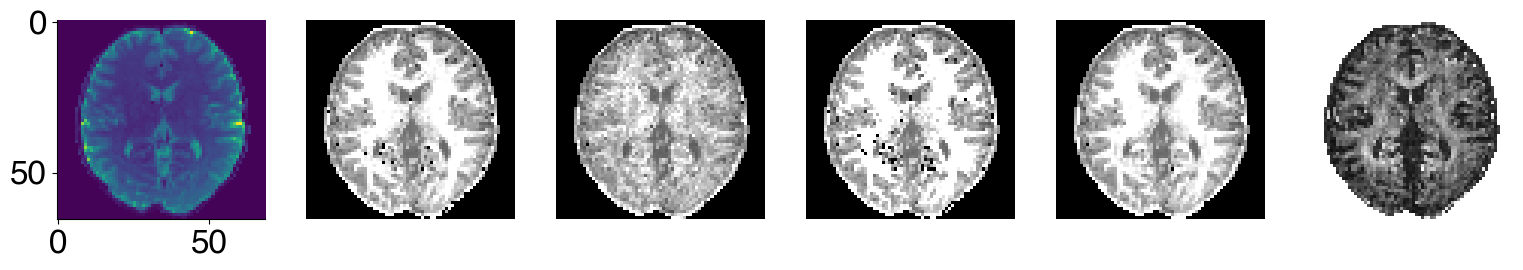

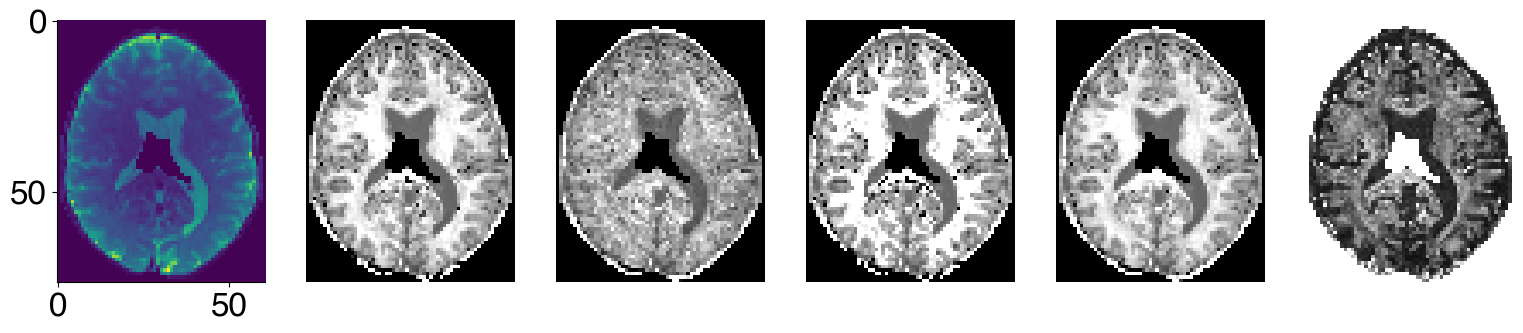

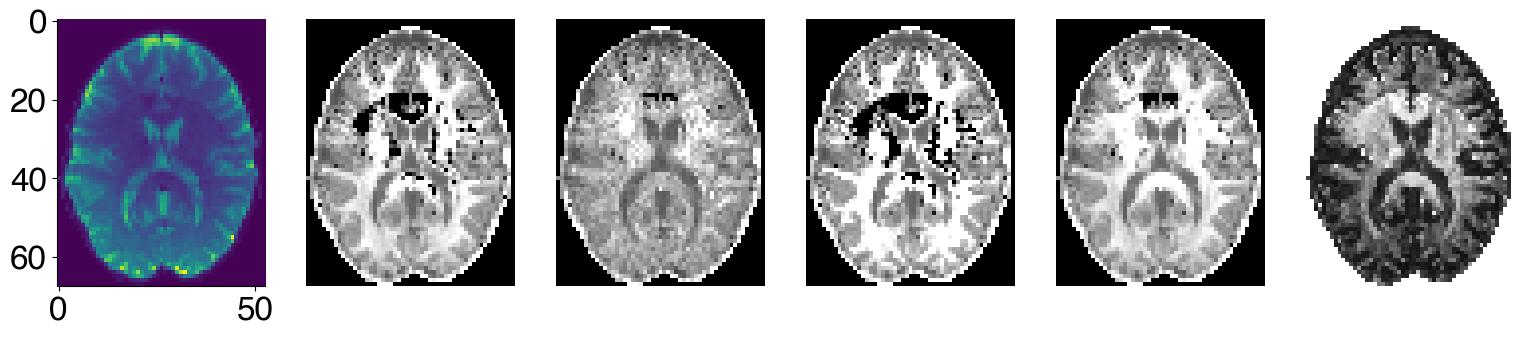

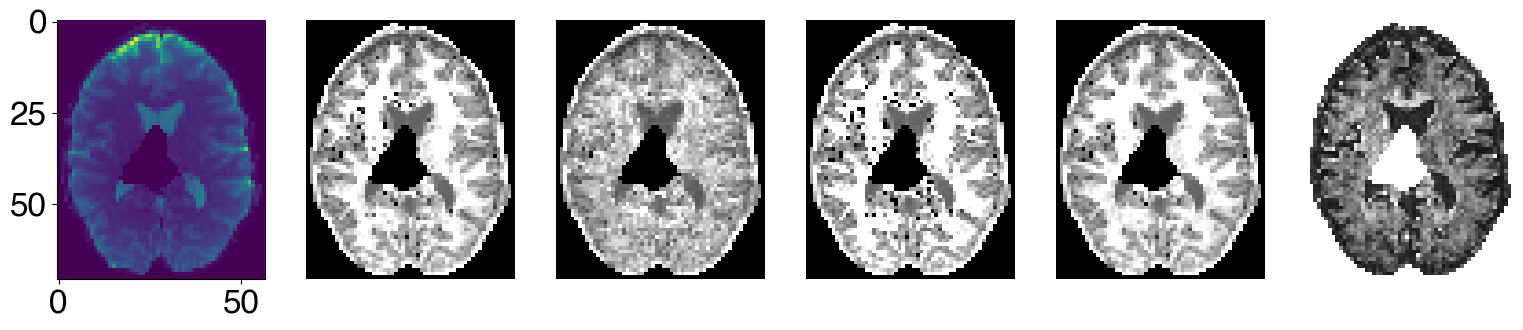

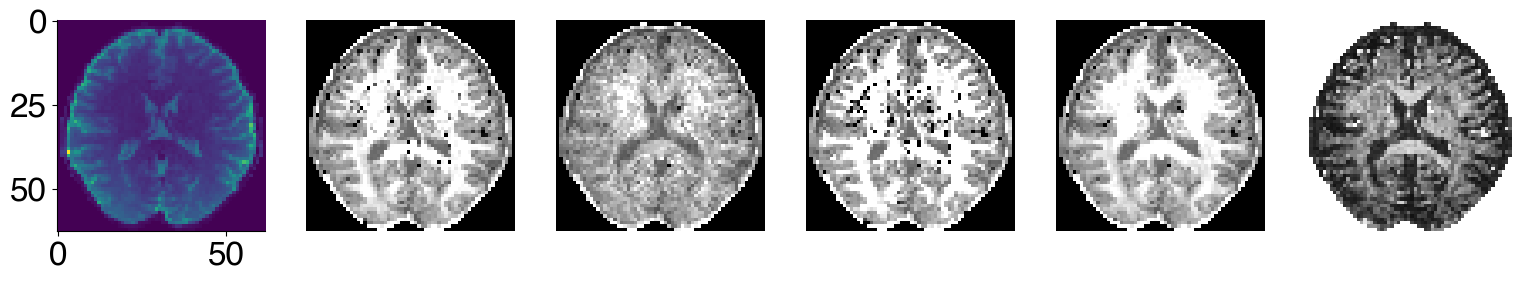

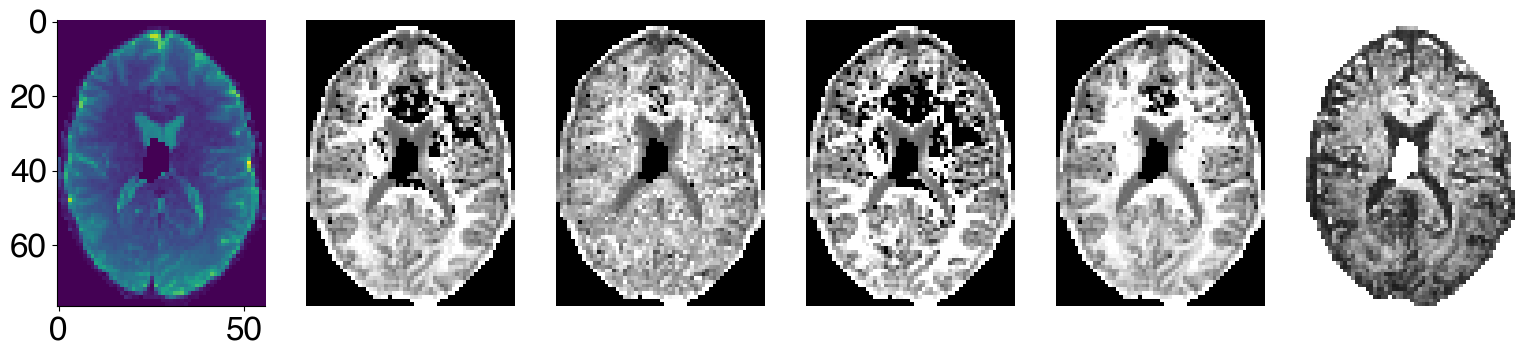

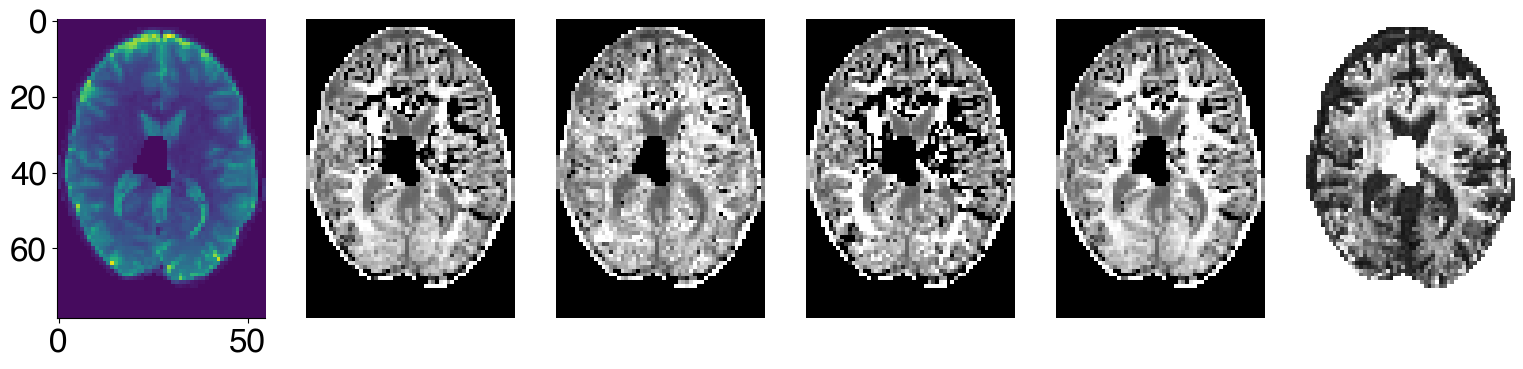

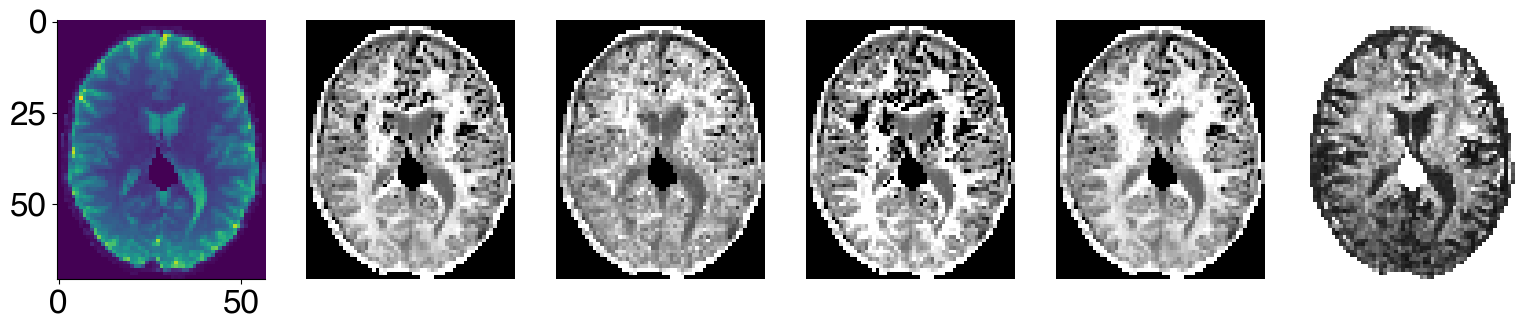

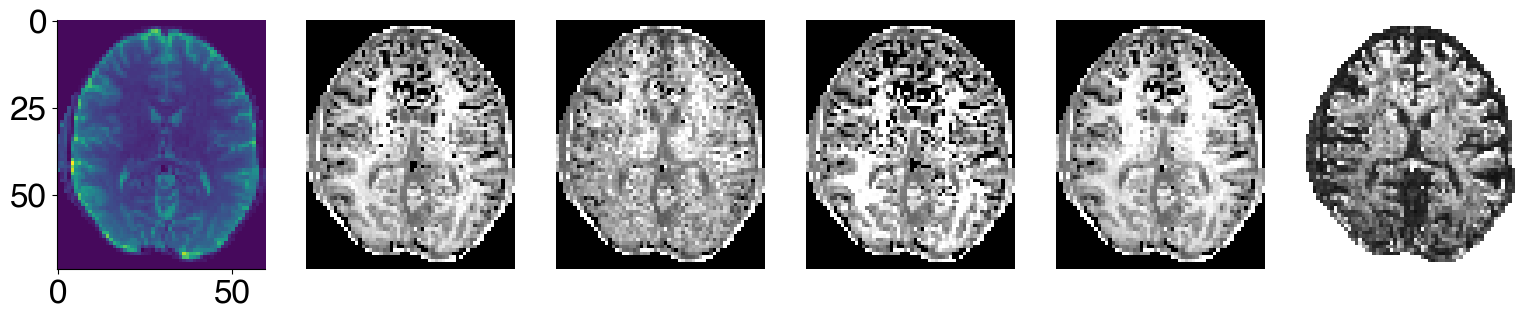

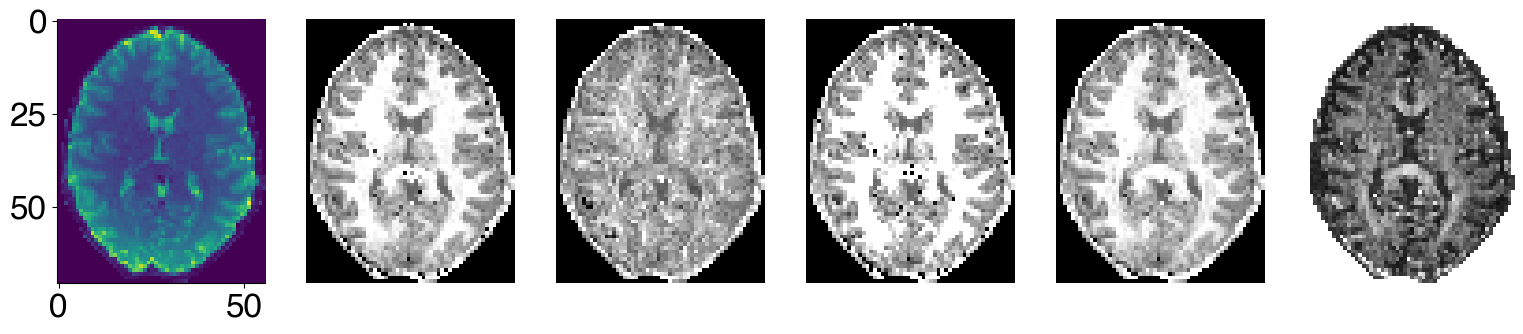

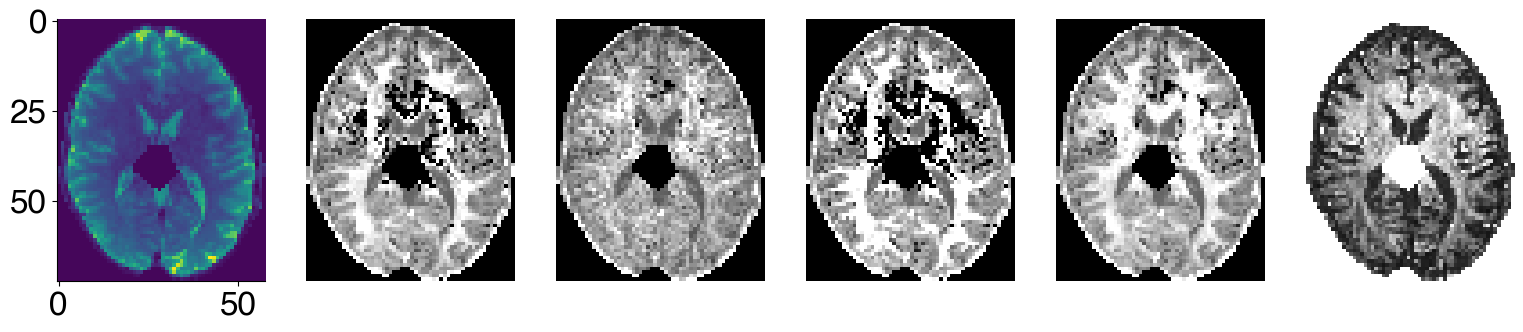

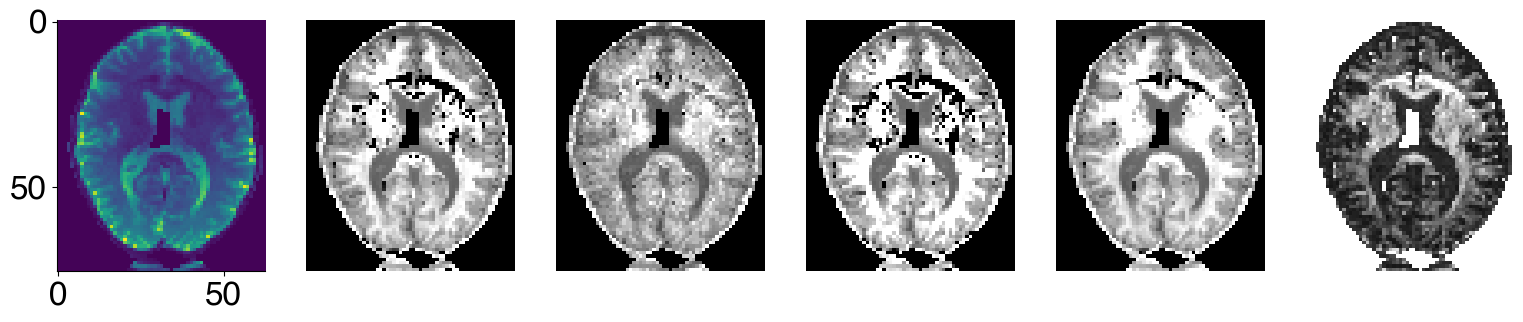

In [1109]:
MKFullArr = []
RKFullArr = []
AKFullArr = []
MKTFullArr = []
KFAFullArr = []
for kk in tqdm(range(32)):
    
    # Compute the mask where the sum is not zero
    mask = np.sum(TD[kk][:, :, axial_middles[kk], :69], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorFull.sample((500,), x=np.hstack([TD[kk][i, j, axial_middles[kk], :],kk]),show_progress_bars=False)
        return i, j, np.array([histogram_mode(p) for p in posterior_samples_1.T])
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in indices
    )
    
    NoiseEst = np.zeros(list(ArrShape) + [22])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,6:]])

    MK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    AK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    RK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    MKT_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    KFA_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]): 
            Metrics = DKIMetrics(NoiseEst2[i,j][:6],NoiseEst2[i,j][6:21])
            MK_SBIFull[i,j] = Metrics[0]
            AK_SBIFull[i,j] = Metrics[1]
            RK_SBIFull[i,j] = Metrics[2]
            MKT_SBIFull[i,j] = Metrics[3]
            KFA_SBIFull[i,j] = Metrics[4]
        
    fig,ax = plt.subplots(1,6,figsize=(18.8,6.4))
    ax[0].imshow(TD[kk][:,:,axial_middles[kk],0].T)
    plt.sca(ax[1])
    img = plt.imshow(MK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[2])
    img = plt.imshow(AK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[3])
    img = plt.imshow(RK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[4])
    img = plt.imshow(MKT_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[5])
    img = plt.imshow(KFA_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.show()

    MKFullArr.append(MK_SBIFull)
    RKFullArr.append(RK_SBIFull)
    AKFullArr.append(AK_SBIFull)
    MKTFullArr.append(MKT_SBIFull)
    KFAFullArr.append(KFA_SBIFull)

In [1110]:
i = 1
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))
# Iteratively select the point furthest from the current selection
for _ in range(5):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(bvecsHCP))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

selected_indices7 = [0]+selected_indices

bvalsHCP7_1 = bvalsHCP[selected_indices7]
bvecsHCP7_1 = bvecsHCP[selected_indices7]

bvalloc = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP3 = np.loadtxt(bvalloc)
bvecsHCP3 = np.loadtxt(bvecloc)
gtabHCP3 = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]

temp_bvecs = bvecsHCP3[bvalsHCP3>0]
temp_bvals = bvalsHCP3[bvalsHCP3>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(14):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

bvalsHCP7_3 = temp_bvals[selected_indices]
bvecsHCP7_3 = temp_bvecs[selected_indices]

gtabHCP7 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

true_indx = []
for b in bvecsHCP7_3:
    true_indx.append(np.linalg.norm(b-bvecsHCP3,axis=1).argmin())
selected_indices7 = selected_indices7+[t+69 for t in true_indx]



In [1111]:
if os.path.exists(f"{network_path}/DKIMultiHCPMin_300k.pickle"):
    with open(f"{network_path}/DKIMultiHCPMin_300k.pickle", "rb") as handle:
        posteriorMin = pickle.load(handle)
else:
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(75000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(75000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(150000))   
    
    DT = np.vstack([DT5,DT2,DT3])
    KT = np.vstack([KT5,KT2,KT3])
    
    S0Dist = BoxUniform(low=torch.tensor([lower_S0]), high=torch.tensor([upper_S0]))
    
    S0 = S0Dist.sample([DT.shape[0]])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    A  = np.random.choice(32,DT.shape[0])
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gTabsF[0].bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm.tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gTabsF[A[i]],S0[i],50)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>4*np.array(S0[i])).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT,S0])
    Obs = np.hstack([Obs[:,selected_indices7],np.expand_dims(A, axis=-1)])
        
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 50)
    posteriorFull = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DKIMultiHCPMin_300k.pickle"):
        with open(f"{network_path}/DKIMultiHCPMin_300k.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)
    import os
    os.system("say 'DKI network done'") # or '\7'

  0%|          | 0/32 [00:00<?, ?it/s]

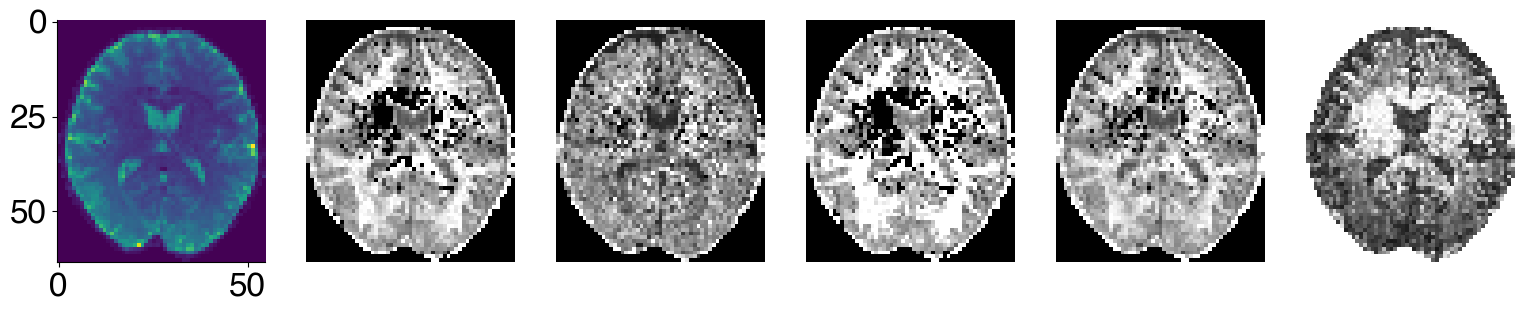

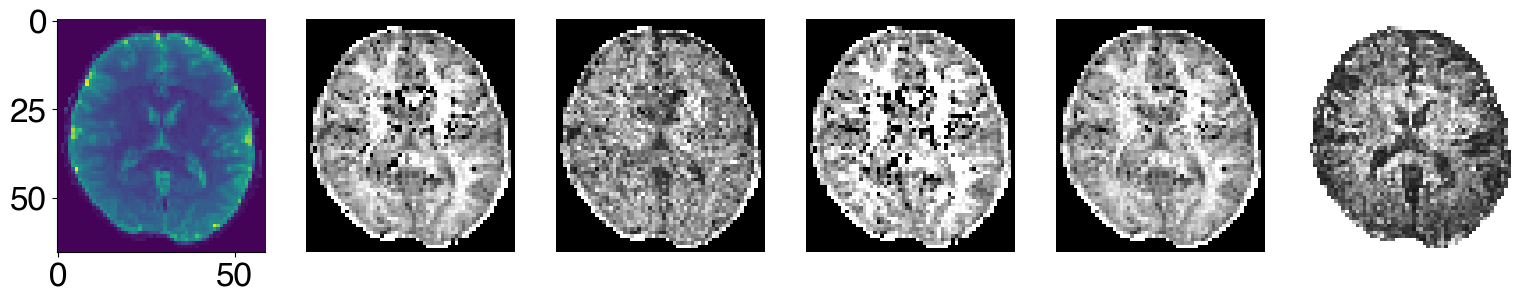

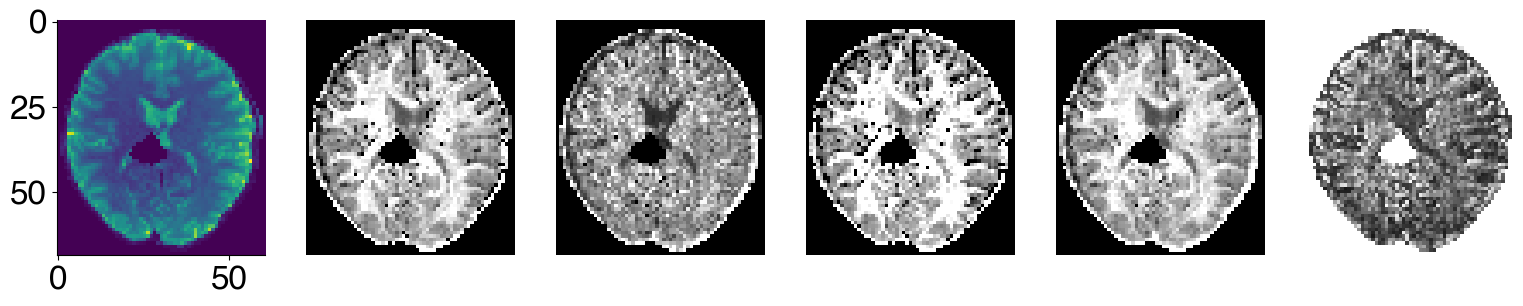

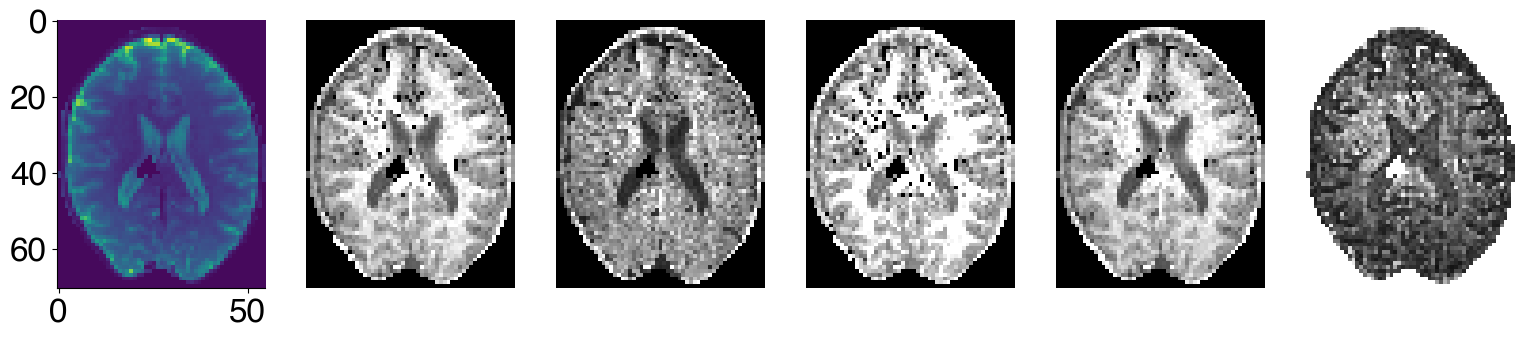

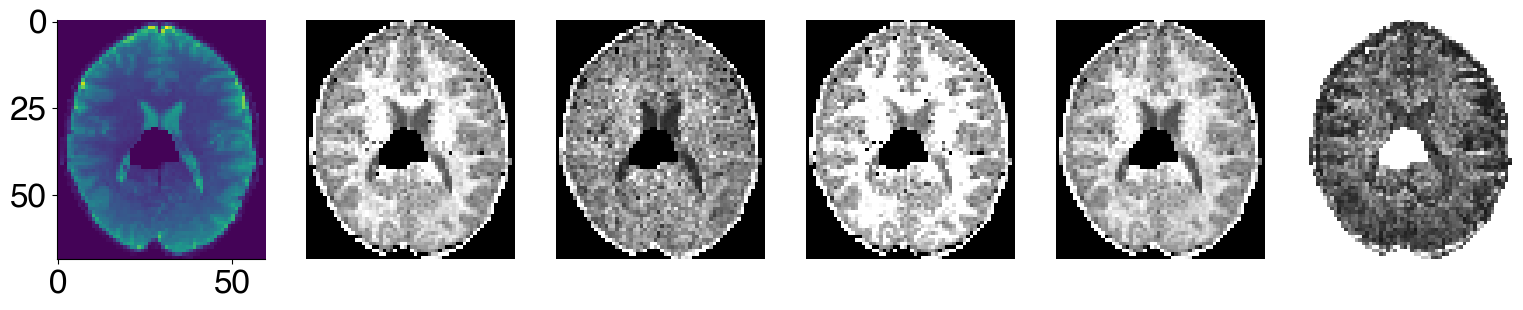

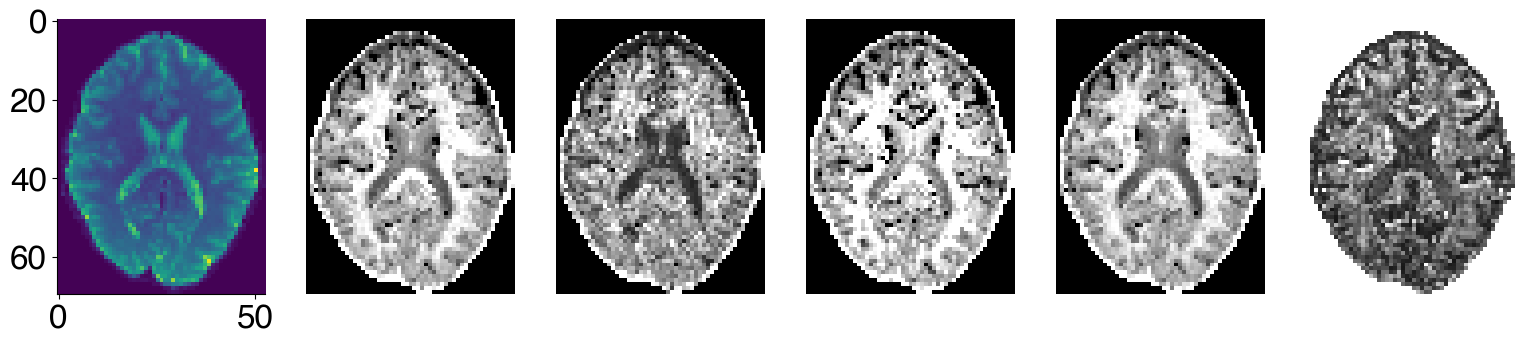

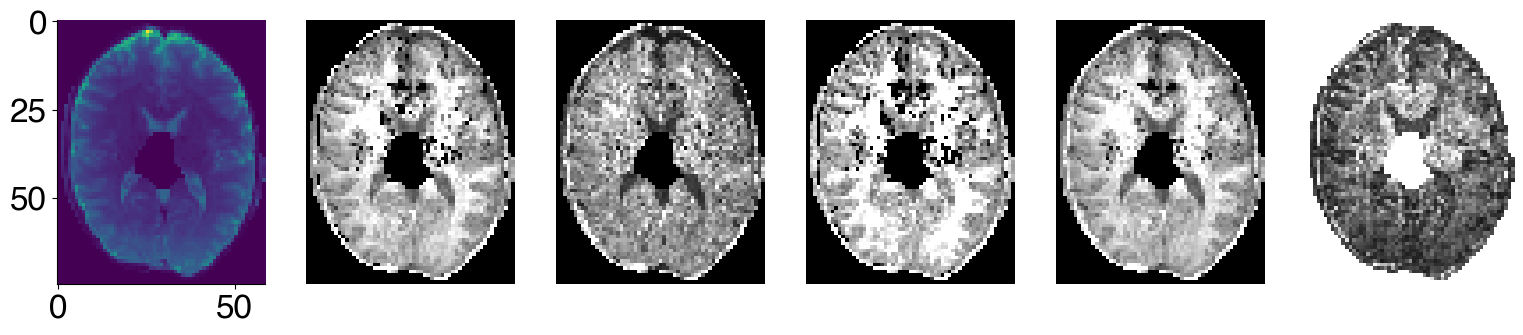

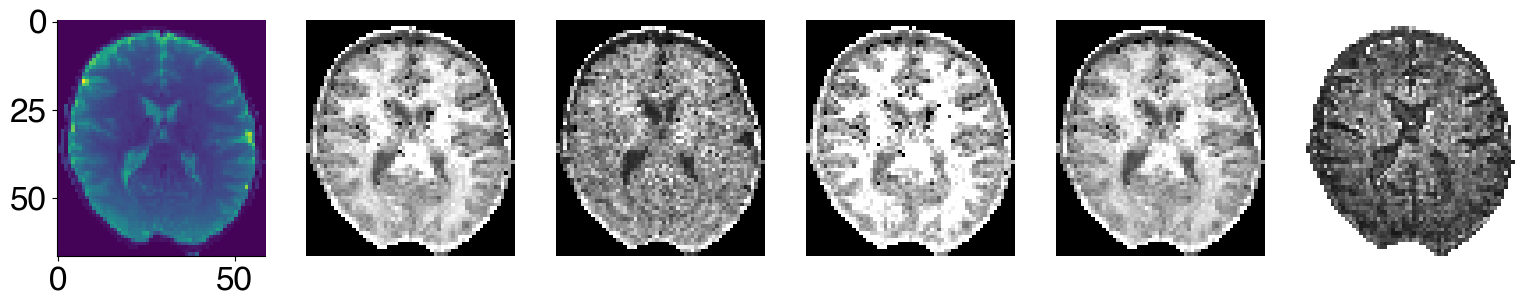

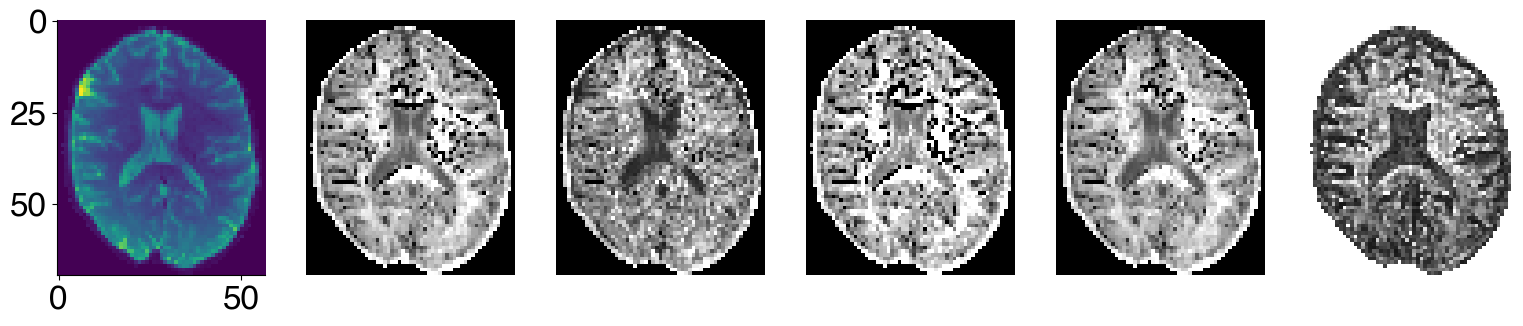

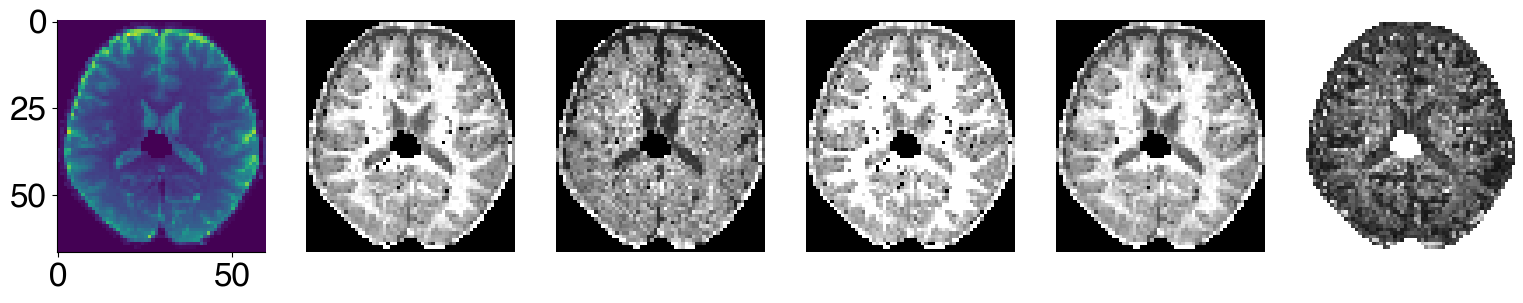

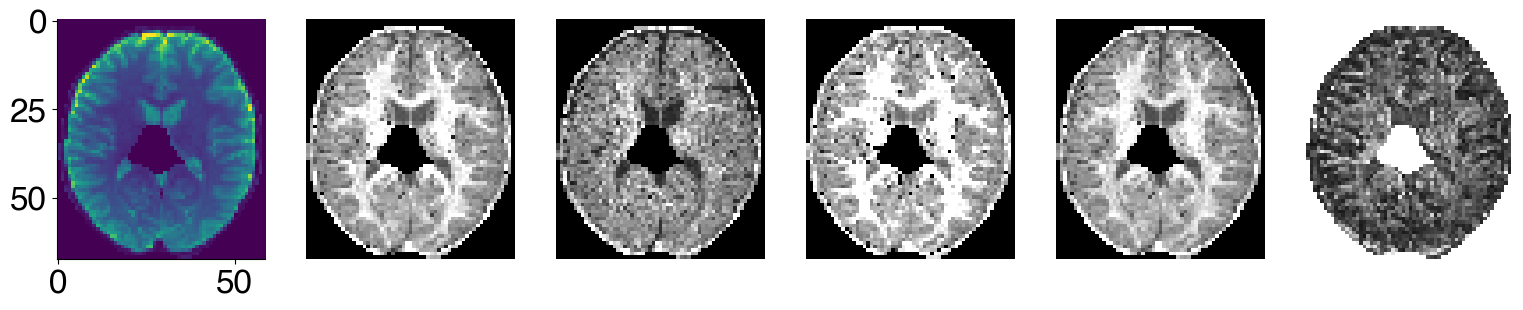

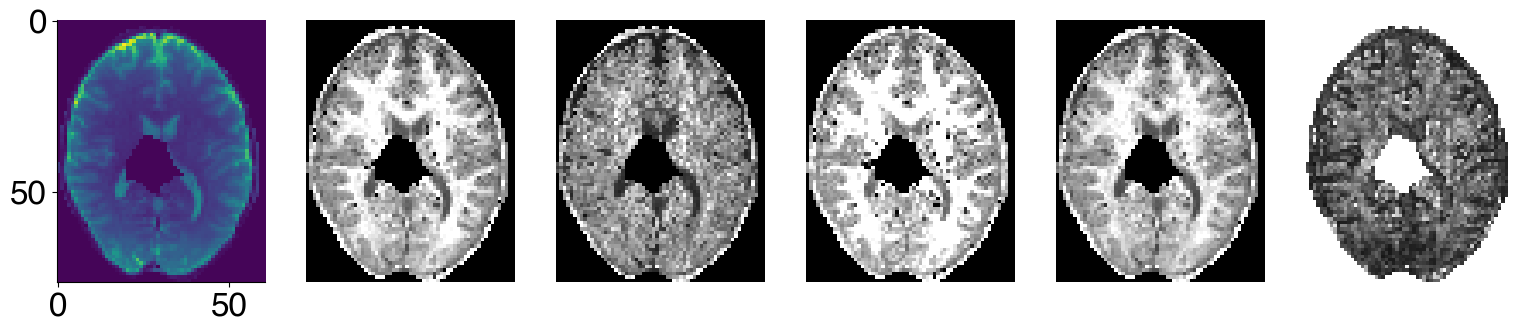

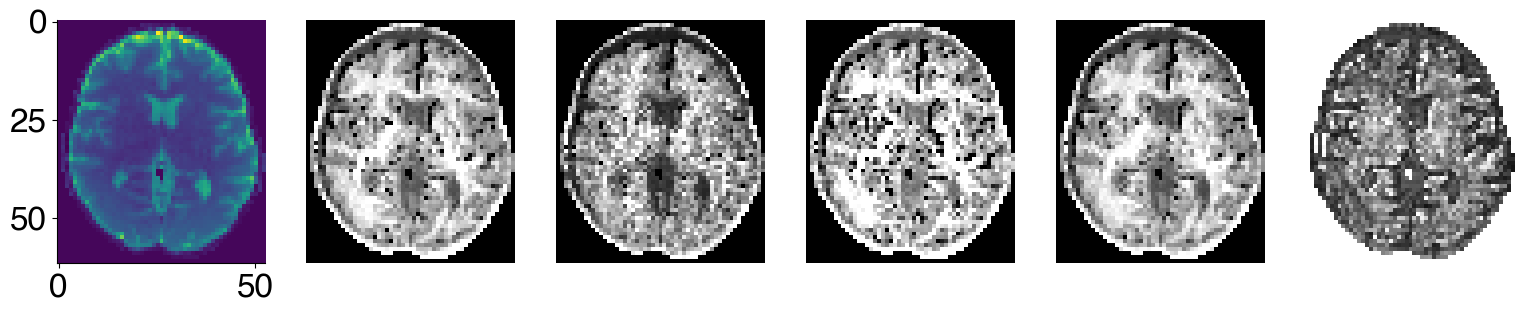

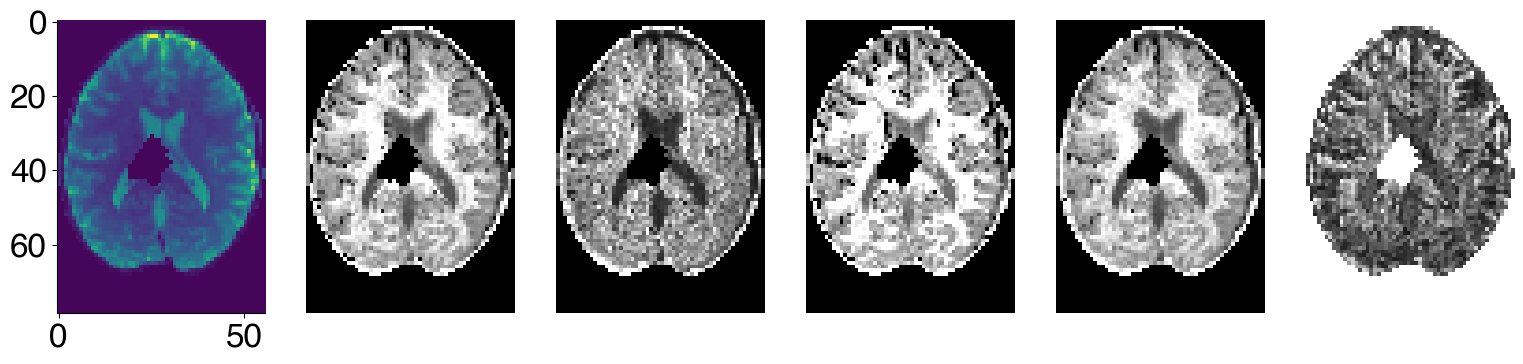

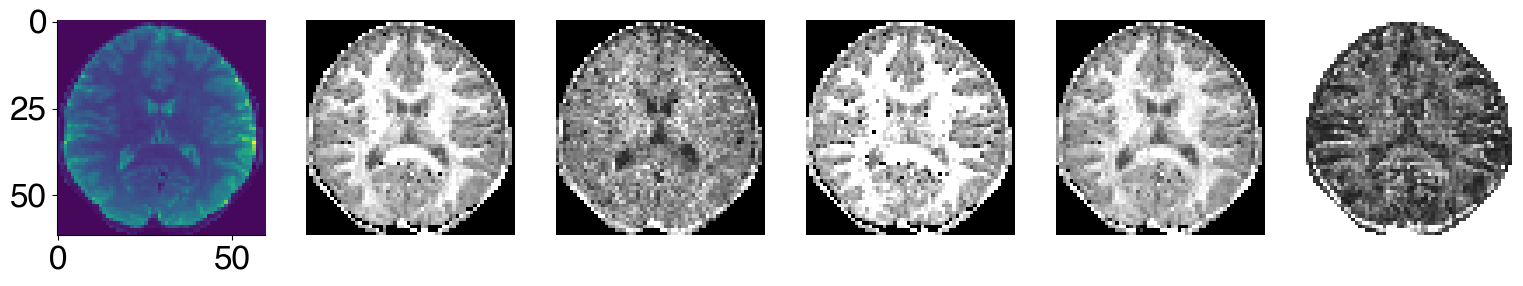

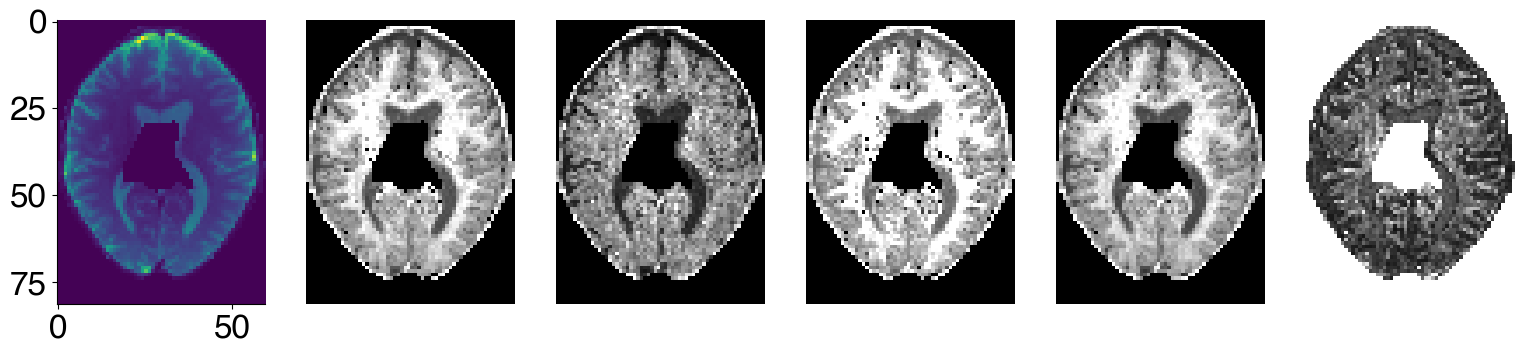

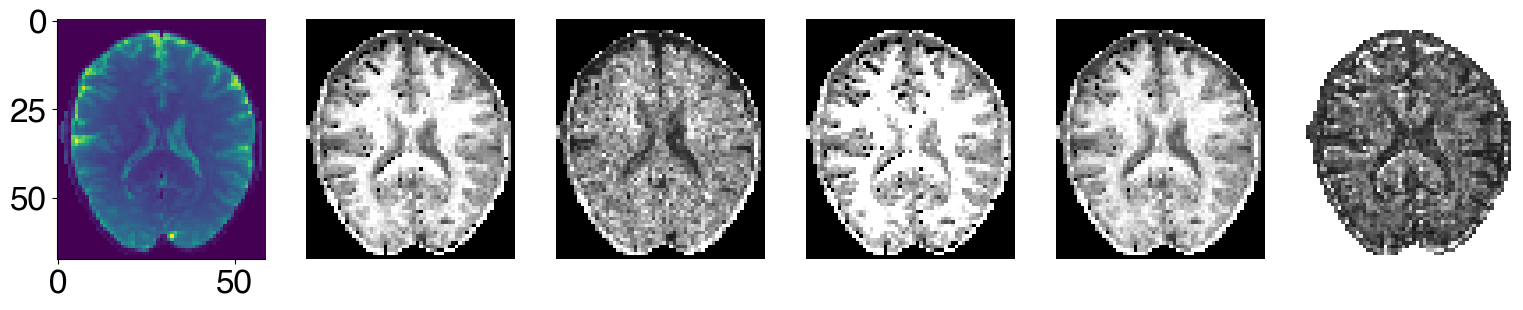

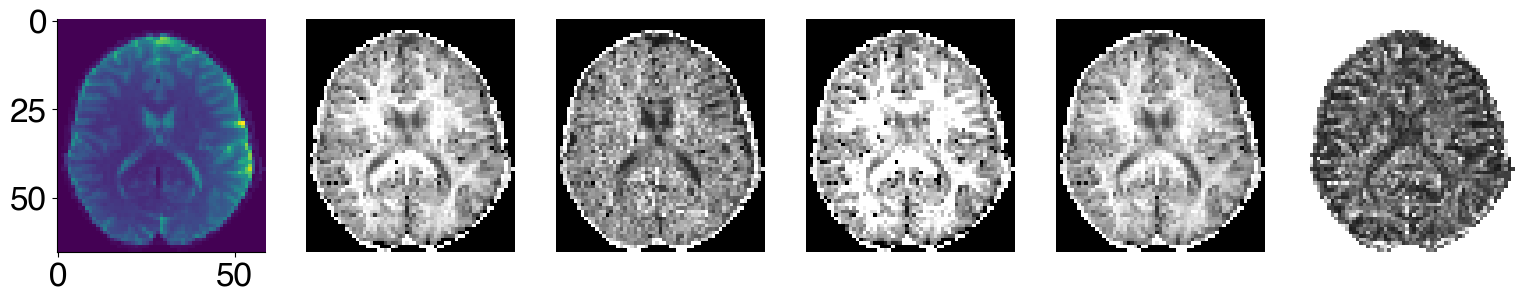

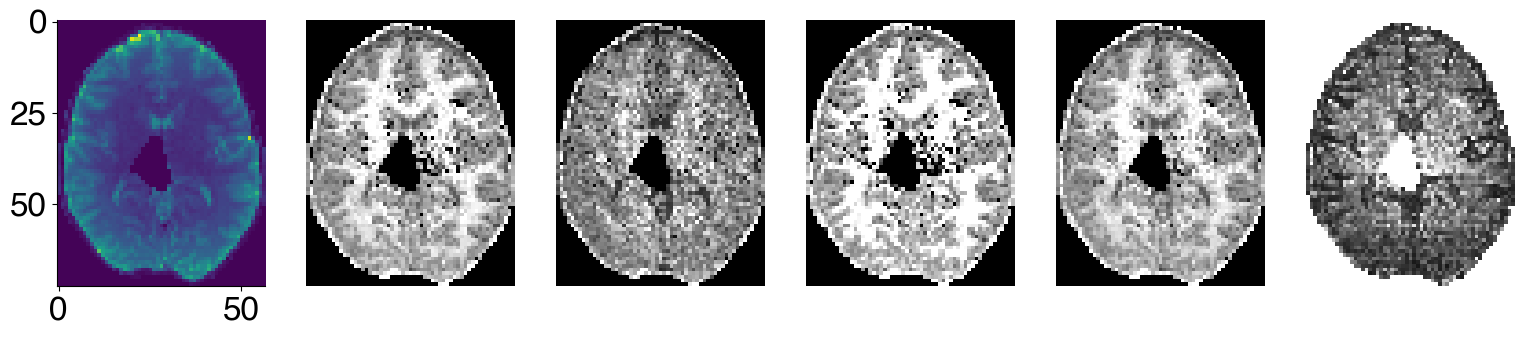

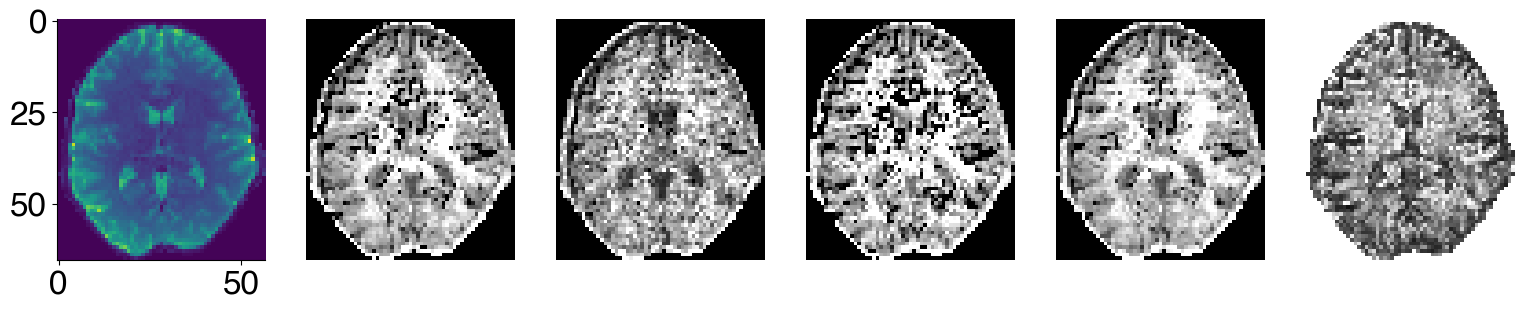

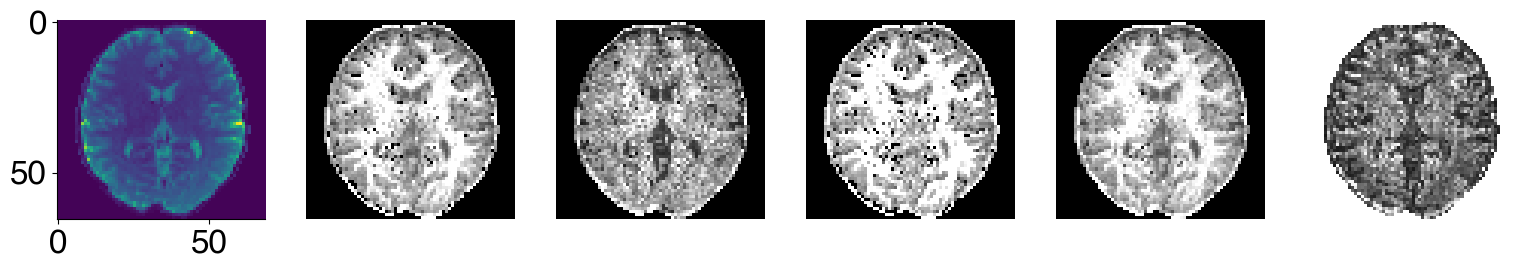

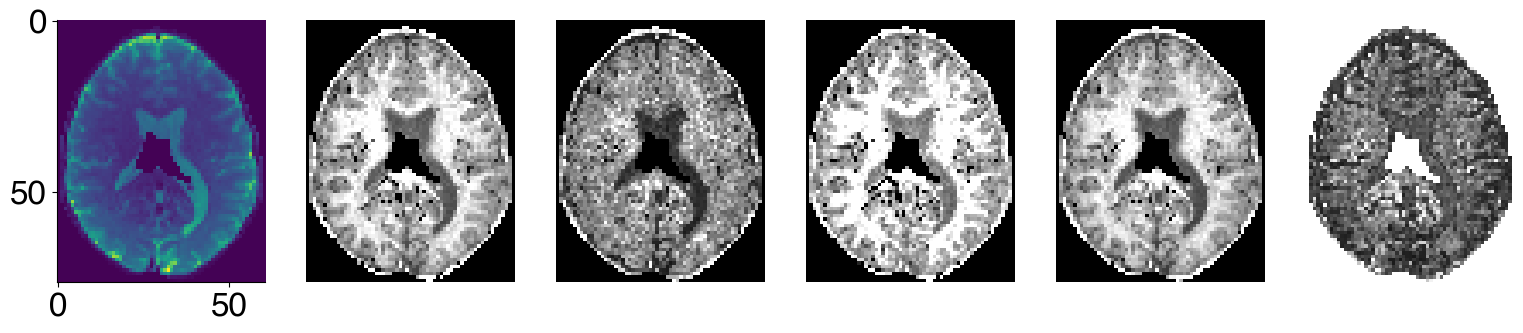

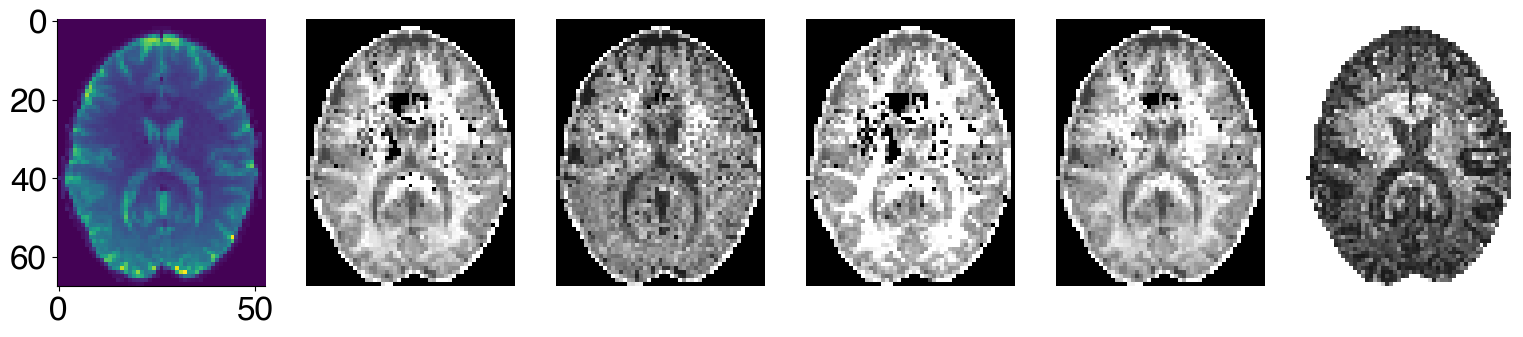

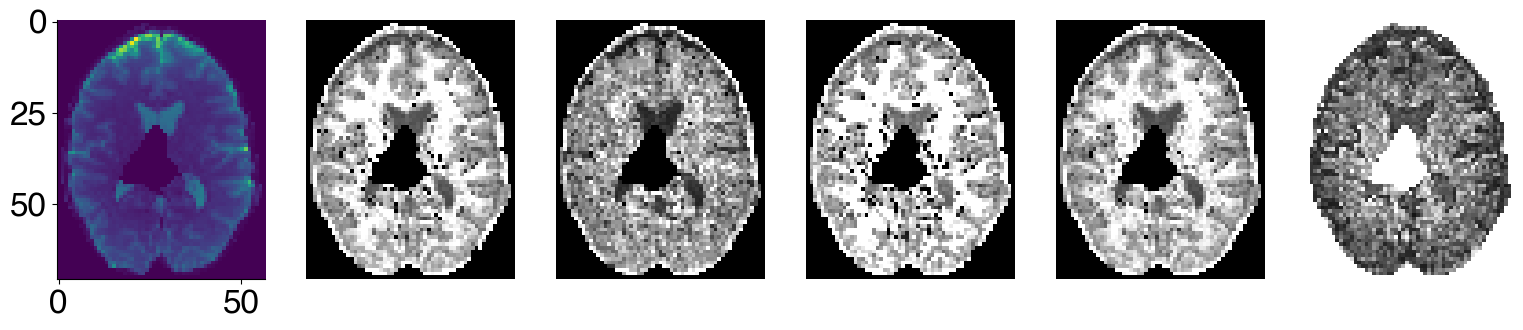

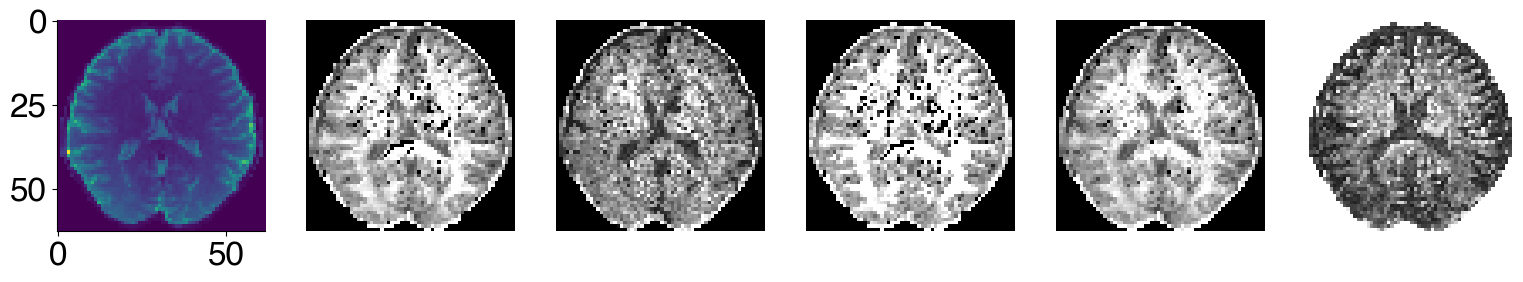

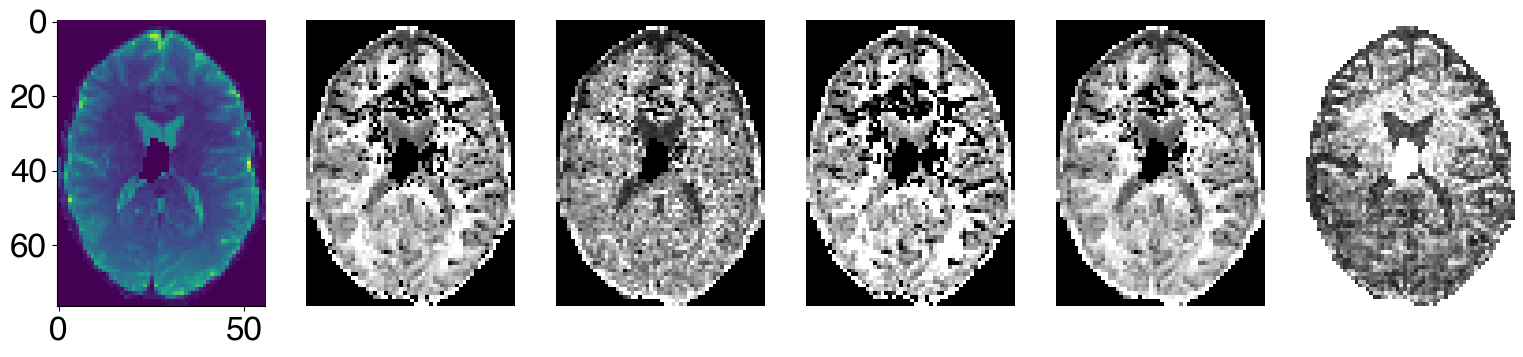

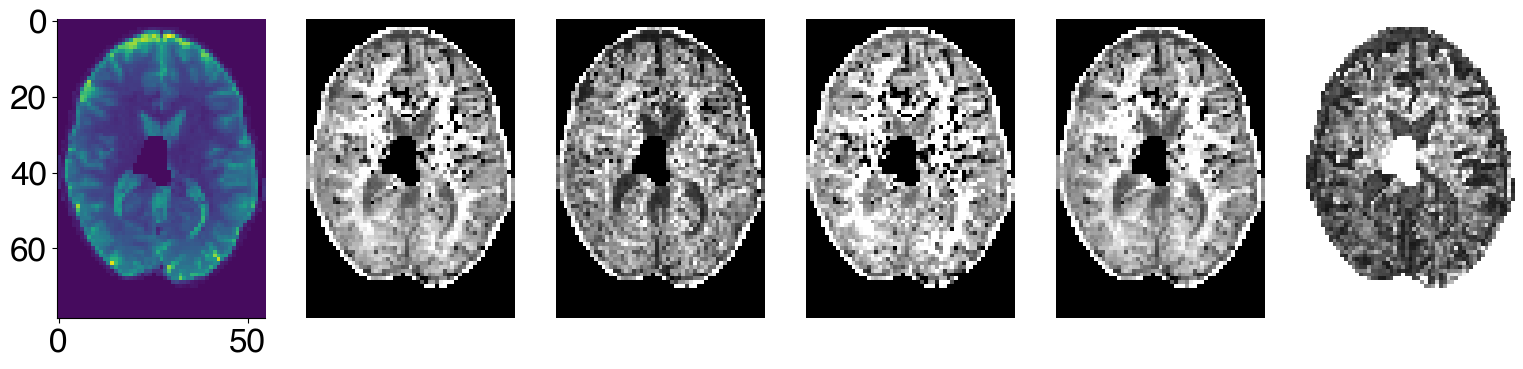

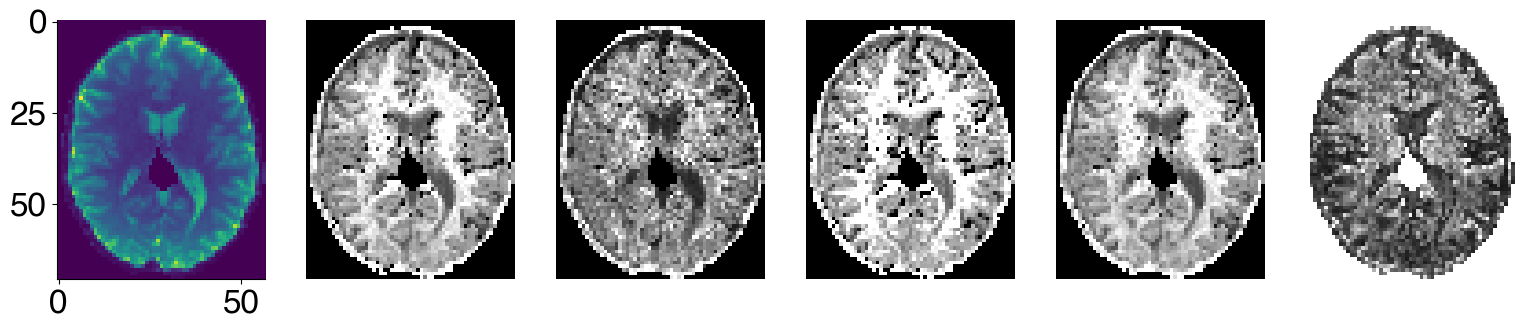

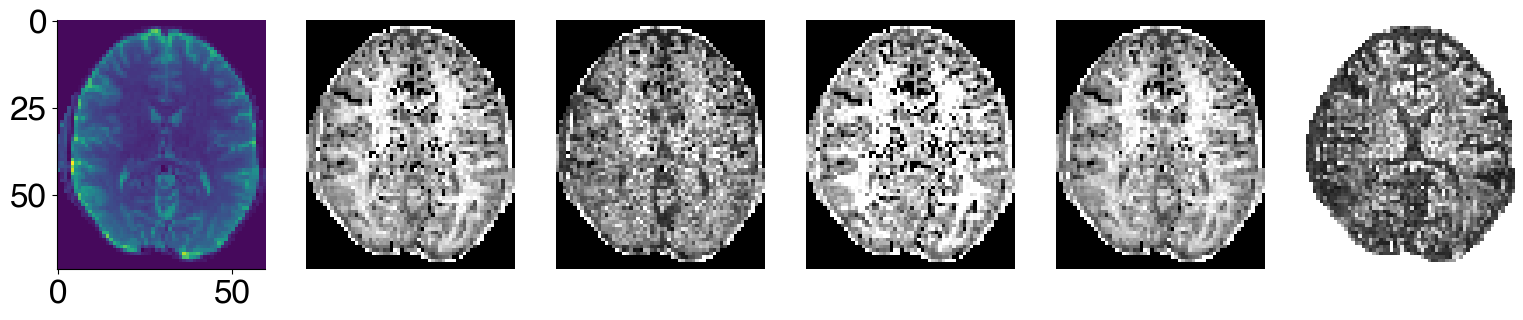

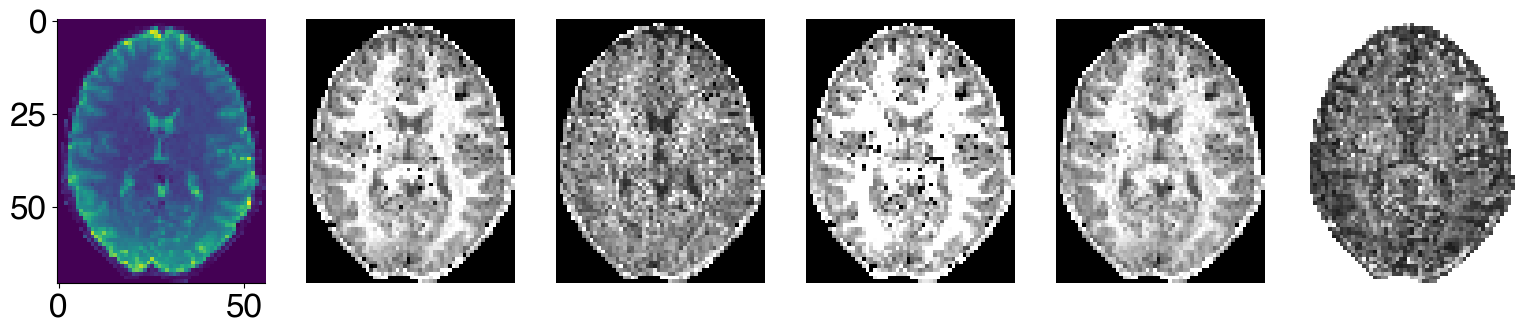

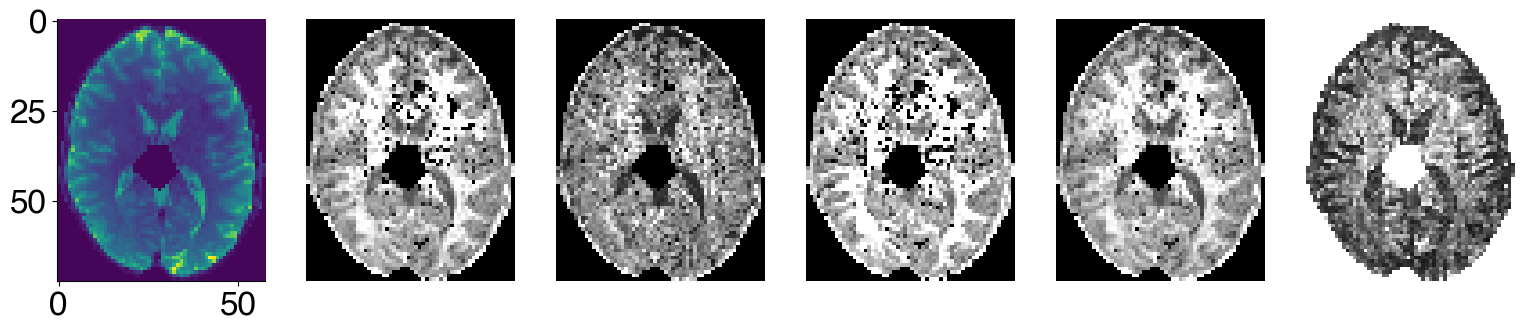

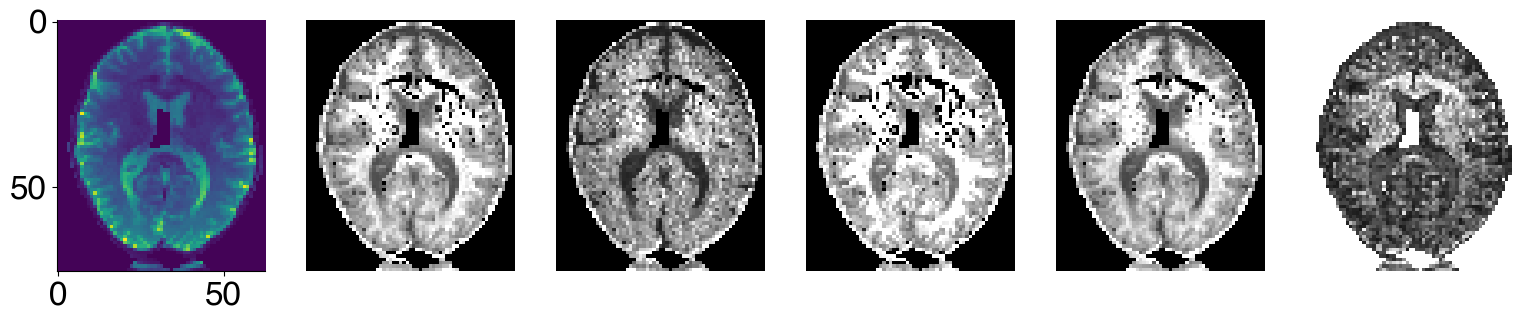

In [1112]:
MKMinArr = []
RKMinArr = []
AKMinArr = []
MKTMinArr = []
KFAMinArr = []
for kk in tqdm(range(32)):
    
    # Compute the mask where the sum is not zero
    mask = np.sum(TD[kk][:, :, axial_middles[kk], :69], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorMin.sample((500,), x=np.hstack([TD[kk][i, j, axial_middles[kk], selected_indices7],kk]),show_progress_bars=False)
        return i, j, np.array([histogram_mode(p) for p in posterior_samples_1.T])
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in indices
    )
    
    NoiseEst = np.zeros(list(ArrShape) + [22])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,6:]])

    MK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    AK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    RK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    MKT_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    KFA_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]): 
            Metrics = DKIMetrics(NoiseEst2[i,j][:6],NoiseEst2[i,j][6:21])
            MK_SBIFull[i,j] = Metrics[0]
            AK_SBIFull[i,j] = Metrics[1]
            RK_SBIFull[i,j] = Metrics[2]
            MKT_SBIFull[i,j] = Metrics[3]
            KFA_SBIFull[i,j] = Metrics[4]
        
    fig,ax = plt.subplots(1,6,figsize=(18.8,6.4))
    ax[0].imshow(TD[kk][:,:,axial_middles[kk],0].T)
    plt.sca(ax[1])
    img = plt.imshow(MK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[2])
    img = plt.imshow(AK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[3])
    img = plt.imshow(RK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[4])
    img = plt.imshow(MKT_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[5])
    img = plt.imshow(KFA_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.show()

    MKMinArr.append(MK_SBIFull)
    RKMinArr.append(RK_SBIFull)
    AKMinArr.append(AK_SBIFull)
    MKTMinArr.append(MKT_SBIFull)
    KFAMinArr.append(KFA_SBIFull)

In [1113]:
i = 1
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [1]
distance_matrix = squareform(pdist(bvecsHCP))

temp_bvecs = bvecsHCP[bvalsHCP>0]
temp_bvals = bvalsHCP[bvalsHCP>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(18):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

temp = selected_indices

bvalsHCP7_1 = np.insert(temp_bvals[temp],0,0)
bvecsHCP7_1 = np.insert(temp_bvecs[temp],0,[0,0,0],axis=0)

bvalloc = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP3 = np.loadtxt(bvalloc)
bvecsHCP3 = np.loadtxt(bvecloc)
gtabHCP3 = gradient_table(bvalsHCP, bvecsHCP)

# Choose the first point (arbitrary starting point, e.g., the first gradient)
selected_indices = [0]

temp_bvecs = bvecsHCP3[bvalsHCP3>0]
temp_bvals = bvalsHCP3[bvalsHCP3>0]
distance_matrix = squareform(pdist(temp_bvecs))
# Iteratively select the point furthest from the current selection
for _ in range(27):  # We need 7 points in total, and one is already selected
    remaining_indices = list(set(range(len(temp_bvecs))) - set(selected_indices))
    
    # Calculate the minimum distance to the selected points for each remaining point
    min_distances = np.min(distance_matrix[remaining_indices][:, selected_indices], axis=1)
    
    # Select the point with the maximum minimum distance
    next_index = remaining_indices[np.argmax(min_distances)]
    selected_indices.append(next_index)

bvalsHCP7_3 = temp_bvals[selected_indices]
bvecsHCP7_3 = temp_bvecs[selected_indices]

gtabHCP20 = gradient_table(np.hstack((bvalsHCP7_1,bvalsHCP7_3)), np.vstack((bvecsHCP7_1,bvecsHCP7_3)))

true_indx_one = []
for b in bvecsHCP7_1:
    true_indx_one.append(np.linalg.norm(b-bvecsHCP,axis=1).argmin())
true_indx = []        
for b in bvecsHCP7_3:
    true_indx.append(np.linalg.norm(b-bvecsHCP3,axis=1).argmin())
selected_indices20 = true_indx_one+[t+69 for t in true_indx]

In [1114]:
if os.path.exists(f"{network_path}/DKIMultiHCPMid_300k.pickle"):
    with open(f"{network_path}/DKIMultiHCPMid_300k.pickle", "rb") as handle:
        posteriorMid = pickle.load(handle)
else:
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(75000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(75000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(150000))   
    
    DT = np.vstack([DT5,DT2,DT3])
    KT = np.vstack([KT5,KT2,KT3])
    
    S0Dist = BoxUniform(low=torch.tensor([lower_S0]), high=torch.tensor([upper_S0]))
    
    S0 = S0Dist.sample([DT.shape[0]])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    A  = np.random.choice(32,DT.shape[0])
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gTabsF[0].bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm.tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gTabsF[A[i]],S0[i],50)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>4*np.array(S0[i])).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT,S0])
    Obs = np.hstack([Obs[:,selected_indices20],np.expand_dims(A, axis=-1)])
        
    
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 50)
    posteriorFull = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DKIMultiHCPMid_300k.pickle"):
        with open(f"{network_path}/DKIMultiHCPMid_300k.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)
    import os
    os.system("say 'DKI network done'") # or '\7'

  0%|          | 0/32 [00:00<?, ?it/s]

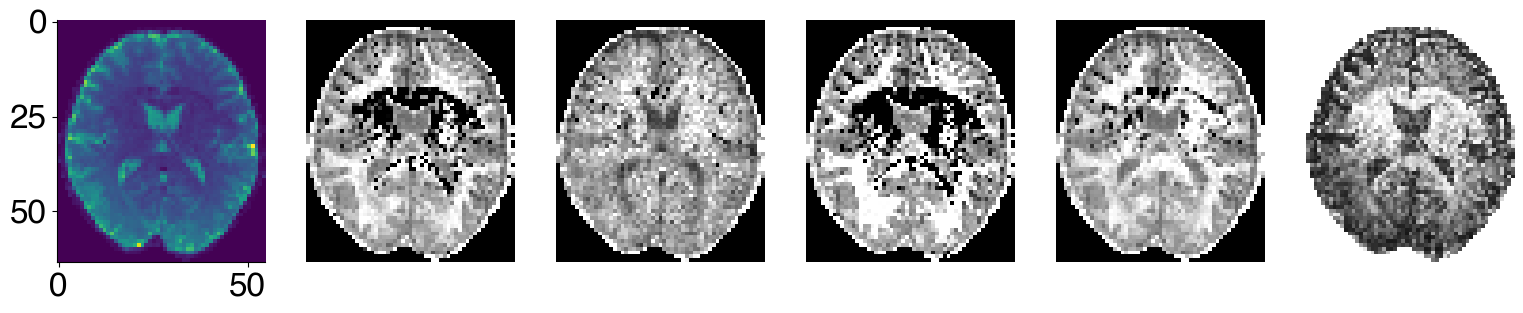

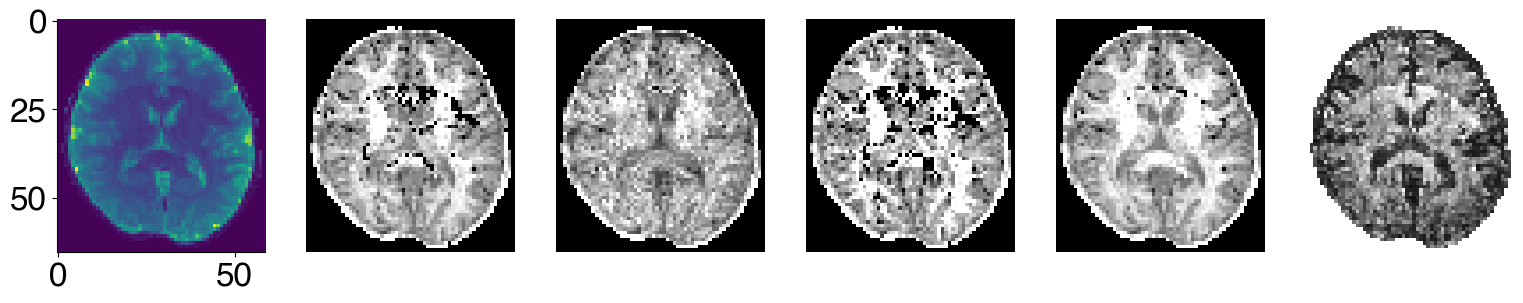

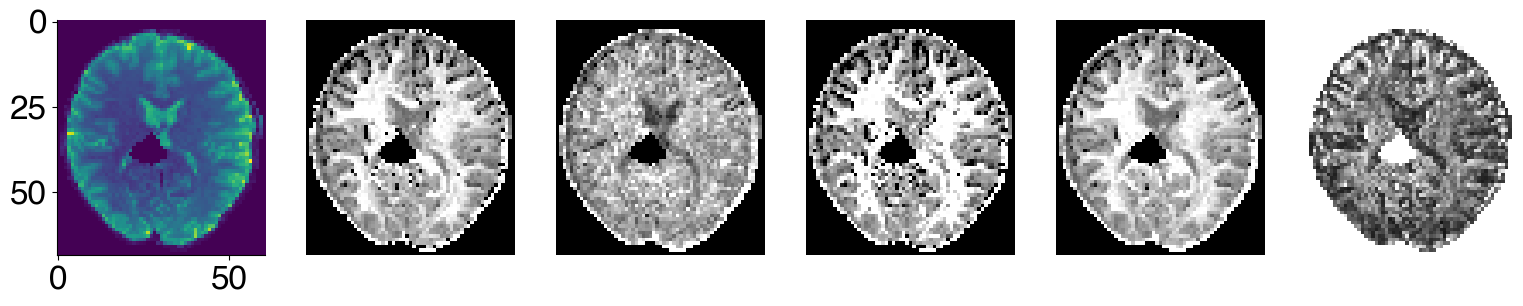

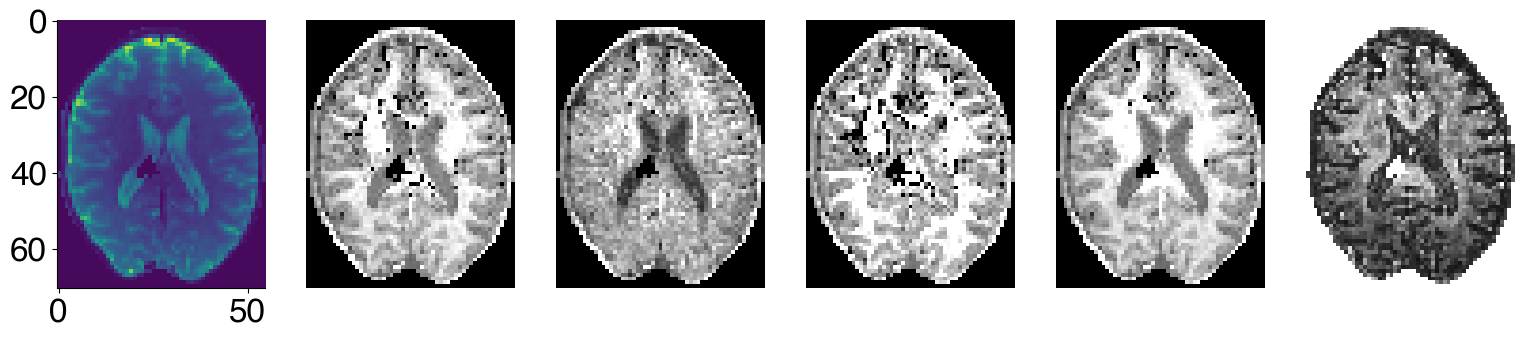

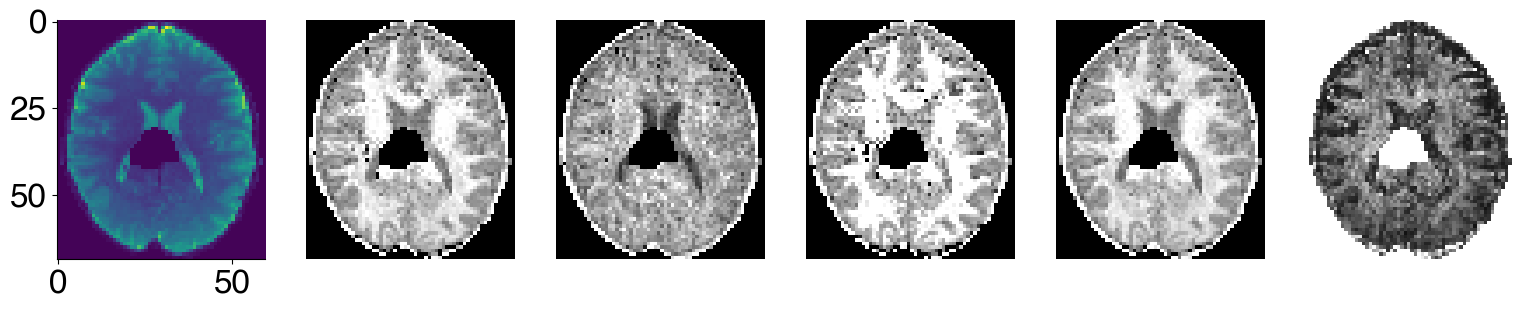

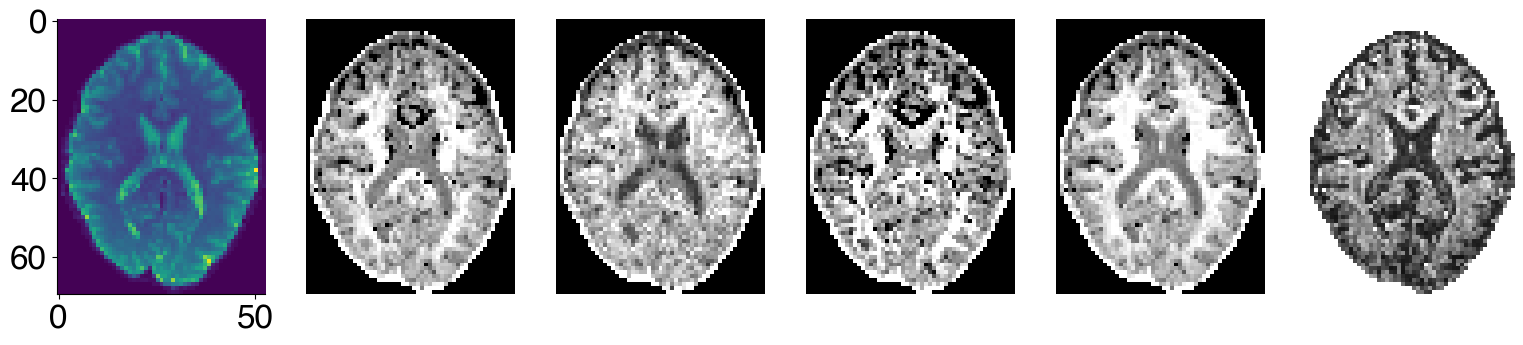

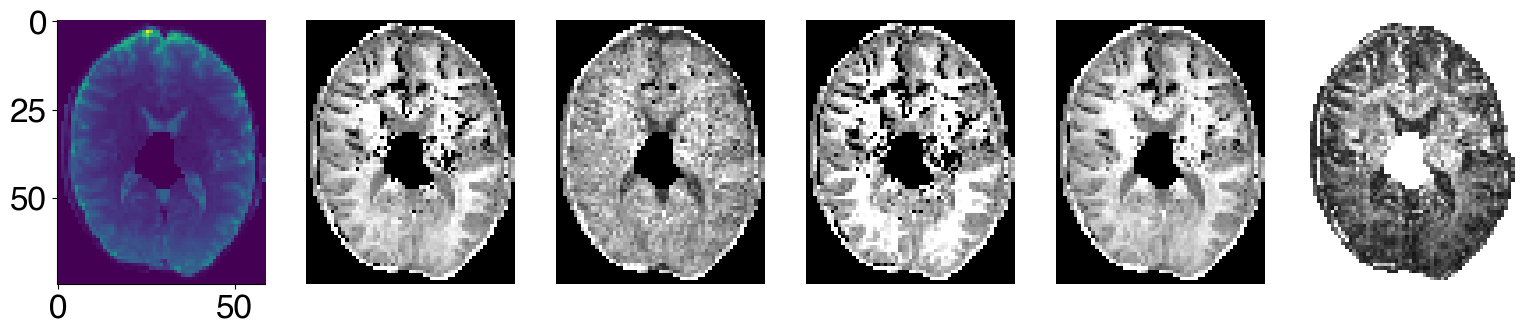

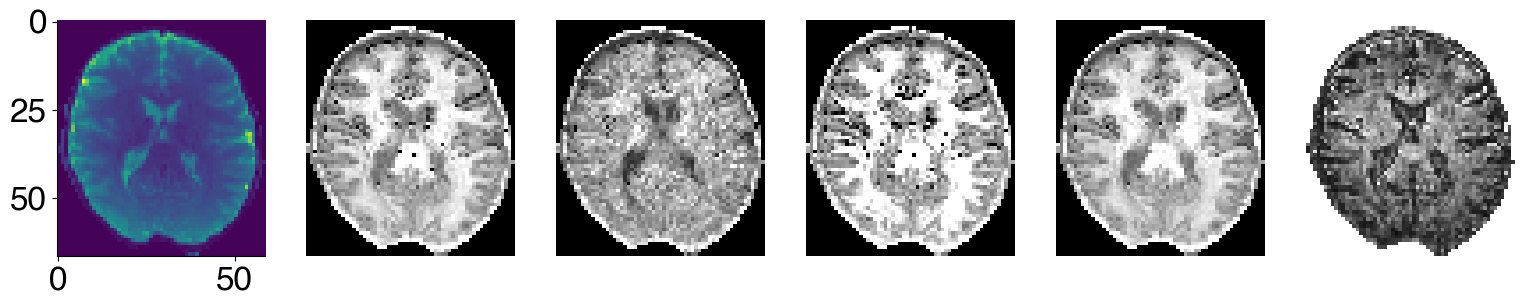

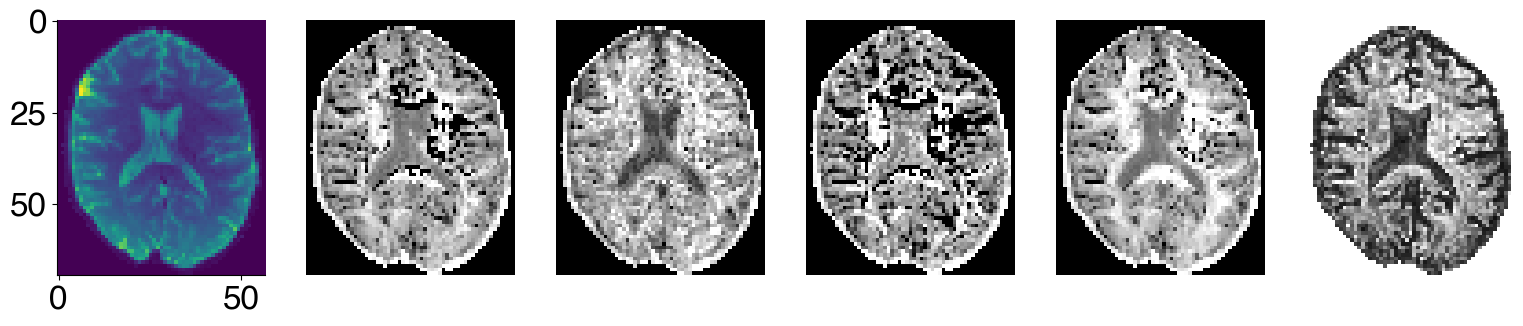

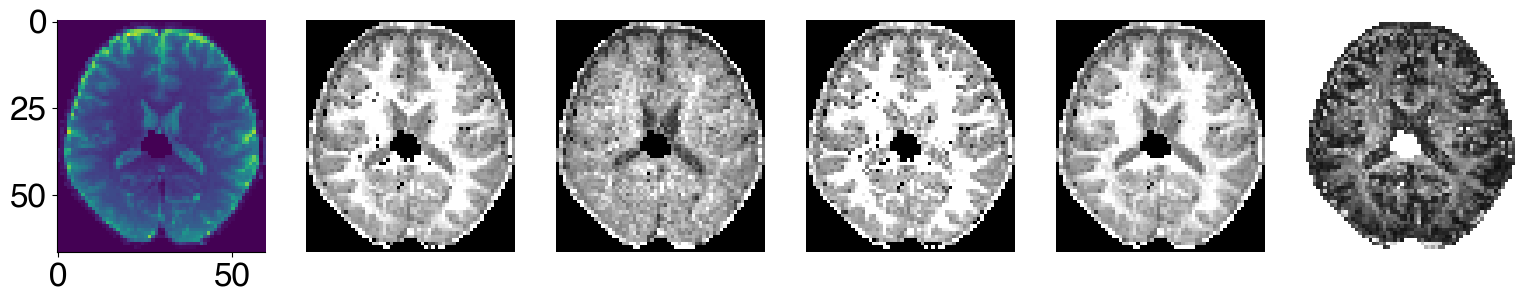

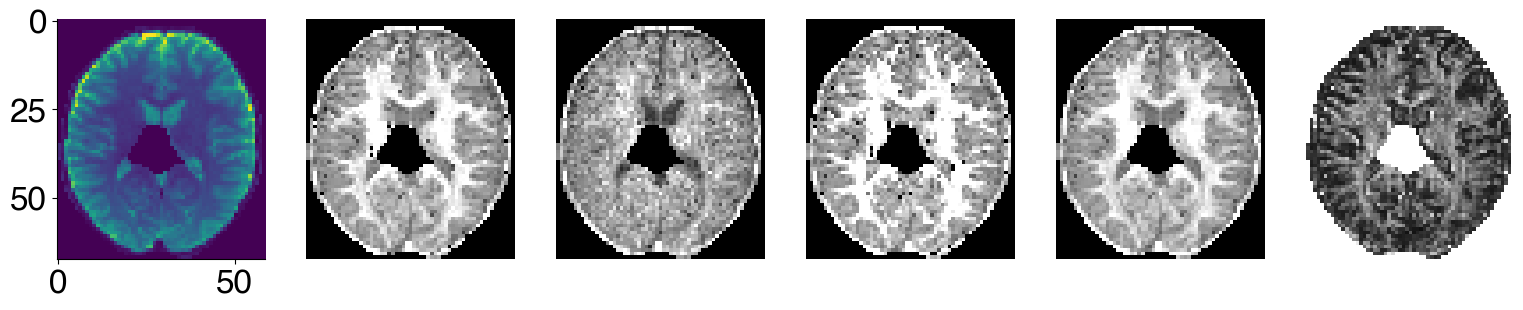

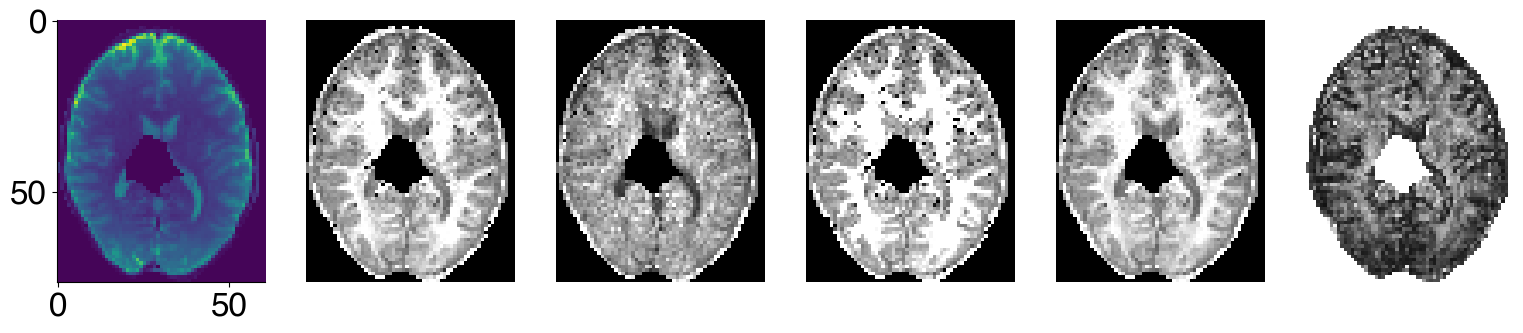

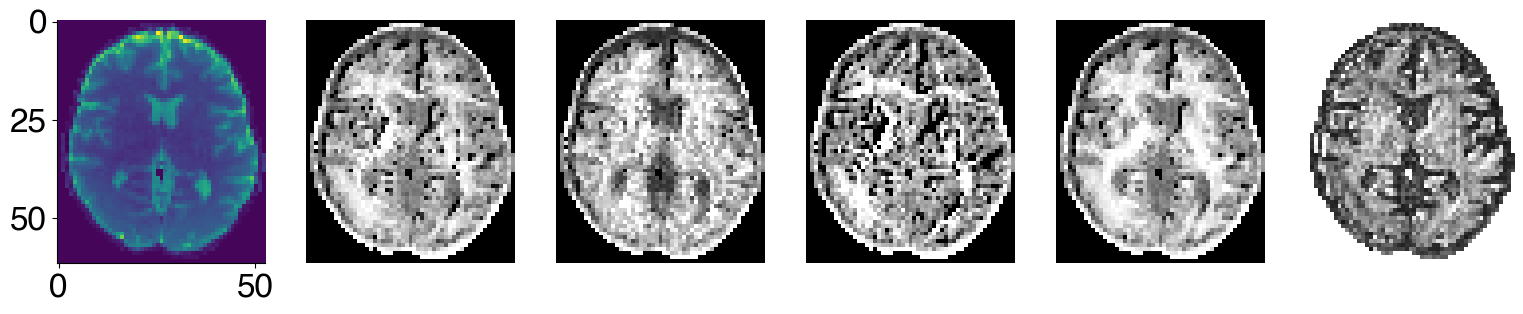

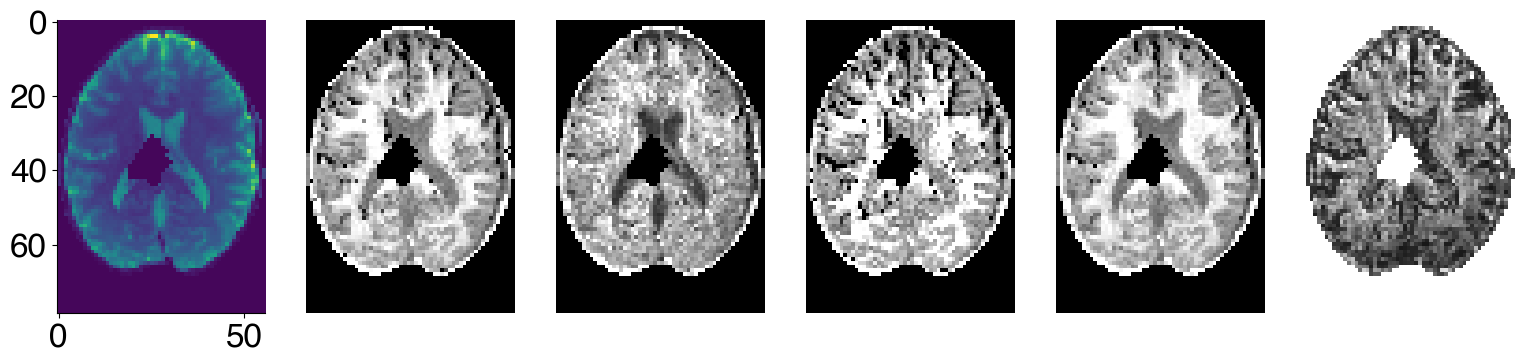

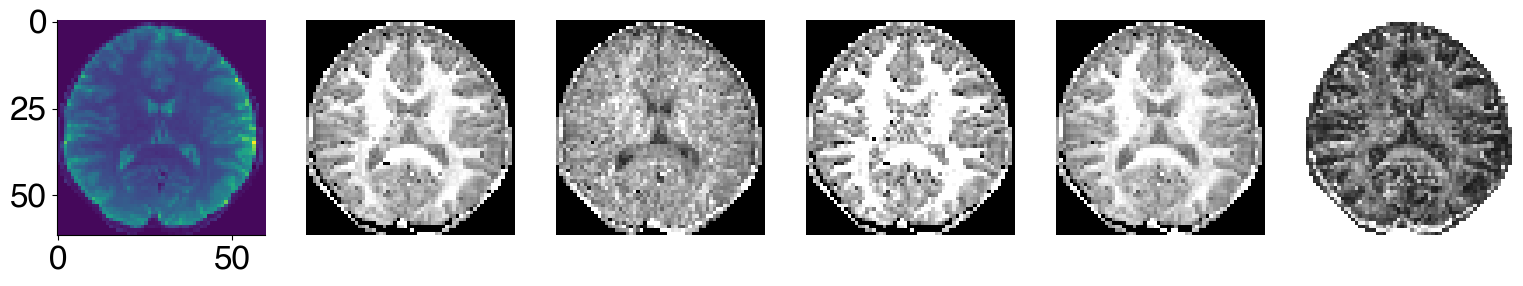

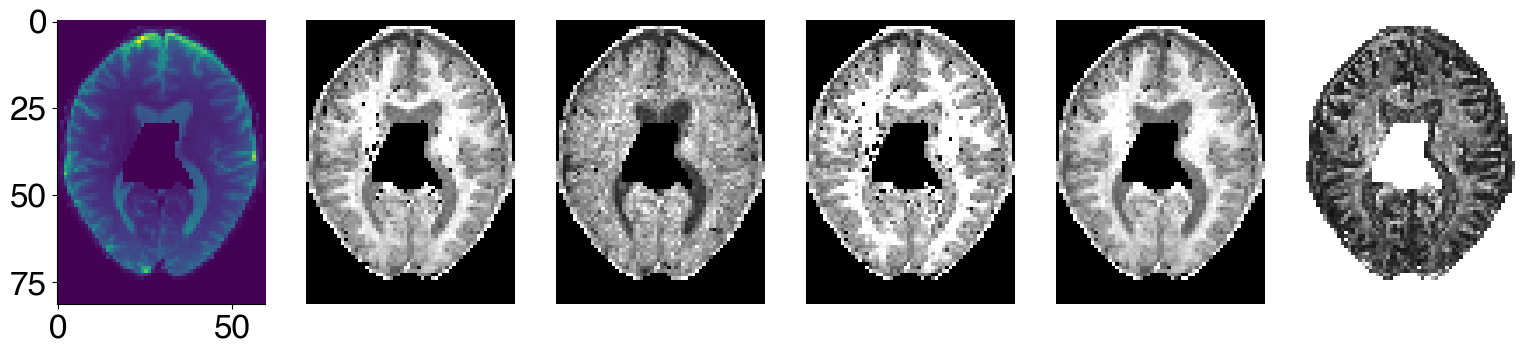

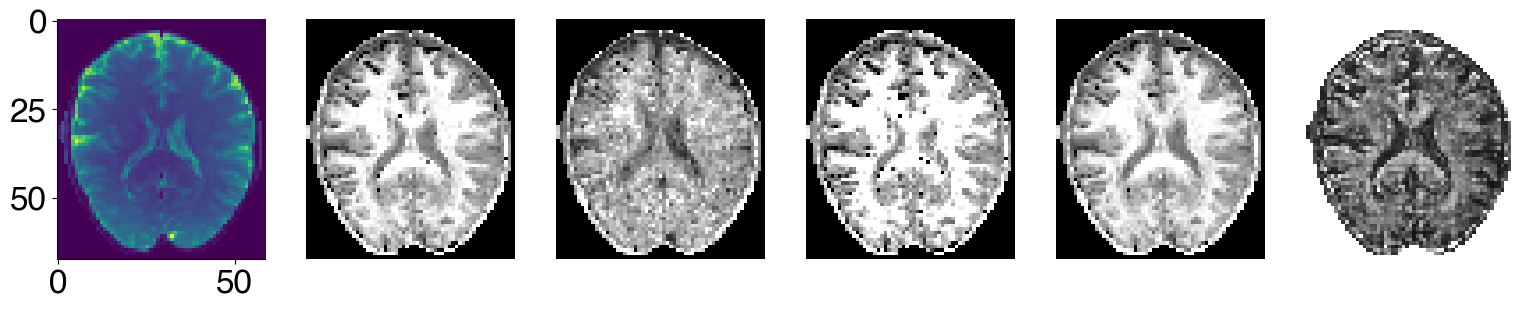

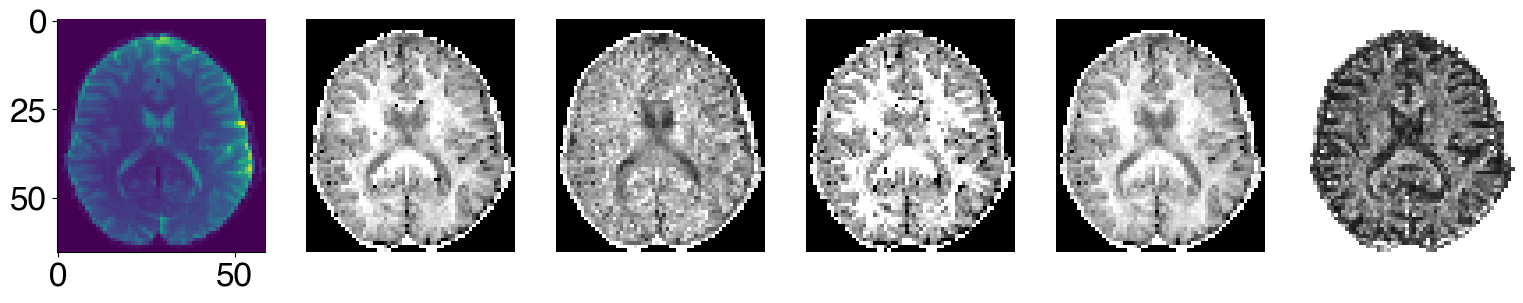

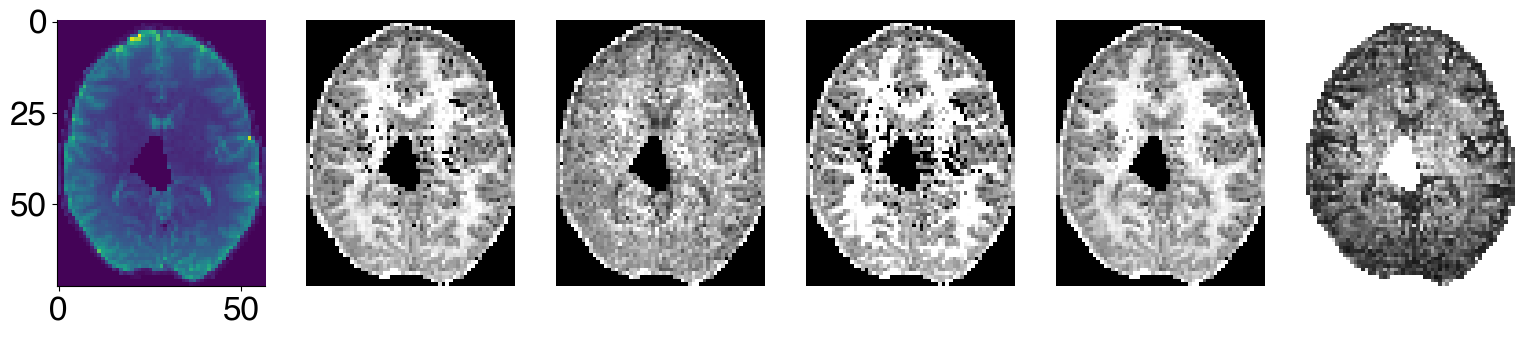

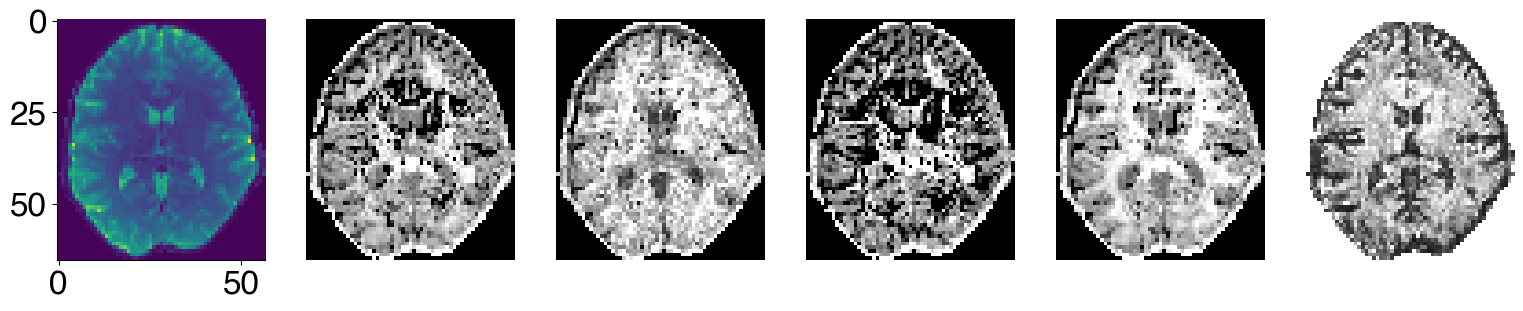

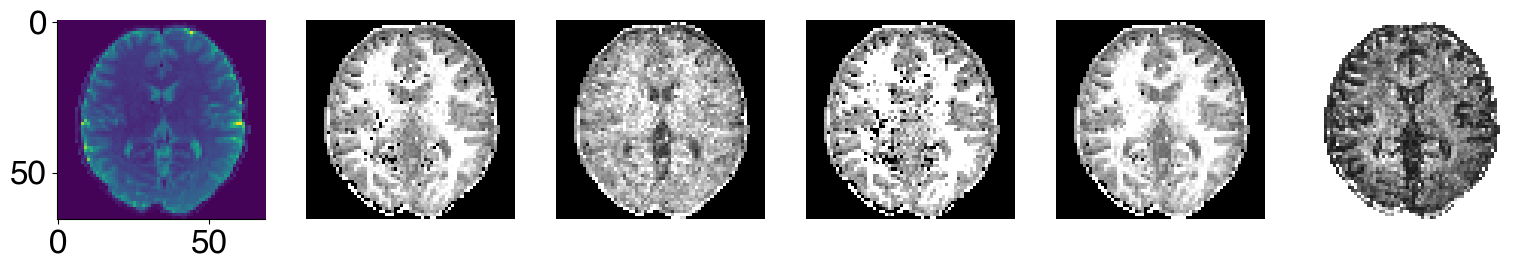

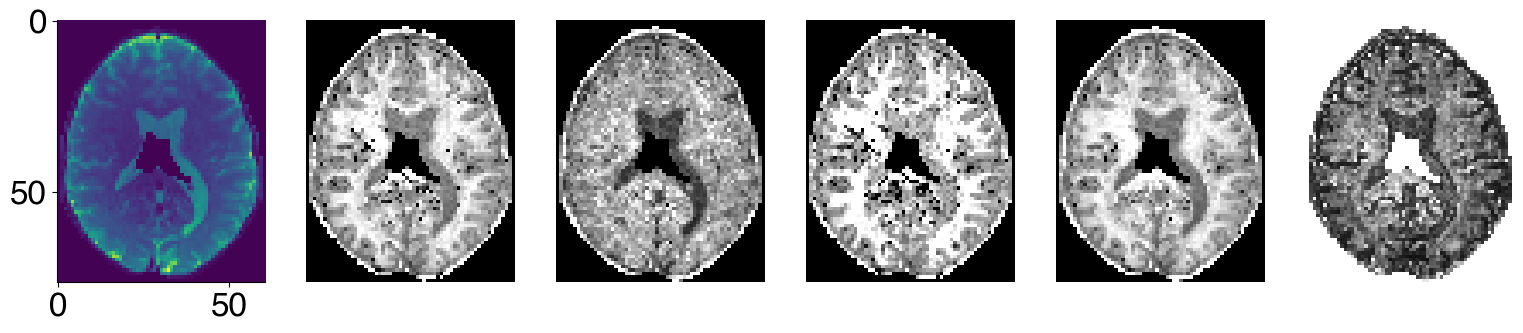

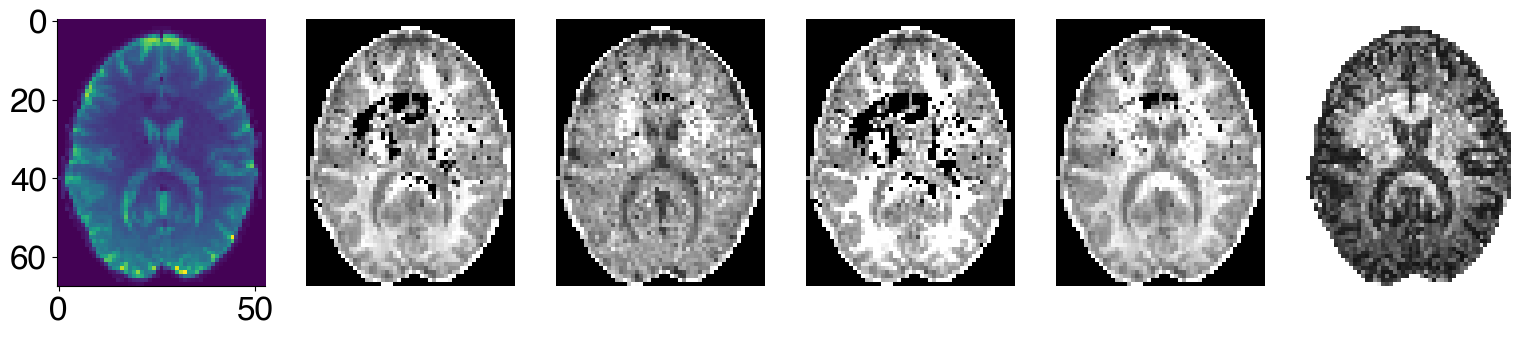

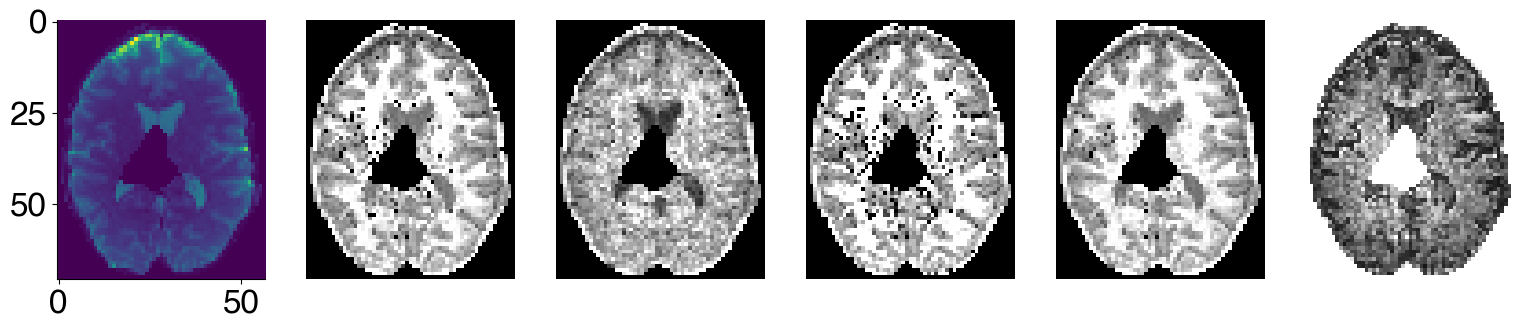

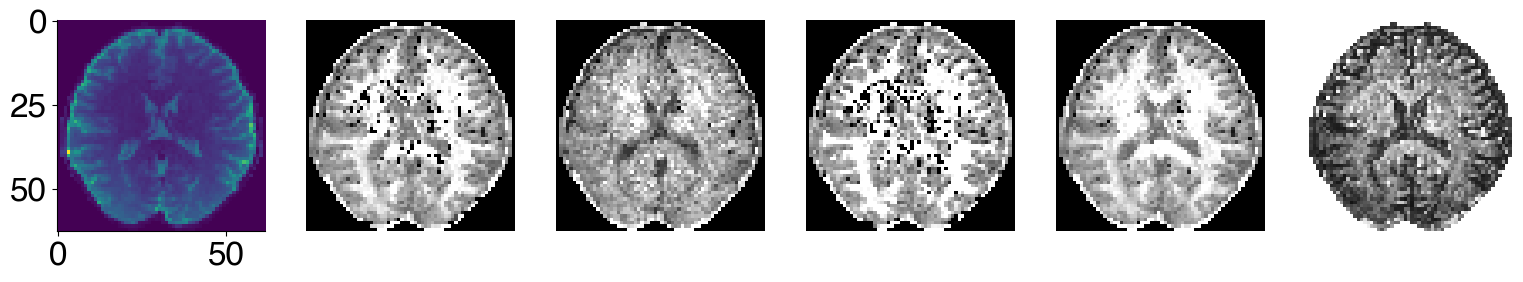

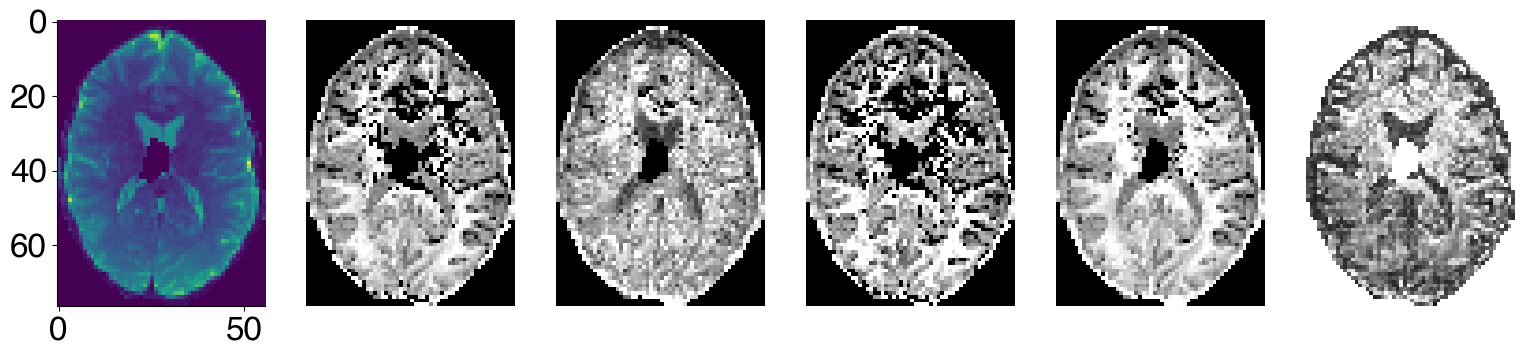

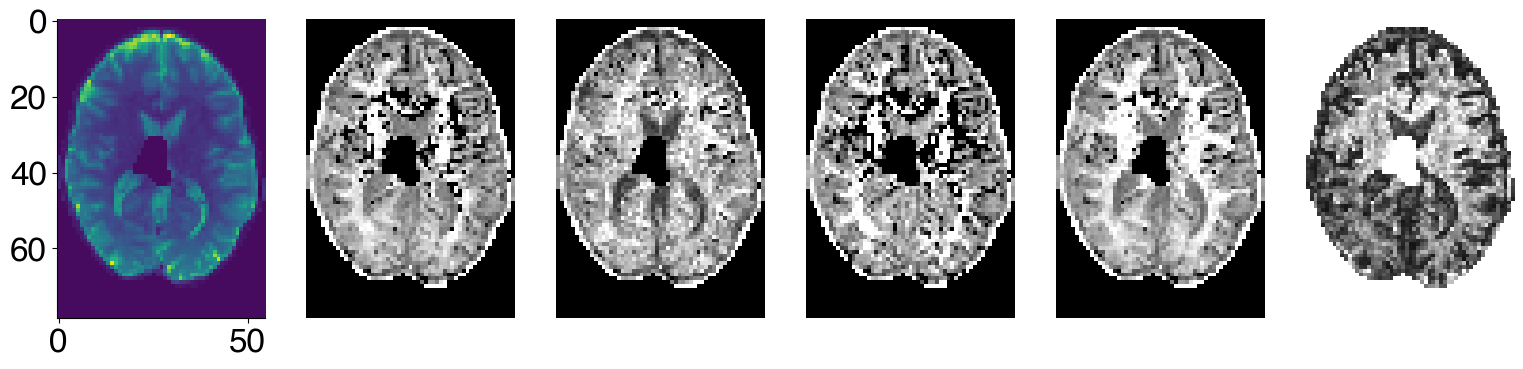

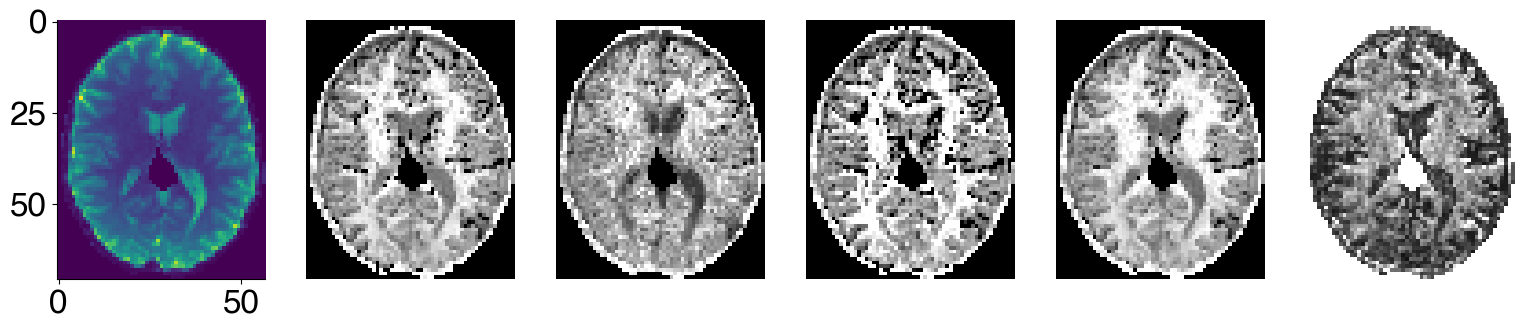

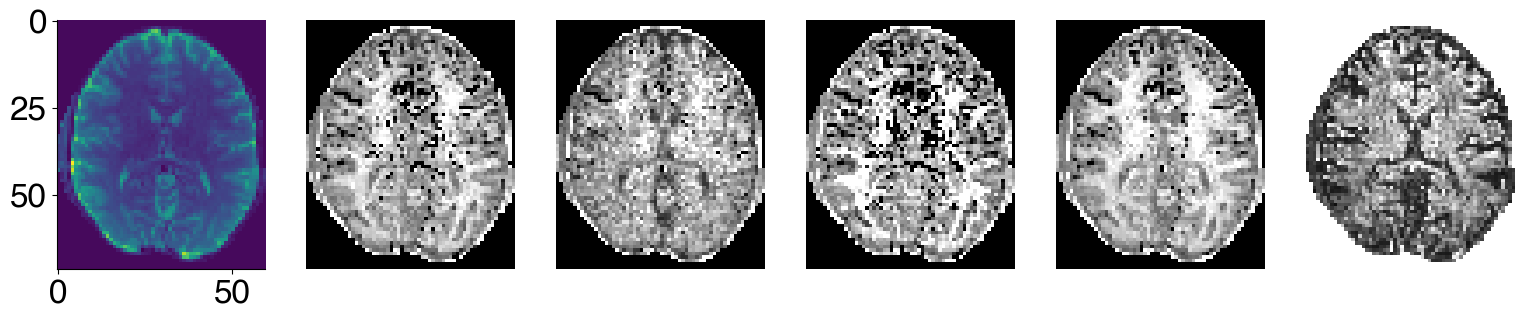

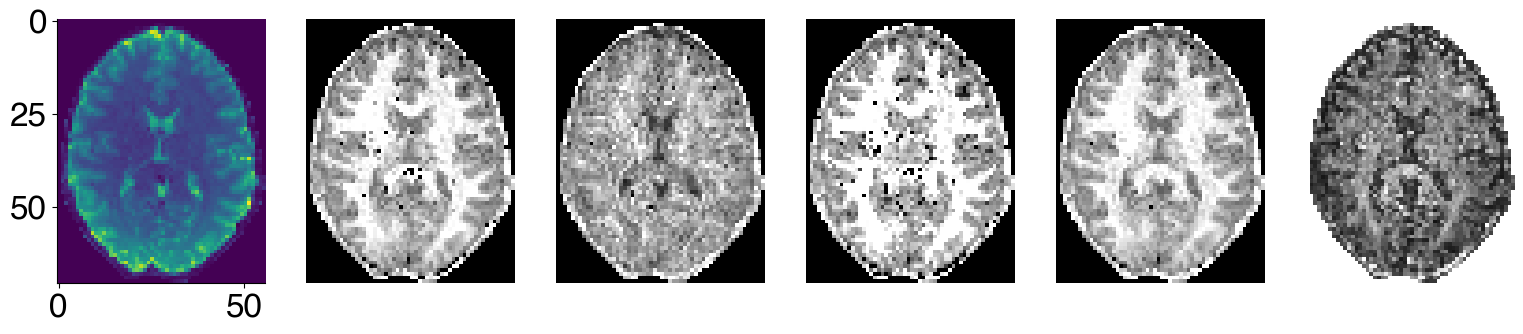

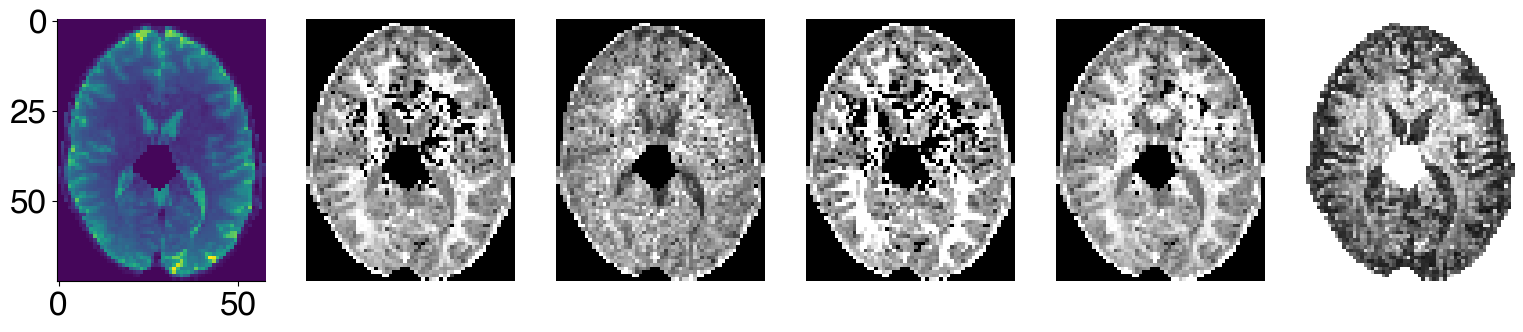

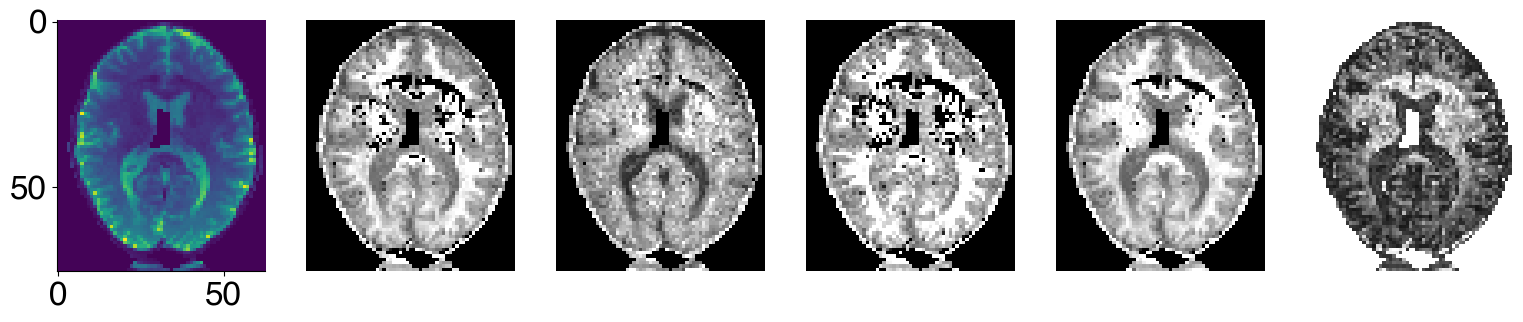

In [1115]:
MKMidArr = []
RKMidArr = []
AKMidArr = []
MKTMidArr = []
KFAMidArr = []
for kk in tqdm(range(32)):
    
    # Compute the mask where the sum is not zero
    mask = np.sum(TD[kk][:, :, axial_middles[kk], :69], axis=-1) != 0
    
    # Get the indices where mask is True
    indices = np.argwhere(mask)
    
    # Define the function for optimization
    def optimize_pixel(i, j):
        torch.manual_seed(10)  # If required
        posterior_samples_1 = posteriorMid.sample((500,), x=np.hstack([TD[kk][i, j, axial_middles[kk], selected_indices20],kk]),show_progress_bars=False)
        return i, j, np.array([histogram_mode(p) for p in posterior_samples_1.T])
    
    # Initialize NoiseEst with the appropriate shape
    ArrShape = mask.shape
    
    # Use joblib to parallelize the optimization tasks
    results = Parallel(n_jobs=-1)(
        delayed(optimize_pixel)(i, j) for i, j in indices
    )
    
    NoiseEst = np.zeros(list(ArrShape) + [22])
    
    # Assign the optimization results to NoiseEst
    for i, j, x in results:
        NoiseEst[i, j] = x
    
    NoiseEst2 =  np.zeros_like(NoiseEst)
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]):    
            NoiseEst2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst[i,j]))),NoiseEst[i,j,6:]])

    MK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    AK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    RK_SBIFull  = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    MKT_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    KFA_SBIFull = np.zeros([NoiseEst.shape[0], NoiseEst.shape[1]])
    for i in range(NoiseEst.shape[0]):
        for j in range(NoiseEst.shape[1]): 
            Metrics = DKIMetrics(NoiseEst2[i,j][:6],NoiseEst2[i,j][6:21])
            MK_SBIFull[i,j] = Metrics[0]
            AK_SBIFull[i,j] = Metrics[1]
            RK_SBIFull[i,j] = Metrics[2]
            MKT_SBIFull[i,j] = Metrics[3]
            KFA_SBIFull[i,j] = Metrics[4]
        
    fig,ax = plt.subplots(1,6,figsize=(18.8,6.4))
    ax[0].imshow(TD[kk][:,:,axial_middles[kk],0].T)
    plt.sca(ax[1])
    img = plt.imshow(MK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[2])
    img = plt.imshow(AK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[3])
    img = plt.imshow(RK_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[4])
    img = plt.imshow(MKT_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.sca(ax[5])
    img = plt.imshow(KFA_SBIFull.T,cmap='gray',vmin=0,vmax=1)
    plt.axis('off')
    plt.show()

    MKMidArr.append(MK_SBIFull)
    RKMidArr.append(RK_SBIFull)
    AKMidArr.append(AK_SBIFull)
    MKTMidArr.append(MKT_SBIFull)
    KFAMidArr.append(KFA_SBIFull)

In [1117]:
gTabsF = []
gTabs7 = []
gTabs20 = []

FullDat   = []

for i in tqdm(range(1,33)):
    fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
    bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
    bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'
    
    fdwi3 = './HCP_data/Pat'+str(i)+'/diff_3k.nii.gz'
    bvalloc3 = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
    bvecloc3 = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'
    
    bvalsHCP = np.loadtxt(bvalloc)
    bvecsHCP = np.loadtxt(bvecloc)
    gtabHCP = gradient_table(bvalsHCP, bvecsHCP)
    
    bvalsHCP3 = np.loadtxt(bvalloc3)
    bvecsHCP3 = np.loadtxt(bvecloc3)
    gtabHCP3 = gradient_table(bvalsHCP3, bvecsHCP3)
    
    gtabExt  = gradient_table(np.hstack((bvalsHCP,bvalsHCP3)), np.vstack((bvecsHCP,bvecsHCP3)))
    gTabsF.append(gtabExt)
    
    bvalsHCP7 = gtabExt.bvals[selected_indices7]
    bvecsHCP7 = gtabExt.bvecs[selected_indices7]
    gtabHCP7 = gradient_table(bvalsHCP7, bvecsHCP7)
    gTabs7.append(gtabHCP7)

    bvalsHCP20 = gtabExt.bvals[selected_indices20]
    bvecsHCP20 = gtabExt.bvecs[selected_indices20]
    gtabHCP20 = gradient_table(bvalsHCP20, bvecsHCP20)
    gTabs20.append(gtabHCP20)

  0%|          | 0/32 [00:00<?, ?it/s]

In [1118]:
MKFullNLArr = []
RKFullNLArr = []
AKFullNLArr = []
MKTFullNLArr = []
KFAFullNLArr = []
for kk in tqdm(range(32)):
    dkimodelNL = dki.DiffusionKurtosisModel(gTabsF[kk],fit_method='NLLS')
    dkifitNL = dkimodelNL.fit(TD[kk][:,:,axial_middles[kk]])
    ArrShape = TD[kk][:,:,axial_middles[kk],0].shape
    NoiseEst_NL = np.zeros(list(ArrShape)+[21])
    MK_NL7  = np.zeros(ArrShape)
    AK_NL7  = np.zeros(ArrShape)
    RK_NL7 = np.zeros(ArrShape)
    MKT_NL7 = np.zeros(ArrShape)
    KFA_NL7 = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL[i,j] = np.hstack([dkifitNL[i,j].lower_triangular(),dkifitNL[i,j].kt])
    NoiseEst_NL2 =  np.zeros_like(NoiseEst_NL)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst_NL[i,j]))),NoiseEst_NL[i,j,6:]])
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            Metrics = DKIMetrics(NoiseEst_NL2[i,j][:6],NoiseEst_NL2[i,j][6:21])
            MK_NL7[i,j] = Metrics[0]
            AK_NL7[i,j] = Metrics[1]
            RK_NL7[i,j] = Metrics[2]
            MKT_NL7[i,j] = Metrics[3]
            KFA_NL7[i,j] = Metrics[4]
    MKFullNLArr.append(MK_NL7)
    RKFullNLArr.append(RK_NL7)
    AKFullNLArr.append(AK_NL7)
    MKTFullNLArr.append(MKT_NL7)
    KFAFullNLArr.append(KFA_NL7)

  0%|          | 0/32 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1598: RuntimeWarning: overflow encountered in exp
  y = np.exp(np.dot(design_matrix, tensor))
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1826: RuntimeWarning: divide by zero encountered in divide
  params[vox, 12:] = this_param[6:-1] / md2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  dt[0] = DTI[0,0]
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  dt[1] = DTI[0,1]
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  dt[2] = DTI[1,1]
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_B

In [1119]:
MKMidNLArr = []
RKMidNLArr = []
AKMidNLArr = []
MKTMidNLArr = []
KFAMidNLArr = []
for kk in tqdm(range(32)):
    dkimodelNL = dki.DiffusionKurtosisModel(gTabs20[kk],fit_method='NLLS')
    dkifitNL = dkimodelNL.fit(TD[kk][:,:,axial_middles[kk],selected_indices20])
    ArrShape = TD[kk][:,:,axial_middles[kk],0].shape
    NoiseEst_NL = np.zeros(list(ArrShape)+[21])
    MK_NL7  = np.zeros(ArrShape)
    AK_NL7  = np.zeros(ArrShape)
    RK_NL7 = np.zeros(ArrShape)
    MKT_NL7 = np.zeros(ArrShape)
    KFA_NL7 = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL[i,j] = np.hstack([dkifitNL[i,j].lower_triangular(),dkifitNL[i,j].kt])
    NoiseEst_NL2 =  np.zeros_like(NoiseEst_NL)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst_NL[i,j]))),NoiseEst_NL[i,j,6:]])
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            Metrics = DKIMetrics(NoiseEst_NL2[i,j][:6],NoiseEst_NL2[i,j][6:21])
            MK_NL7[i,j] = Metrics[0]
            AK_NL7[i,j] = Metrics[1]
            RK_NL7[i,j] = Metrics[2]
            MKT_NL7[i,j] = Metrics[3]
            KFA_NL7[i,j] = Metrics[4]
    MKMidNLArr.append(MK_NL7)
    RKMidNLArr.append(RK_NL7)
    AKMidNLArr.append(AK_NL7)
    MKTMidNLArr.append(MKT_NL7)
    KFAMidNLArr.append(KFA_NL7)

  0%|          | 0/32 [00:00<?, ?it/s]

In [1120]:
MKMinNLArr = []
RKMinNLArr = []
AKMinNLArr = []
MKTMinNLArr = []
KFAMinNLArr = []
for kk in tqdm(range(32)):
    dkimodelNL = dki.DiffusionKurtosisModel(gTabs7[kk],fit_method='NLLS')
    dkifitNL = dkimodelNL.fit(TD[kk][:,:,axial_middles[kk],selected_indices7])
    ArrShape = TD[kk][:,:,axial_middles[kk],0].shape
    NoiseEst_NL = np.zeros(list(ArrShape)+[21])
    MK_NL7  = np.zeros(ArrShape)
    AK_NL7  = np.zeros(ArrShape)
    RK_NL7 = np.zeros(ArrShape)
    MKT_NL7 = np.zeros(ArrShape)
    KFA_NL7 = np.zeros(ArrShape)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL[i,j] = np.hstack([dkifitNL[i,j].lower_triangular(),dkifitNL[i,j].kt])
    NoiseEst_NL2 =  np.zeros_like(NoiseEst_NL)
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            NoiseEst_NL2[i,j] = np.hstack([mat_to_vals(clip_negative_eigenvalues(vals_to_mat(NoiseEst_NL[i,j]))),NoiseEst_NL[i,j,6:]])
    for i in range(ArrShape[0]):
        for j in range(ArrShape[1]):
            Metrics = DKIMetrics(NoiseEst_NL2[i,j][:6],NoiseEst_NL2[i,j][6:21])
            MK_NL7[i,j] = Metrics[0]
            AK_NL7[i,j] = Metrics[1]
            RK_NL7[i,j] = Metrics[2]
            MKT_NL7[i,j] = Metrics[3]
            KFA_NL7[i,j] = Metrics[4]
    MKMinNLArr.append(MK_NL7)
    RKMinNLArr.append(RK_NL7)
    AKMinNLArr.append(AK_NL7)
    MKTMinNLArr.append(MKT_NL7)
    KFAMinNLArr.append(KFA_NL7)

  0%|          | 0/32 [00:00<?, ?it/s]

In [1574]:
DatFolder

'/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/SavedDat/'

In [1372]:
MKMinArr = np.load(DatFolder+'Min_MK_HCP.npy',allow_pickle=True)
MKMidArr = np.load(DatFolder+'Mid_MK_HCP.npy',allow_pickle=True)
MKFullArr = np.load(DatFolder+'Full_MK_HCP.npy',allow_pickle=True)

AKMinArr = np.load(DatFolder+'Min_AK_HCP.npy',allow_pickle=True)
AKMidArr = np.load(DatFolder+'Mid_AK_HCP.npy',allow_pickle=True)
AKFullArr = np.load(DatFolder+'Full_AK_HCP.npy',allow_pickle=True)

RKMinArr = np.load(DatFolder+'Min_RK_HCP.npy',allow_pickle=True)
RKMidArr = np.load(DatFolder+'Mid_RK_HCP.npy',allow_pickle=True)
RKFullArr = np.load(DatFolder+'Full_RK_HCP.npy',allow_pickle=True)

In [1122]:
#np.save(DatFolder+'Min_MK_HCP_mode',np.array(MKMinArr,dtype=object))
#np.save(DatFolder+'Mid_MK_HCP_mode',np.array(MKMidArr,dtype=object))
#np.save(DatFolder+'Full_MK_HCP_mode',np.array(MKFullArr,dtype=object))

#np.save(DatFolder+'Min_AK_HCP_mode',np.array(AKMinArr,dtype=object))
#np.save(DatFolder+'Mid_AK_HCP_mode',np.array(AKMidArr,dtype=object))
#np.save(DatFolder+'Full_AK_HCP_mode',np.array(AKFullArr,dtype=object))

#np.save(DatFolder+'Min_RK_HCP_mode',np.array(RKMinArr,dtype=object))
#np.save(DatFolder+'Mid_RK_HCP_mode',np.array(RKMidArr,dtype=object))
#np.save(DatFolder+'Full_RK_HCP_mode',np.array(RKFullArr,dtype=object))

#np.save(DatFolder+'Min_MKT_HCP_mode',np.array(MKTMinArr,dtype=object))
#np.save(DatFolder+'Mid_MKT_HCP_mode',np.array(MKTMidArr,dtype=object))
#np.save(DatFolder+'Full_MKT_HCP_mode',np.array(MKTFullArr,dtype=object))

#np.save(DatFolder+'Min_KFA_HCP_mode',np.array(KFAMinArr,dtype=object))
#np.save(DatFolder+'Mid_KFA_HCP_mode',np.array(KFAMidArr,dtype=object))
#np.save(DatFolder+'Full_KFA_HCP_mode',np.array(KFAFullArr,dtype=object))

In [1373]:
AccM7 = []
for i in range(32):
    M7 =MKMinArr[i]
    MF =MKFullArr[i]
    Ma = masks[i]
    AccM7.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20 = []
for i in range(32):
    M7 =MKMidArr[i]
    MF =MKFullArr[i]
    Ma = masks[i]
    AccM20.append(np.mean(np.abs(M7-MF)[Ma]))

AccMFulls = []
for i in range(32):
    M7 =MKFullArr[i]
    MF =MKFullNLArr[i]
    Ma = masks[i]
    AccMFulls.append(np.mean(np.abs(M7-MF)[Ma]))

AccM7NL = []
for i in range(32):
    M7 =MKMinNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =MKFullNLArr[i]
    Ma = masks[i]
    AccM7NL.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20NL = []
for i in range(32):
    M7 =MKMidNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =MKFullNLArr[i]
    Ma = masks[i]
    AccM20NL.append(np.nanmean(np.abs(M7-MF)[Ma]))

SSIM7 = []
SSIM20 = []
SSIMFulls = []

SSIM7NL = []
SSIM20NL = []
for i in tqdm(range(32)):
    NS1 =MKMinArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =MKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7.append(result)

    NS1 =MKMidArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =MKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20.append(result)
    
    NS1 =MKFullArr[i]
    NS2 =MKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIMFulls.append(result)

    NS1 =MKMinNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =MKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7NL.append(result)

    NS1 =MKMidNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =MKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20NL.append(result)





  0%|          | 0/32 [00:00<?, ?it/s]

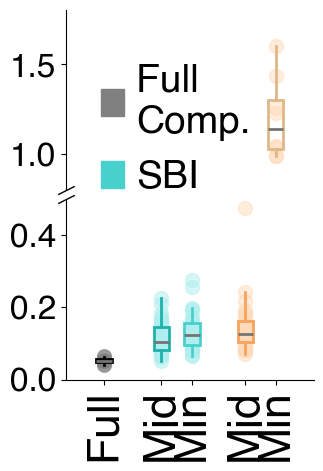

In [1448]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(3.2,4.8))
fig.subplots_adjust(hspace=0.05)



y_data = np.array(AccM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(AccMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20)
g_pos = np.array([1.55])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20NL)
g_pos = np.array([2.65])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

plt.xticks([0.8,1.55,1.95,2.65,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
#ax1.set_ylim(0.4, 1)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax1.yaxis.set_ticks([0.4,0.7,1])
ax1.set_xticks([])

plt.yticks(fontsize=24)

#ax2.set_ylim(0.0,0.3)
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax2.yaxis.set_ticks(np.arange(0, 0.0001, 0.00004))

# Common x-ticks
#ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2
ax1.set_xlim(np.array(ax2.get_xlim()))

# Show plot
ax2.set_ylim(0,0.5)
ax2.set_yticks([0,0.2,0.4])
ax1.set_ylim(0.8,1.8)

leg_patch2 = mpatches.Patch(color='mediumturquoise', label='SBI')
leg_patch3 = mpatches.Patch(color='sandybrown', label='NLLS')
leg_patch5 = mpatches.Patch(color='gray', label='Full \nComp.')

ax1.legend(
    handles=[leg_patch5,leg_patch2],
    loc='upper left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=28,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor= (-0.0,0.9))

if Save: plt.savefig(FigLoc+'DKIHCP_Acc_MK.pdf',format='PDF',transparent=True,bbox_inches='tight')
plt.show()

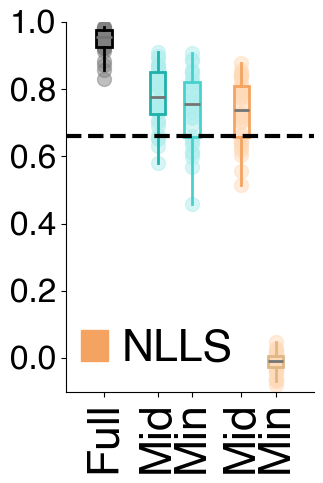

In [1460]:
fig, ax = plt.subplots(figsize=(3.2,4.8))#, sharex=True)

# Plotting on ax1
plt.sca(ax)
y_data = np.array(SSIMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20)
g_pos = np.array([1.5])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True,scatter_alpha=0.5)

y_data = np.array(SSIM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20NL)
g_pos = np.array([2.6])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

plt.axhline(0.66, lw=3, ls='--', c='k')
plt.xticks([0.8,1.5,1.95,2.6,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(-0.1,1)

ax.legend(
    handles=[leg_patch3],
    loc='lower left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor= (-0.1,-0.05))

if Save: plt.savefig(FigLoc+'DKIHCP_SSIM_MK.pdf',format='PDF',transparent=True,bbox_inches='tight')

In [1403]:
Prec7_SBI = []
Prec20_SBI = []
PrecFull_SBI = []

Prec7_NLLS = []
Prec20_NLLS = []
PrecFull_NLLS = []
for i in range(32):
    Prec7_SBI.append(np.std(MKMinArr[i][WMs[i]]))
    Prec20_SBI.append(np.std(MKMidArr[i][WMs[i]]))
    PrecFull_SBI.append(np.std(MKFullArr[i][WMs[i]]))

    Prec7_NLLS.append(np.std(MKMinNLArr[i][WMs[i]]))
    Prec20_NLLS.append(np.std(MKMidNLArr[i][WMs[i]]))
    PrecFull_NLLS.append(np.std(MKFullNLArr[i][WMs[i]]))


/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
y_data = np.array(PrecFull_SBI)
g_pos = np.array([1])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']
fig,ax = plt.subplots()
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

colors = ['sandybrown']
colors2 = ['peachpuff']
y_data = np.array(PrecFull_NLLS)
g_pos = np.array([2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.4])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

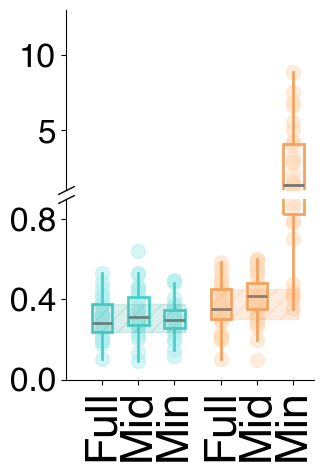

In [1489]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(3.2,4.8))
fig.subplots_adjust(hspace=0.05)



y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.5])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(PrecFull_SBI)
g_pos = np.array([0.65])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1.0])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.35])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(PrecFull_NLLS)
g_pos = np.array([1.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.15])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.5])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
#ax1.set_ylim(0.4, 1)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax1.yaxis.set_ticks([0.4,0.7,1])
ax1.set_xticks([])

plt.yticks(fontsize=24)

#ax2.set_ylim(0.0,0.3)
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax2.yaxis.set_ticks(np.arange(0, 0.0001, 0.00004))

# Common x-ticks
#ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2
ax2.set_xlim([0.3,2.7])
ax1.set_xlim(ax2.get_xlim())
# Show plot
ax2.set_ylim(0,0.9)
ax2.set_yticks([0,0.4,0.8])
ax1.set_ylim(1,13)

x = np.arange(1.7,2.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 77)
plt.fill_between(x,y1,y2,color=WLSFit,zorder=10,alpha=0.2,hatch='//')

x = np.arange(0.55,1.5,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 77)
plt.fill_between(x,y1,y2,color=SBIFit,zorder=10,alpha=0.2,hatch='//')

plt.xticks([0.65,1,1.35,1.8,2.15,2.5],['Full','Mid','Min','Full','Mid','Min'],fontsize=32,rotation=90)
if Save: plt.savefig(FigLoc+'DKI_MK_Prec.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

In [1491]:
AccM7 = []
for i in range(32):
    M7 =AKMinArr[i]
    MF =AKFullArr[i]
    Ma = masks[i]
    AccM7.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20 = []
for i in range(32):
    M7 =AKMidArr[i]
    MF =AKFullArr[i]
    Ma = masks[i]
    AccM20.append(np.mean(np.abs(M7-MF)[Ma]))

AccMFulls = []
for i in range(32):
    M7 =AKFullArr[i]
    MF =AKFullNLArr[i]
    Ma = masks[i]
    AccMFulls.append(np.mean(np.abs(M7-MF)[Ma]))

AccM7NL = []
for i in range(32):
    M7 =AKMinNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =AKFullNLArr[i]
    Ma = masks[i]
    AccM7NL.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20NL = []
for i in range(32):
    M7 =AKMidNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =AKFullNLArr[i]
    Ma = masks[i]
    AccM20NL.append(np.nanmean(np.abs(M7-MF)[Ma]))


SSIM7 = []
SSIM20 = []
SSIMFulls = []

SSIM7NL = []
SSIM20NL = []
for i in tqdm(range(32)):
    NS1 =AKMinArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =AKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7.append(result)

    NS1 =AKMidArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =AKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20.append(result)
    
    NS1 =AKFullArr[i]
    NS2 =AKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIMFulls.append(result)

    NS1 =AKMinNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =AKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7NL.append(result)

    NS1 =AKMidNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =AKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20NL.append(result)





  0%|          | 0/32 [00:00<?, ?it/s]

In [1493]:
SSIM7 = []
for i in tqdm(range(32)):
    NS1 =AKMinArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =AKFullArr[i]
    NS2 = gaussian_filter(NS2, sigma=0.5)
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7.append(result)

  0%|          | 0/32 [00:00<?, ?it/s]

In [1496]:
Prec7_SBI = []
Prec20_SBI = []
PrecFull_SBI = []

Prec7_NLLS = []
Prec20_NLLS = []
PrecFull_NLLS = []
for i in range(32):
    Prec7_SBI.append(np.std(AKMinArr[i][WMs[i]]))
    Prec20_SBI.append(np.std(AKMidArr[i][WMs[i]]))
    PrecFull_SBI.append(np.std(AKFullArr[i][WMs[i]]))

    Prec7_NLLS.append(np.std(AKMinNLArr[i][WMs[i]]))
    Prec20_NLLS.append(np.std(AKMidNLArr[i][WMs[i]]))
    PrecFull_NLLS.append(np.std(AKFullNLArr[i][WMs[i]]))


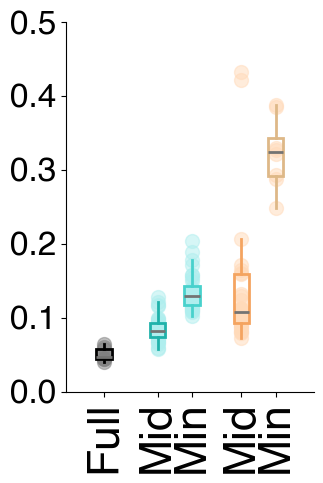

In [1502]:
fig, ax1 = plt.subplots(1, 1,figsize=(3.2,4.8))
fig.subplots_adjust(hspace=0.05)




y_data = np.array(AccMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(AccM20)
g_pos = np.array([1.5])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(AccM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(AccM20NL)
g_pos = np.array([2.6])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)

y_data = np.array(AccM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
plt.xticks([0.8,1.5,1.95,2.6,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)
ax1.set_ylim(0., 0.5)

if Save: plt.savefig(FigLoc+'DKIHCP_Acc_AK.pdf',format='PDF',transparent=True,bbox_inches='tight')

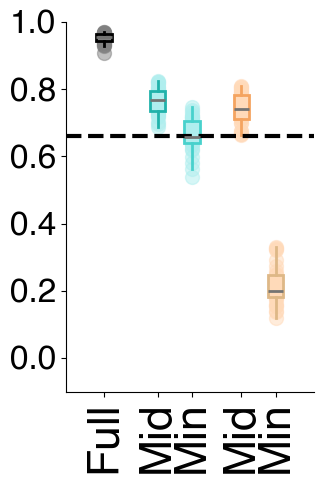

In [1504]:
fig, ax = plt.subplots(figsize=(3.2,4.8))#, sharex=True)

# Plotting on ax1
plt.sca(ax)
y_data = np.array(SSIMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20)
g_pos = np.array([1.5])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True,scatter_alpha=0.5)

y_data = np.array(SSIM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20NL)
g_pos = np.array([2.6])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

plt.axhline(0.66, lw=3, ls='--', c='k')
plt.xticks([0.8,1.5,1.95,2.6,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(-0.1,1)

if Save: plt.savefig(FigLoc+'DKIHCP_SSIM_AK.pdf',format='PDF',transparent=True,bbox_inches='tight')

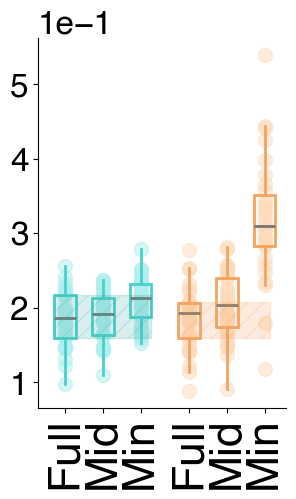

In [1515]:
fig,ax = plt.subplots(figsize=(3.2,4.8))
y_data = np.array(PrecFull_SBI)
g_pos = np.array([0.65])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.35])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

colors = ['sandybrown']
colors2 = ['peachpuff']
y_data = np.array(PrecFull_NLLS)
g_pos = np.array([1.8])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.15])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.5])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

x = np.arange(1.7,2.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 77)
plt.fill_between(x,y1,y2,color=WLSFit,zorder=10,alpha=0.2,hatch='//')

x = np.arange(0.55,1.5,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 77)
plt.fill_between(x,y1,y2,color=SBIFit,zorder=10,alpha=0.2,hatch='//')

plt.xticks([0.65,1,1.35,1.8,2.15,2.5],['Full','Mid','Min','Full','Mid','Min'],fontsize=32,rotation=90)
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
plt.yticks(fontsize=24)
ax.set_xlim([0.4,2.7])
if Save: plt.savefig(FigLoc+'DKI_AK_Prec.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [1516]:
AccM7 = []
for i in range(32):
    M7 =RKMinArr[i]
    MF =RKFullArr[i]
    Ma = masks[i]
    AccM7.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20 = []
for i in range(32):
    M7 =RKMidArr[i]
    MF =RKFullArr[i]
    Ma = masks[i]
    AccM20.append(np.mean(np.abs(M7-MF)[Ma]))

AccMFulls = []
for i in range(32):
    M7 =RKFullArr[i]
    MF =RKFullNLArr[i]
    Ma = masks[i]
    AccMFulls.append(np.mean(np.abs(M7-MF)[Ma]))

AccM7NL = []
for i in range(32):
    M7 =RKMinNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =RKFullNLArr[i]
    Ma = masks[i]
    AccM7NL.append(np.mean(np.abs(M7-MF)[Ma]))

AccM20NL = []
for i in range(32):
    M7 =RKMidNLArr[i]
    M7[np.isnan(M7)] = 0
    MF =RKFullNLArr[i]
    Ma = masks[i]
    AccM20NL.append(np.nanmean(np.abs(M7-MF)[Ma]))
    
SSIM7 = []
SSIM20 = []
SSIMFulls = []

SSIM7NL = []
SSIM20NL = []

for i in tqdm(range(32)):
    NS1 =RKMinArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =RKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7.append(result)

    NS1 =RKMidArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =RKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20.append(result)
    
    NS1 =RKFullArr[i]
    NS2 =RKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIMFulls.append(result)

    NS1 =RKMinNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =RKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7NL.append(result)

    NS1 =RKMidNLArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =RKFullNLArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM20NL.append(result)




  0%|          | 0/32 [00:00<?, ?it/s]

In [1521]:
SSIM7 = []

for i in tqdm(range(32)):
    NS1 =RKMinArr[i]
    NS1 = gaussian_filter(NS1, sigma=0.5)
    NS2 =RKFullArr[i]
    Ma = masks[i]
    result = masked_local_ssim(NS1, NS2, Ma, win_size=7,dat_range=1)
    SSIM7.append(result)

  0%|          | 0/32 [00:00<?, ?it/s]

In [1517]:
Prec7_SBI = []
Prec20_SBI = []
PrecFull_SBI = []

Prec7_NLLS = []
Prec20_NLLS = []
PrecFull_NLLS = []
for i in range(32):
    Prec7_SBI.append(np.std(RKMinArr[i][WMs[i]]))
    Prec20_SBI.append(np.std(RKMidArr[i][WMs[i]]))
    PrecFull_SBI.append(np.std(RKFullArr[i][WMs[i]]))

    Prec7_NLLS.append(np.std(RKMinNLArr[i][WMs[i]]))
    Prec20_NLLS.append(np.std(RKMidNLArr[i][WMs[i]]))
    PrecFull_NLLS.append(np.std(RKFullNLArr[i][WMs[i]]))


/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


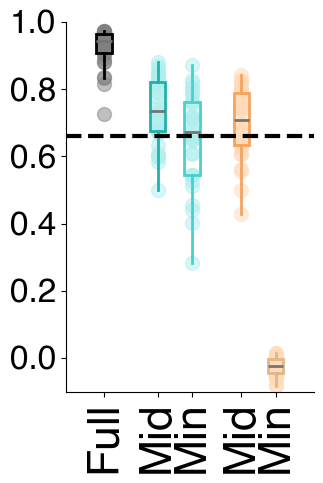

In [1524]:
fig, ax = plt.subplots(figsize=(3.2,4.8))#, sharex=True)

# Plotting on ax1
plt.sca(ax)
y_data = np.array(SSIMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20)
g_pos = np.array([1.5])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True,scatter_alpha=0.5)

y_data = np.array(SSIM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM20NL)
g_pos = np.array([2.6])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.2,scatter=True)

y_data = np.array(SSIM7NL)
g_pos = np.array([3.1])
colors = ['burlywood']
colors2 = ['peachpuff']

plt.axhline(0.66, lw=3, ls='--', c='k')
plt.xticks([0.8,1.5,1.95,2.6,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(-0.1,1)

if Save: plt.savefig(FigLoc+'DKIHCP_SSIM_RK.pdf',format='PDF',transparent=True,bbox_inches='tight')

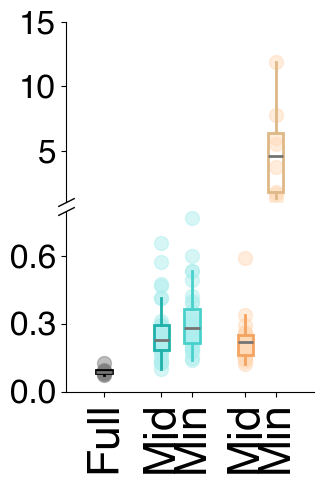

In [1536]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(3.2,4.8))
fig.subplots_adjust(hspace=0.05)



y_data = np.array(AccM7NL)
g_pos = np.array([3.05])
colors = ['burlywood']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(AccMFulls)
g_pos = np.array([0.8])
colors = ['black']
colors2 = ['gray']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20)
g_pos = np.array([1.55])
colors = ['lightseagreen']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM7)
g_pos = np.array([1.95])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(AccM20NL)
g_pos = np.array([2.65])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

plt.xticks([0.8,1.55,1.95,2.65,3.05],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
#ax1.set_ylim(0.4, 1)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax1.yaxis.set_ticks([0.4,0.7,1])
ax1.set_xticks([])

plt.yticks(fontsize=24)

#ax2.set_ylim(0.0,0.3)
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax2.yaxis.set_ticks(np.arange(0, 0.0001, 0.00004))

# Common x-ticks
#ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2
ax1.set_xlim(np.array(ax2.get_xlim()))

# Show plot
ax2.set_ylim(0,0.8)
ax2.set_yticks([0,0.3,0.6])
ax1.set_ylim(1,15)

leg_patch2 = mpatches.Patch(color='mediumturquoise', label='SBI')
leg_patch3 = mpatches.Patch(color='sandybrown', label='NLLS')
leg_patch5 = mpatches.Patch(color='gray', label='Full \nComp.')


if Save: plt.savefig(FigLoc+'DKIHCP_Acc_RK.pdf',format='PDF',transparent=True,bbox_inches='tight')
plt.show()

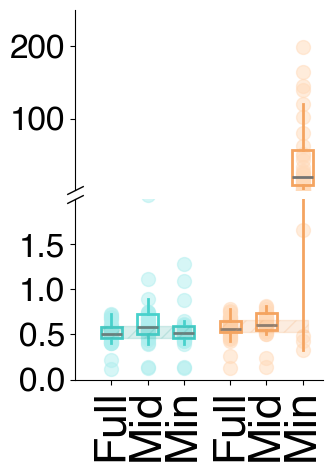

In [1551]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(3.2,4.8))
fig.subplots_adjust(hspace=0.05)



y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.5])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax1,widths=0.2,scatter=True)
plt.xticks([1,1.7,2,2.8,3.1],['Full','Mid','Min','Mid','Min'],fontsize=32,rotation=90)
#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
plt.yticks(fontsize=24)

#ax1.yaxis.set_ticks(np.arange(0.0005, 0.006, 0.002))
ax1.set_xticks([])

plt.sca(ax2)

y_data = np.array(PrecFull_SBI)
g_pos = np.array([0.65])
colors = ['mediumturquoise']
colors2 = ['paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec20_SBI)
g_pos = np.array([1.0])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec7_SBI)
g_pos = np.array([1.35])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(PrecFull_NLLS)
g_pos = np.array([1.8])
colors = ['sandybrown']
colors2 = ['peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec20_NLLS)
g_pos = np.array([2.15])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

y_data = np.array(Prec7_NLLS)
g_pos = np.array([2.5])

BoxPlots(y_data,g_pos,colors,colors2,ax2,widths=0.2,scatter=True)

#plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-0.5,3))
#ax1.set_ylim(0.4, 1)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax1.yaxis.set_ticks([0.4,0.7,1])
ax1.set_xticks([])

plt.yticks(fontsize=24)

#ax2.set_ylim(0.0,0.3)
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
#ax2.yaxis.set_ticks(np.arange(0, 0.0001, 0.00004))

# Common x-ticks
#ax2.set_xticks([1, 1.7, 2, 2.8, 3.1])

# Adding broken axis effect
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

# Hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.yaxis.offsetText.set_visible(False)  # Hide the "1e-3" from ax2
ax2.set_xlim([0.3,2.7])
ax1.set_xlim(ax2.get_xlim())
# Show plot
ax2.set_ylim(0,2)
ax2.set_yticks([0,0.5,1,1.5])
ax1.set_ylim(1,250)

x = np.arange(1.7,2.6,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_NLLS)[~np.isnan(PrecFull_NLLS)], 77)
plt.fill_between(x,y1,y2,color=WLSFit,zorder=10,alpha=0.2,hatch='//')

x = np.arange(0.55,1.5,0.05)
y1 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 25)
y2 = np.ones_like(x)*np.percentile(np.array(PrecFull_SBI)[~np.isnan(PrecFull_SBI)], 77)
plt.fill_between(x,y1,y2,color=SBIFit,zorder=10,alpha=0.2,hatch='//')

plt.xticks([0.65,1,1.35,1.8,2.15,2.5],['Full','Mid','Min','Full','Mid','Min'],fontsize=32,rotation=90)
if Save: plt.savefig(FigLoc+'DKI_RK_Prec.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()